In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
filenames = glob.glob("../data/CICIDS2017/LabeledData_CICIDS2017/*")
filenames
for i,fn in enumerate(filenames):
    print("load file",fn)
    if i==0:
        df = pd.read_csv(fn)
    else:
        df_temp = pd.read_csv(fn)
        df = pd.concat([df,df_temp])
        del df_temp

load file ../data/CICIDS2017/LabeledData_CICIDS2017/FWH.csv
load file ../data/CICIDS2017/LabeledData_CICIDS2017/WedWH.csv
load file ../data/CICIDS2017/LabeledData_CICIDS2017/MonWH.csv
load file ../data/CICIDS2017/LabeledData_CICIDS2017/TueWH.csv
load file ../data/CICIDS2017/LabeledData_CICIDS2017/ThrWH.csv


In [3]:
# df = pd.read_csv("../data/CICIDS2017/CICIDS2017_TroubleShooted.csv",header=0)

# Explore dataset

In [4]:
df.head()

Flow ID        Src IP  Src Port        Dst IP  \
0  192.168.10.9-192.168.10.3-1031-88-6  192.168.10.9      1031  192.168.10.3   
1  192.168.10.9-192.168.10.3-1032-88-6  192.168.10.9      1032  192.168.10.3   
2  192.168.10.9-192.168.10.3-1033-88-6  192.168.10.9      1033  192.168.10.3   
3  192.168.10.9-192.168.10.3-1034-88-6  192.168.10.9      1034  192.168.10.3   
4  192.168.10.9-192.168.10.3-1036-88-6  192.168.10.9      1036  192.168.10.3   

   Dst Port  Protocol               Timestamp  Flow Duration  \
0        88         6  07/07/2017 09:00:35 PM            707   
1        88         6  07/07/2017 09:00:35 PM            961   
2        88         6  07/07/2017 09:00:35 PM           1095   
3        88         6  07/07/2017 09:00:35 PM            733   
4        88         6  07/07/2017 09:00:35 PM            907   

   Total Fwd Packet  Total Bwd packets  ...  Fwd Seg Size Min  Active Mean  \
0                 7                  7  ...                20          0.0   
1                 9                  7  ...                20          0.0   
2                 9                  9  ...                20          0.0   
3                 7                  7  ...                20          0.0   
4                 9                  9  ...                20          0.0   

   Active Std  Active Max  Active Min  Idle Mean  Idle Std  Idle Max  \
0         0.0         0.0         0.0        0.0       0.0       0.0   
1         0.0         0.0         0.0        0.0       0.0       0.0   
2         0.0         0.0         0.0        0.0       0.0       0.0   
3         0.0         0.0         0.0        0.0       0.0       0.0   
4         0.0         0.0         0.0        0.0       0.0       0.0   

   Idle Min   Label  
0       0.0  BENIGN  
1       0.0  BENIGN  
2       0.0  BENIGN  
3       0.0  BENIGN  
4       0.0  BENIGN  

[5 rows x 84 columns]

In [5]:
df.columns

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Len

# Preprocess DF

- drop data with missing values
- drop data with negative values
- drop data with only a single value
- remove duplicates

In [8]:
def preprocess_df(df, flow_cols = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Timestamp']):
    
    """
        flow_cols: the columns that we want to remove for constructing ML model
    """
    
    print("original df: ", df.shape)
    print("+"*50)

    print("drop NA")
    df_proc = df.replace([np.inf, -np.inf], np.nan)
    df_proc.dropna(axis=0, inplace=True)
    print("drop rows: ", df.shape[0]-df_proc.shape[0])
    print("data size after dropping", df_proc.shape)
    print("+"*50)
    
    tmp = df_proc.shape
    print("remove data having negative values")
    numeric_cols = _numeric_col(df_proc)
    df_proc = df_proc[(df_proc[numeric_cols]>=0).all(axis=1)]
    print("drop rows: ", tmp[0]-df_proc.shape[0])
    print("data after droppnig negative: ", df_proc.shape)
    print("+"*50)
    
    tmp = df_proc.shape
    print("drop deficient columns")
    dfc_col = find_deficient_col(df_proc)
    print("//".join(dfc_col))
    df_proc.drop(columns = dfc_col, inplace = True)
    print("drop columns: ", tmp[1]-df_proc.shape[1])
    print("data after droppnig columns: ", df_proc.shape)
    print("+"*50)
    
    tmp = df_proc.shape
    print("remove duplicates")
    df_proc.drop_duplicates(inplace=True, ignore_index=True)
    print("drop rows: ", tmp[0]-df_proc.shape[0])
    print("+"*50)
    
    tmp = df_proc.shape
    print("remove inappropriate columns for ML")
    print(flow_cols)
    df_proc.drop(columns = flow_cols, inplace=True)
    print("drop columns: ", tmp[1]-df_proc.shape[1])
    print("data after droppnig columns: ", df_proc.shape)
    print("+"*50)
    
    
    print("final df shape:", df_proc.shape)
    print("final differences: ", df.shape[0]-df_proc.shape[0],
         df.shape[1]-df_proc.shape[1])
    df_proc.reset_index(inplace=True, drop=True)
    
    return df_proc

def _numeric_col(df):
    cols = []
    for cn in df.columns:
        col = df[cn]
        if col.dtypes in ['int64','float64']:
            cols.append(cn)
    return cols

def find_deficient_col(df):
    dfc_col = []
    for col in df.columns:
        if len(df[col].unique()) ==1:
            dfc_col.append(col)
    return dfc_col

In [6]:
print("the number of duplicates: ",len(df)-len(df.drop_duplicates(ignore_index=True)))
print("the ratio of duplicates: ",(len(df)-len(df.drop_duplicates(ignore_index=True)))/len(df))

the number of duplicates:  4566
the ratio of duplicates:  0.001676678018332561


In [9]:
print("Column counts with negative values")
numeric_cols = _numeric_col(df)
aa = (df[numeric_cols]<0).sum(axis=0)
print(aa[aa>0])

Column counts with negative values
Flow Duration       48
Flow Bytes/s         2
Flow Packets/s      48
Flow IAT Mean       48
Flow IAT Max        48
Flow IAT Min      2838
Fwd IAT Min          6
dtype: int64


In [10]:
df_proc = preprocess_df(df)

original df:  (2723242, 84)
++++++++++++++++++++++++++++++++++++++++++++++++++
drop NA
drop rows:  2217
data size after dropping (2721025, 84)
++++++++++++++++++++++++++++++++++++++++++++++++++
remove data having negative values
drop rows:  2838
data after droppnig negative:  (2718187, 84)
++++++++++++++++++++++++++++++++++++++++++++++++++
drop deficient columns
Bwd PSH Flags//Bwd URG Flags//Fwd Bytes/Bulk Avg//Fwd Packet/Bulk Avg//Fwd Bulk Rate Avg
drop columns:  5
data after droppnig columns:  (2718187, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++
remove duplicates
drop rows:  4564
++++++++++++++++++++++++++++++++++++++++++++++++++
remove inappropriate columns for ML
['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Timestamp']
drop columns:  5
data after droppnig columns:  (2713623, 74)
++++++++++++++++++++++++++++++++++++++++++++++++++
final df shape: (2713623, 74)
final differences:  9619 10


## Standardize Data

- skewness test on variables

In [11]:
def histogram_dataframe(df):
    for colname in df.columns:
        col = df[colname]
    #     print(colname, col.dtypes)
        if col.dtypes in ['int64','float64']:
            print(min(col))
    #         print(len(col)-sum(np.isfinite(col)), sum(pd.isna(col)), sum(pd.isnull(col)),
    #               max(col[np.isfinite(col)]), min(col[np.isfinite(col)]),len(col.unique()))
            plt.title(colname+" "+str(col.skew()))
            plt.hist(col[np.isfinite(col)])
            plt.show()

In [12]:
import matplotlib.pyplot as plt

def histogram_labeltypes(df, colnames = None, label_name = 'Label'):

    if colnames is None:
        colnames = df.columns
    
    label_col = df[label_name]
    labels = list(label_col.unique())
#     print(len(labels))
    lab_idxs_dic = find_colvalidx(label_col, labels)
    
    for colname in colnames:
        col = df[colname]
        print("+"*50)
        print(colname, "min, max, mean")
        print("+"*50)
        if col.dtypes in ['int64','float64']:
            histogram_column(col, lab_idxs_dic, 5,3)
            
def find_colvalidx(col,colvals):
    col_idxs_dic = {}
    for colv in colvals:
#         print(colv)
        col_idxs_dic[colv] = col==colv
    return col_idxs_dic

def histogram_column(col, lab_idxs_dic, nrows=5, ncols = 3):
    fig, ax = plt.subplots(nrows, ncols, figsize=(15,20))
#     print(lab_idxs_dic.keys())
    for i,lb in enumerate(lab_idxs_dic):
        idx = lab_idxs_dic[lb]
        r = int(i/ncols)
        c = i%ncols
#         print(r,c)
        colidx = col[idx]
        title_col = lb + " %.2f ; %.2f ; %.2f" %(colidx.min(),colidx.max(),colidx.mean())
        ax[r,c].hist(colidx)
        ax[r,c].set_title(title_col)
#     plt.tight_layout()

    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
    colname = col.name.replace("/","_")
    plt.savefig("../results/"+colname+"_hist.png")
    plt.show()
        

In [13]:
df_proc.head()

Dst Port  Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0        88         6            707                 7                  7   
1        88         6            961                 9                  7   
2        88         6           1095                 9                  9   
3        88         6            733                 7                  7   
4        88         6            907                 9                  9   

   Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                       466.0                       414.0   
1                       626.0                      3064.0   
2                      3104.0                      3036.0   
3                      2794.0                      2820.0   
4                      3130.0                      3048.0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  ...  \
0                  233.0                    0.0               66.571429  ...   
1                  313.0                    0.0               69.555556  ...   
2                 1552.0                    0.0              344.888889  ...   
3                 1397.0                    0.0              399.142857  ...   
4                 1565.0                    0.0              347.777778  ...   

   Fwd Seg Size Min  Active Mean  Active Std  Active Max  Active Min  \
0                20          0.0         0.0         0.0         0.0   
1                20          0.0         0.0         0.0         0.0   
2                20          0.0         0.0         0.0         0.0   
3                20          0.0         0.0         0.0         0.0   
4                20          0.0         0.0         0.0         0.0   

   Idle Mean  Idle Std  Idle Max  Idle Min   Label  
0        0.0       0.0       0.0       0.0  BENIGN  
1        0.0       0.0       0.0       0.0  BENIGN  
2        0.0       0.0       0.0       0.0  BENIGN  
3        0.0       0.0       0.0       0.0  BENIGN  
4        0.0       0.0       0.0       0.0  BENIGN  

[5 rows x 74 columns]

++++++++++++++++++++++++++++++++++++++++++++++++++
Dst Port min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


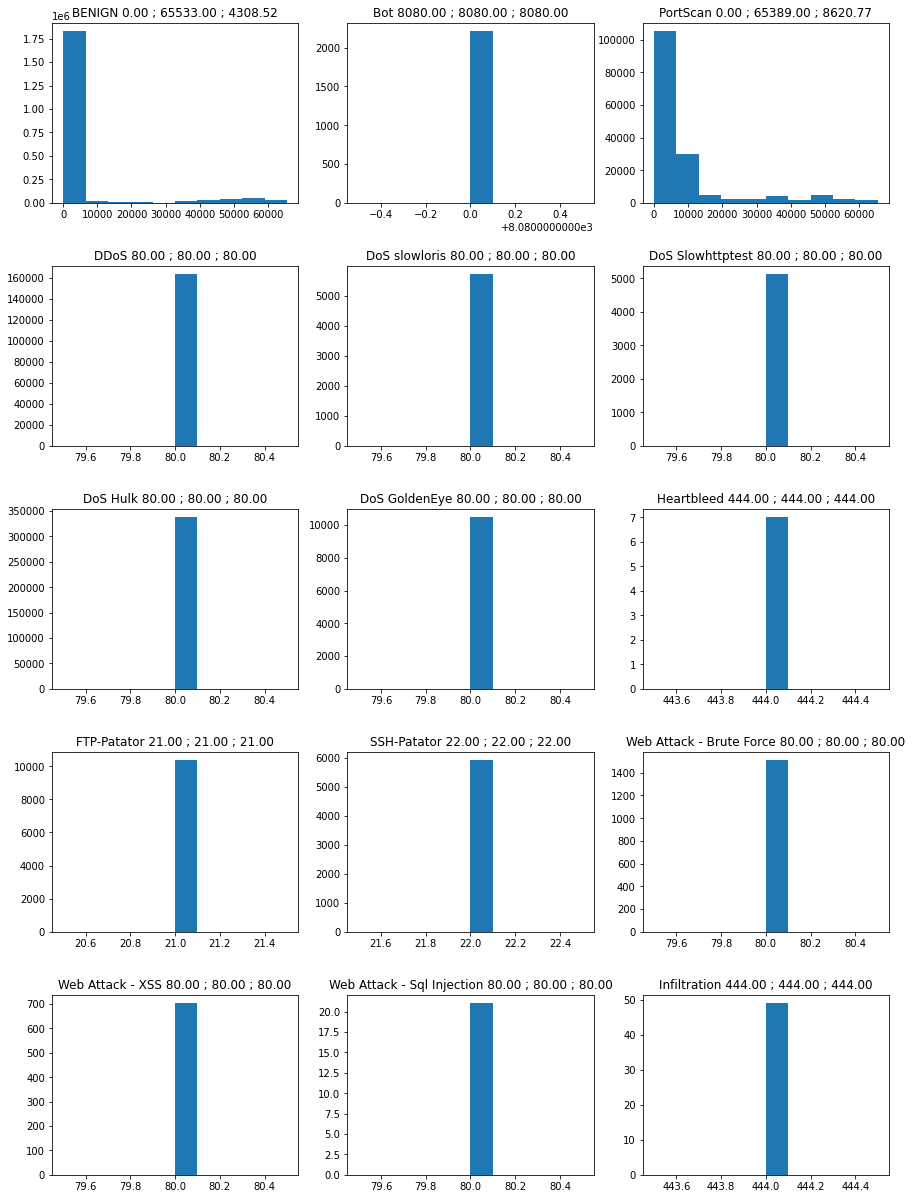

++++++++++++++++++++++++++++++++++++++++++++++++++
Protocol min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


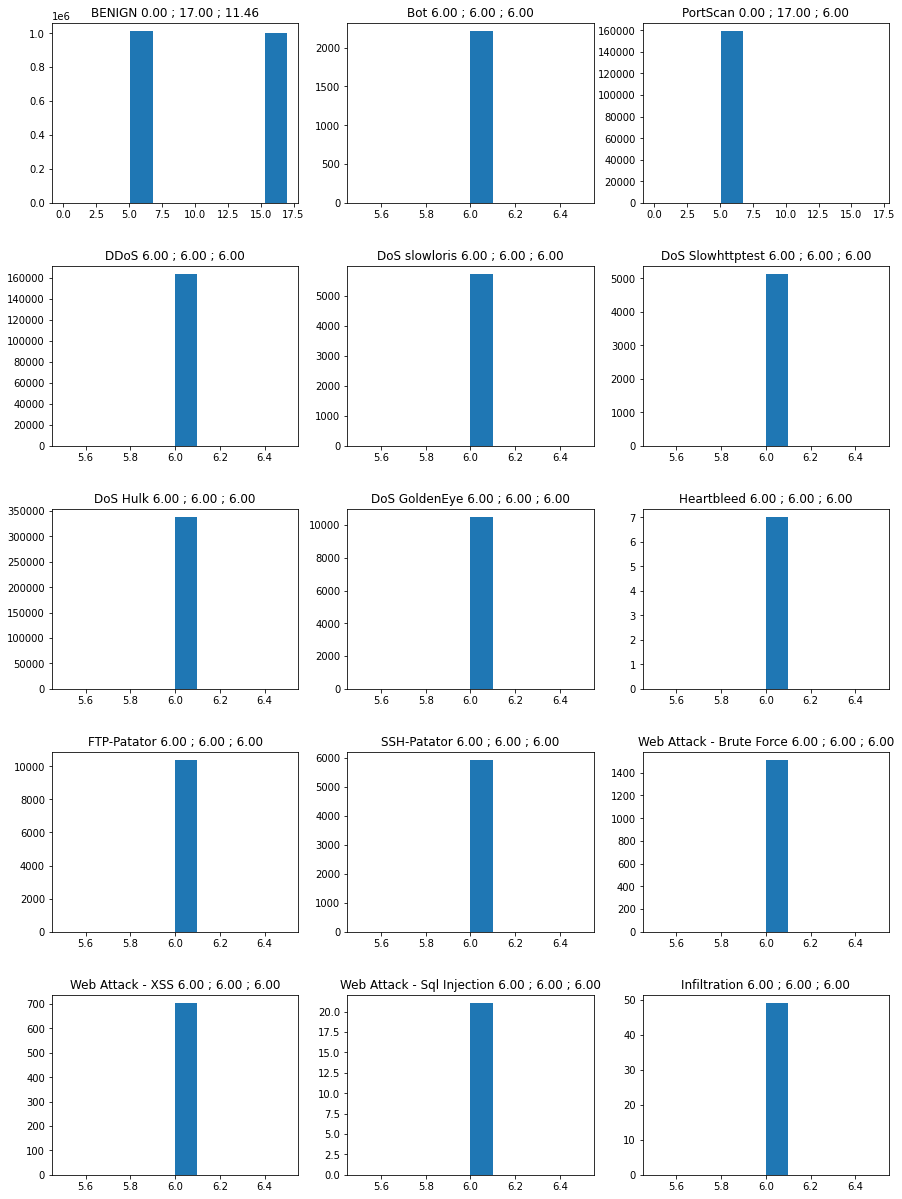

++++++++++++++++++++++++++++++++++++++++++++++++++
Flow Duration min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


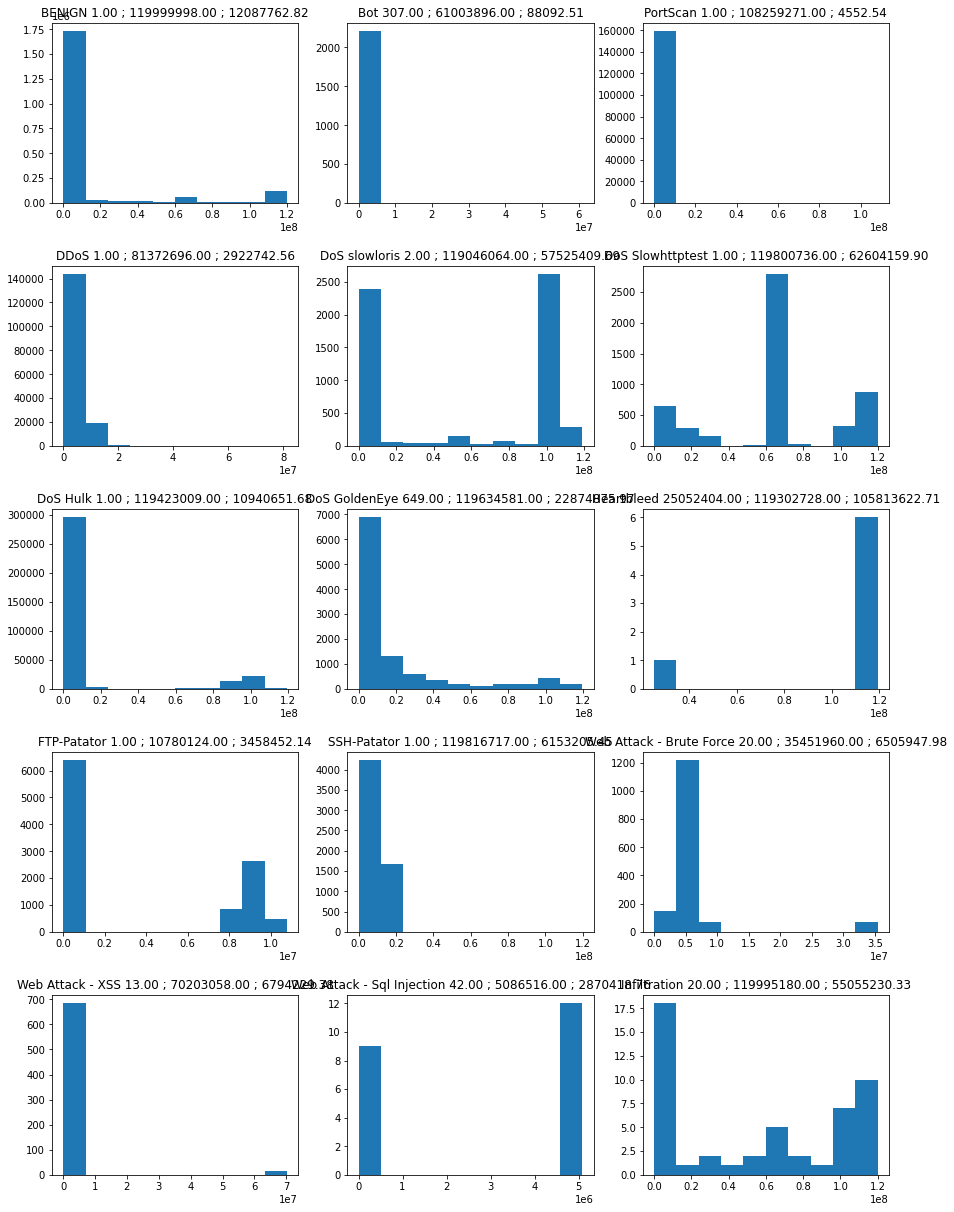

++++++++++++++++++++++++++++++++++++++++++++++++++
Total Fwd Packet min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


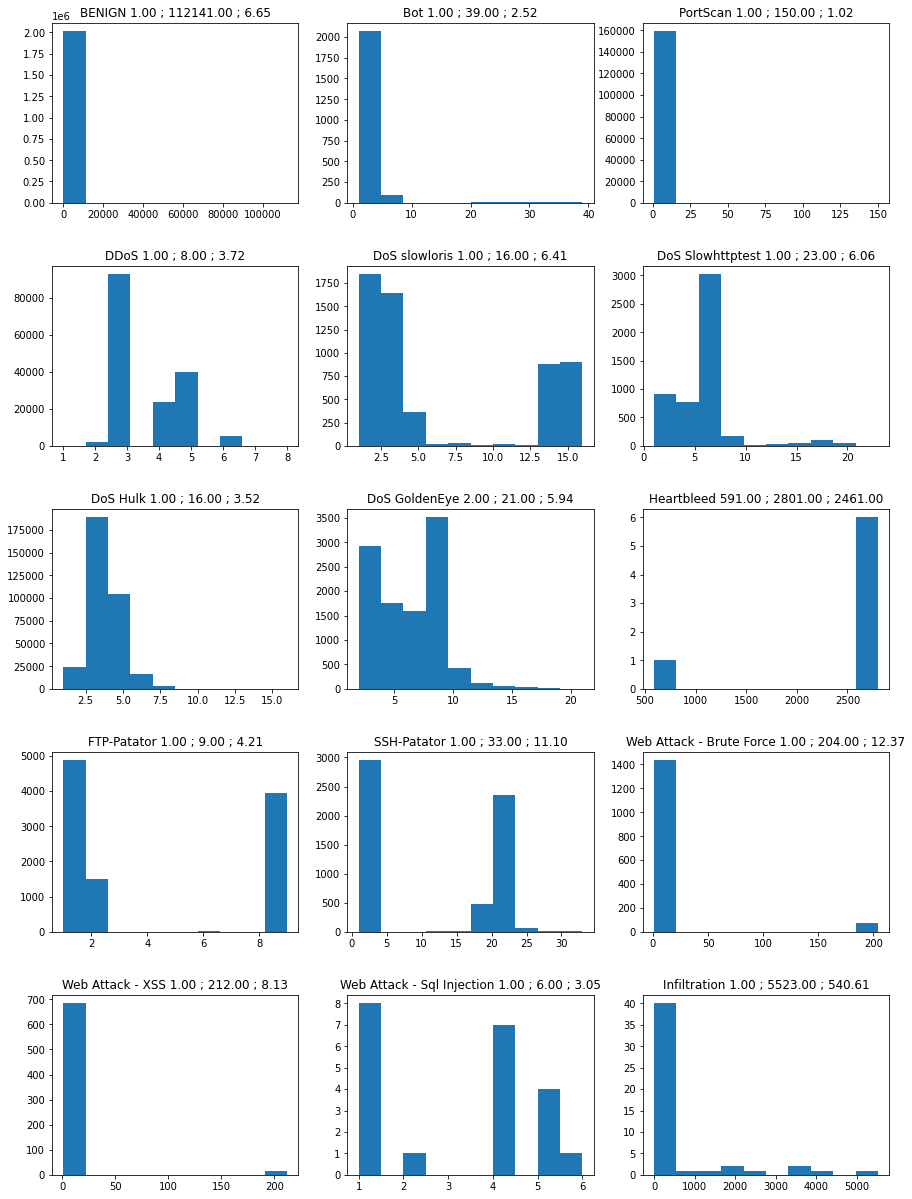

++++++++++++++++++++++++++++++++++++++++++++++++++
Total Bwd packets min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


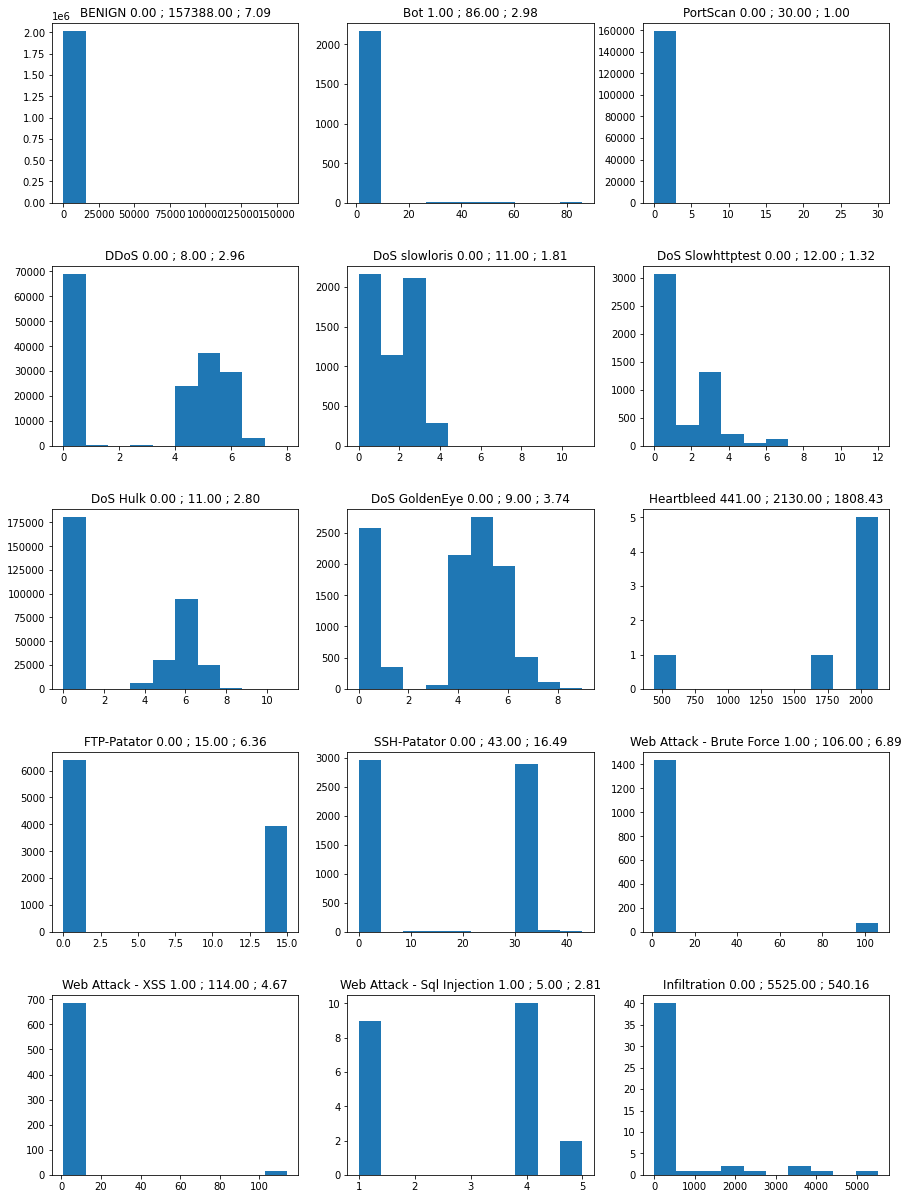

++++++++++++++++++++++++++++++++++++++++++++++++++
Total Length of Fwd Packet min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


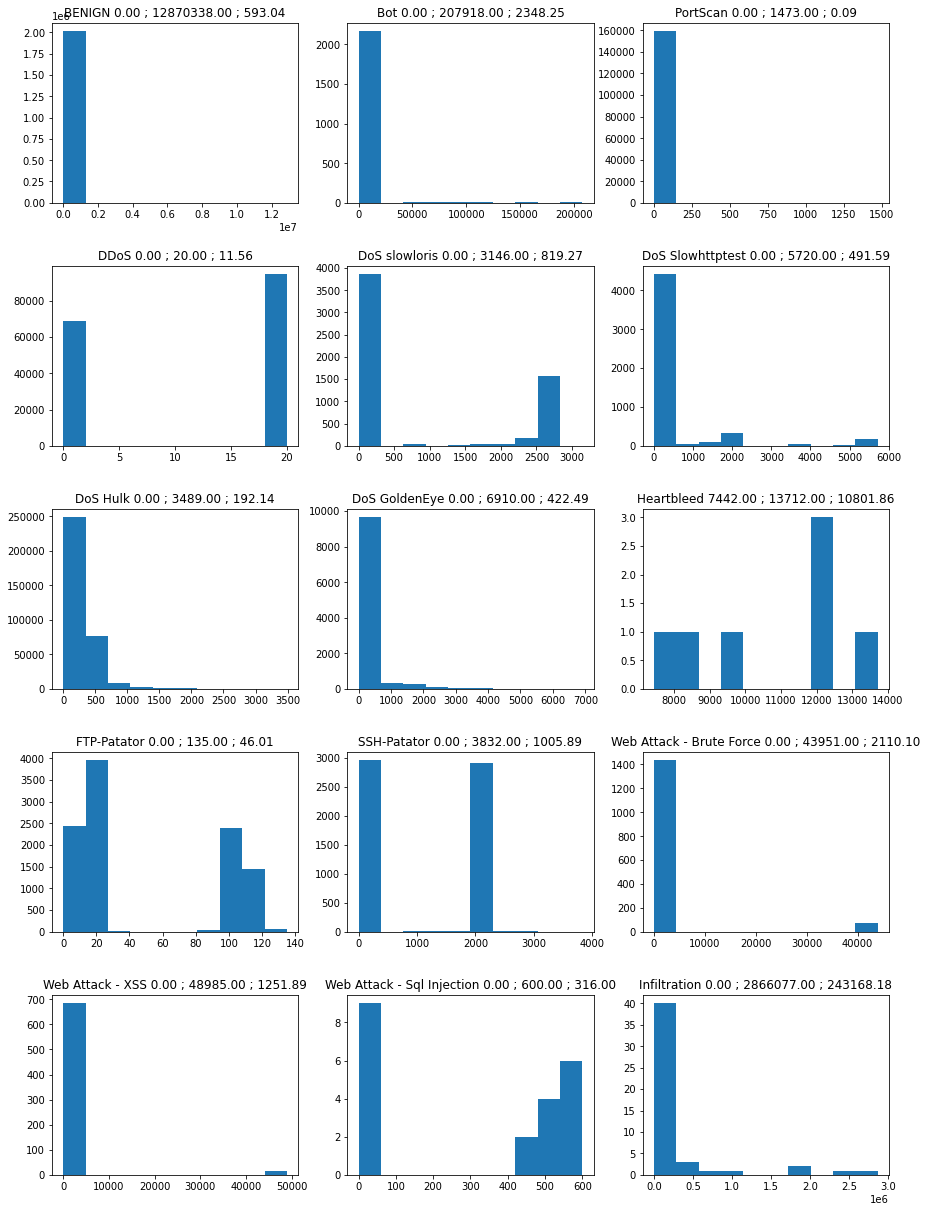

++++++++++++++++++++++++++++++++++++++++++++++++++
Total Length of Bwd Packet min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


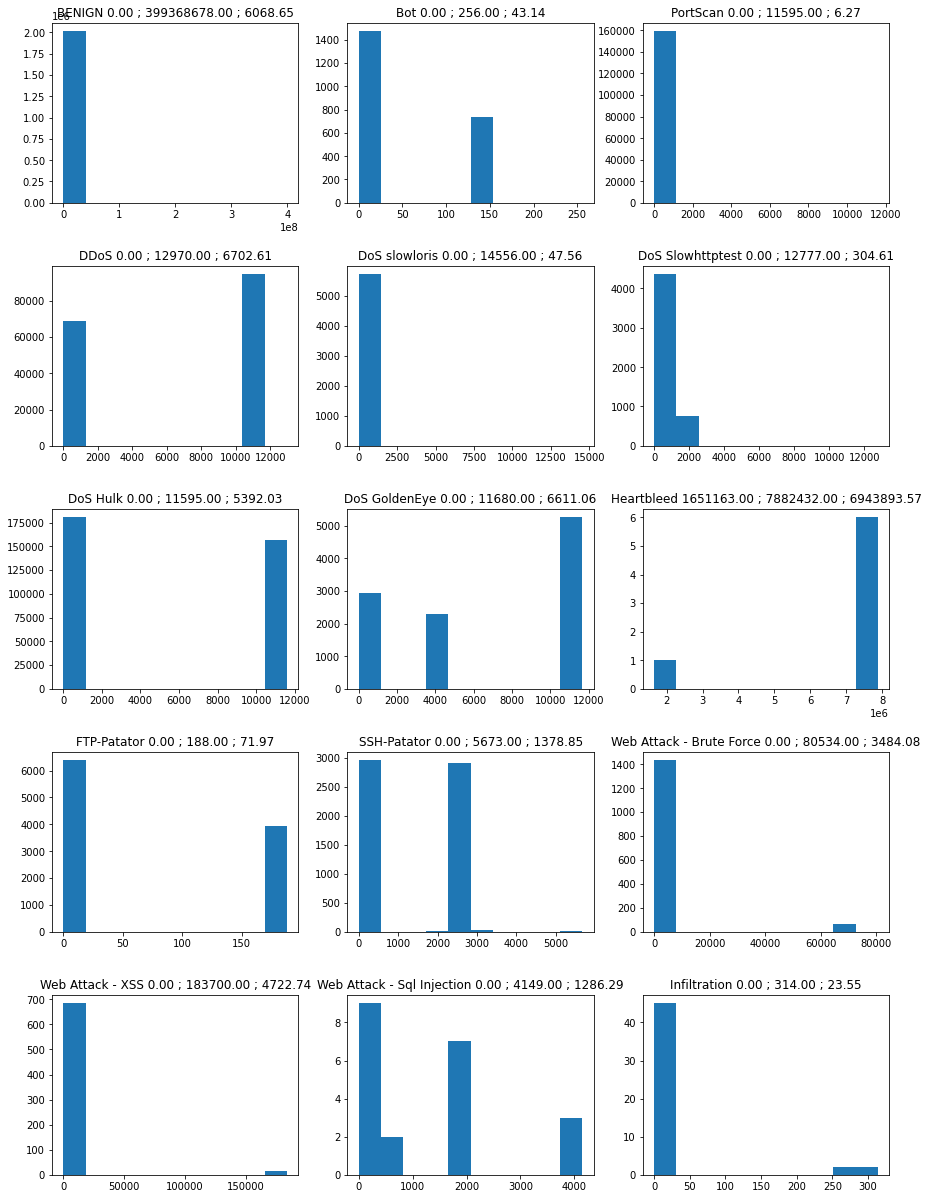

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd Packet Length Max min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


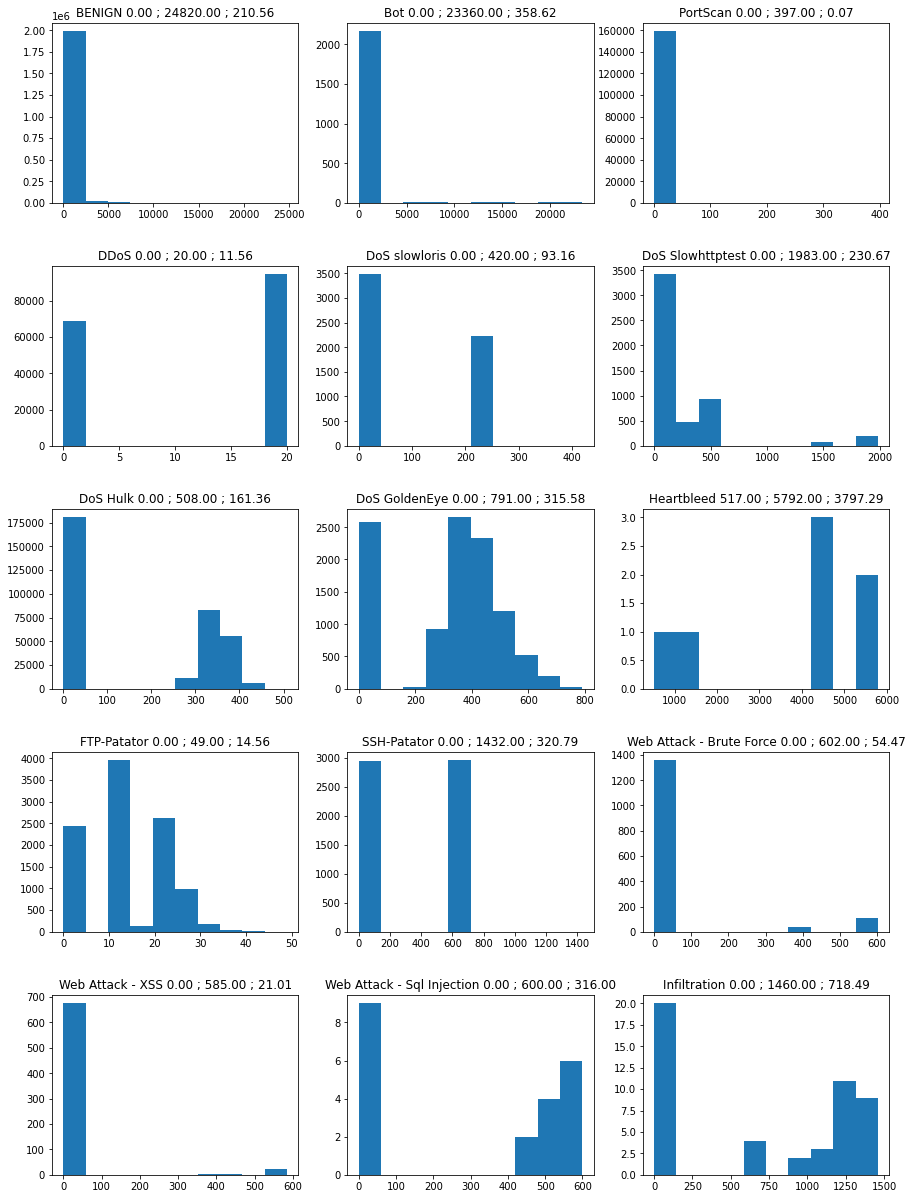

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd Packet Length Min min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


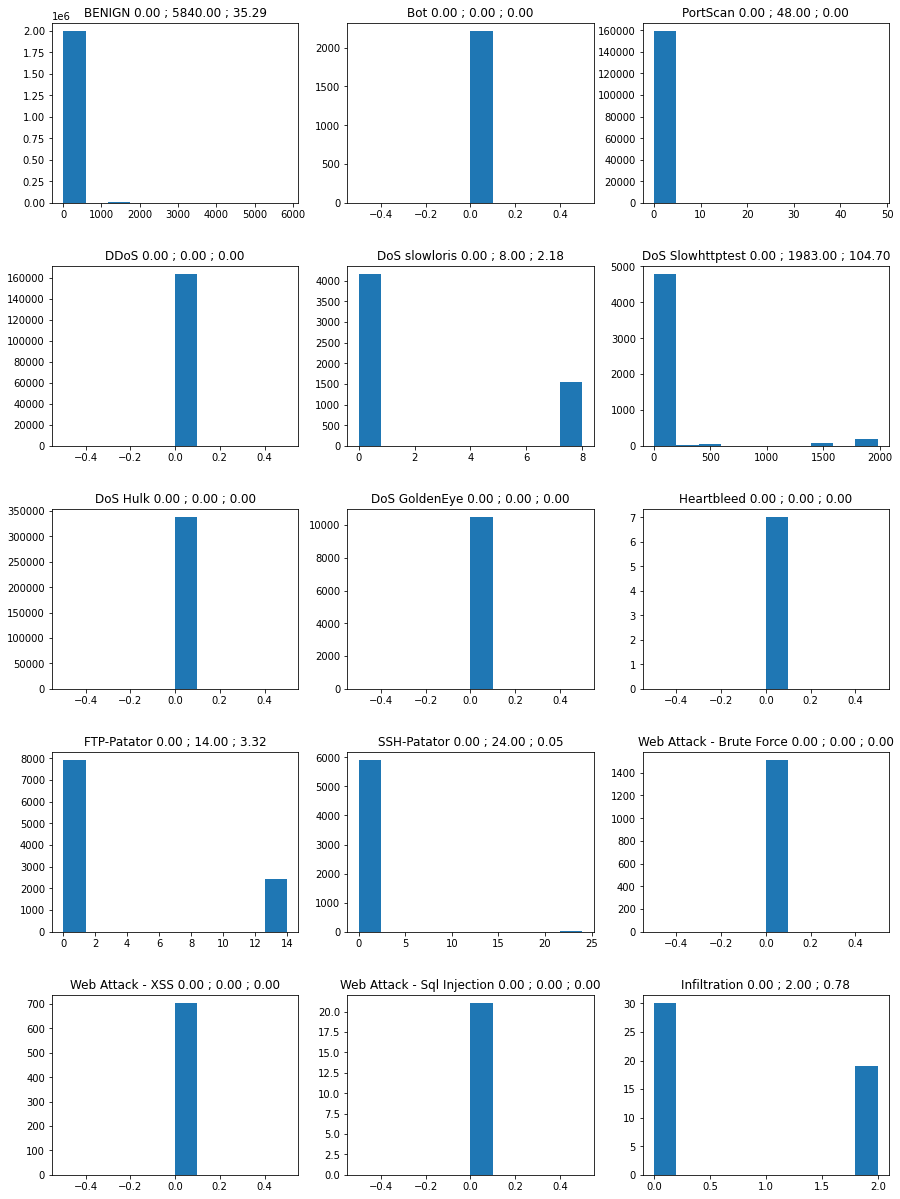

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd Packet Length Mean min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


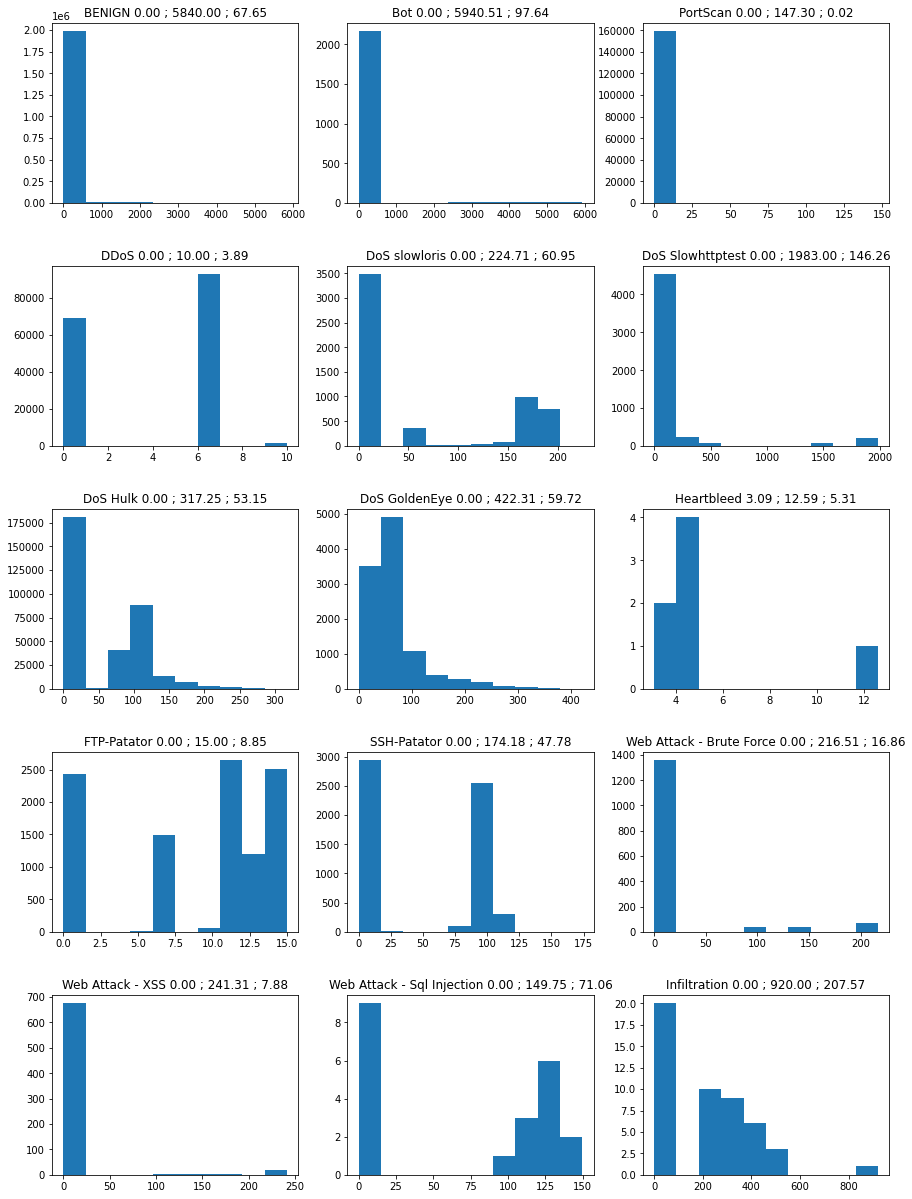

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd Packet Length Std min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


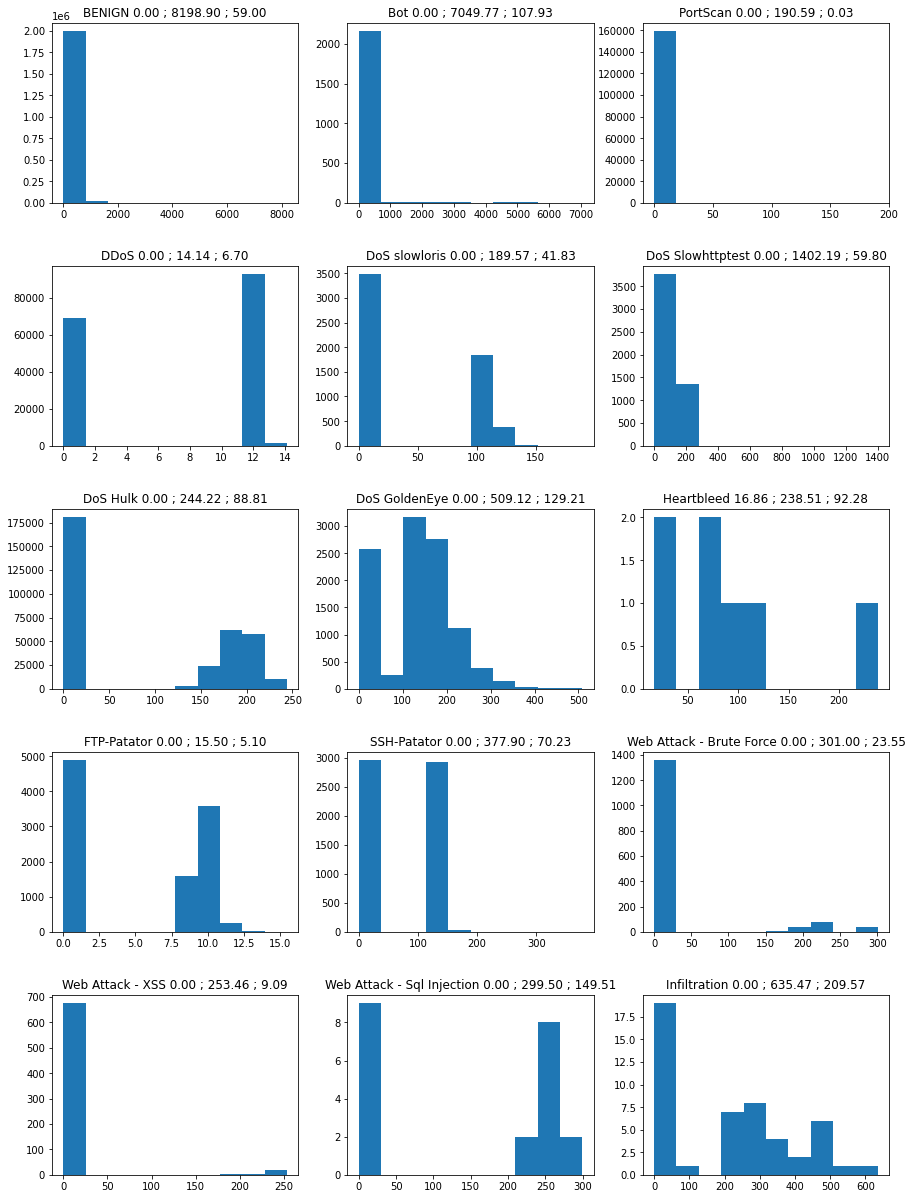

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd Packet Length Max min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


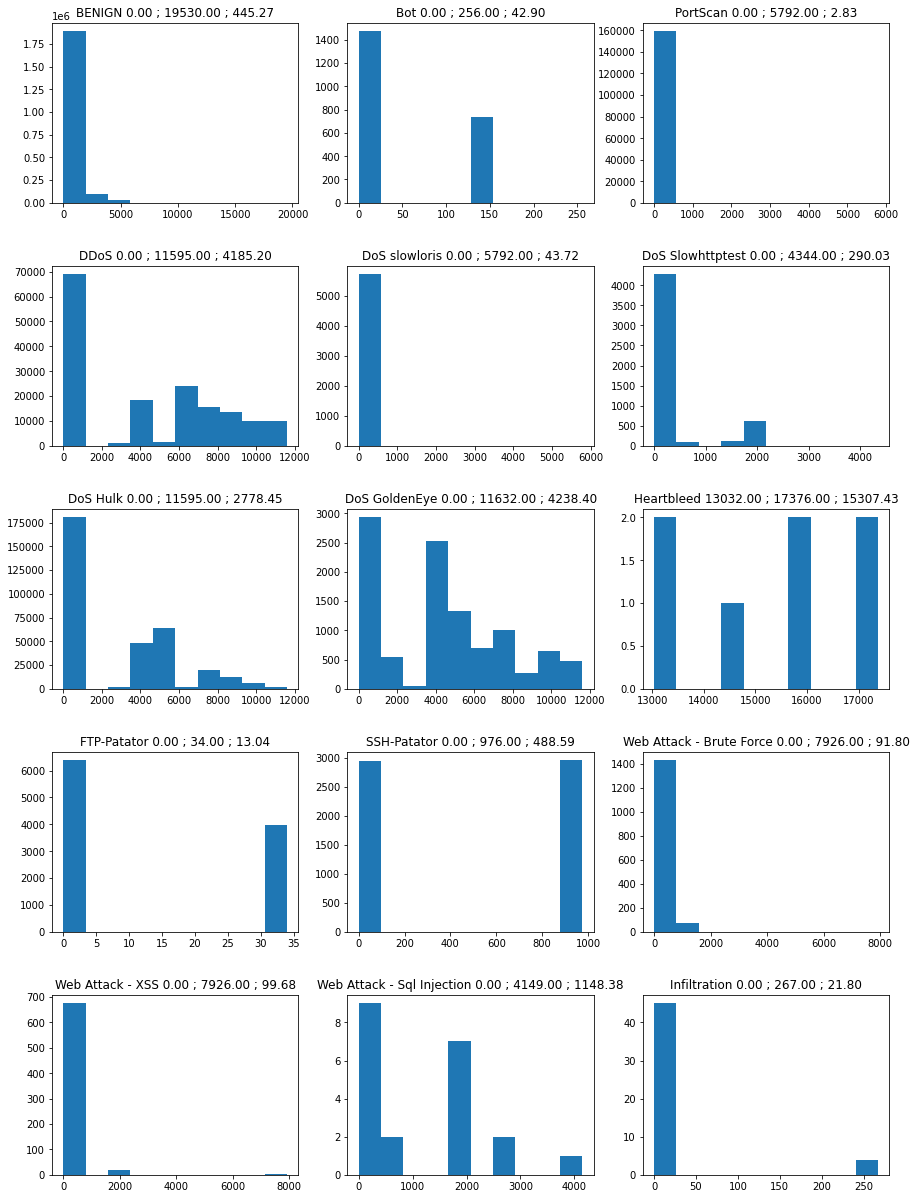

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd Packet Length Min min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


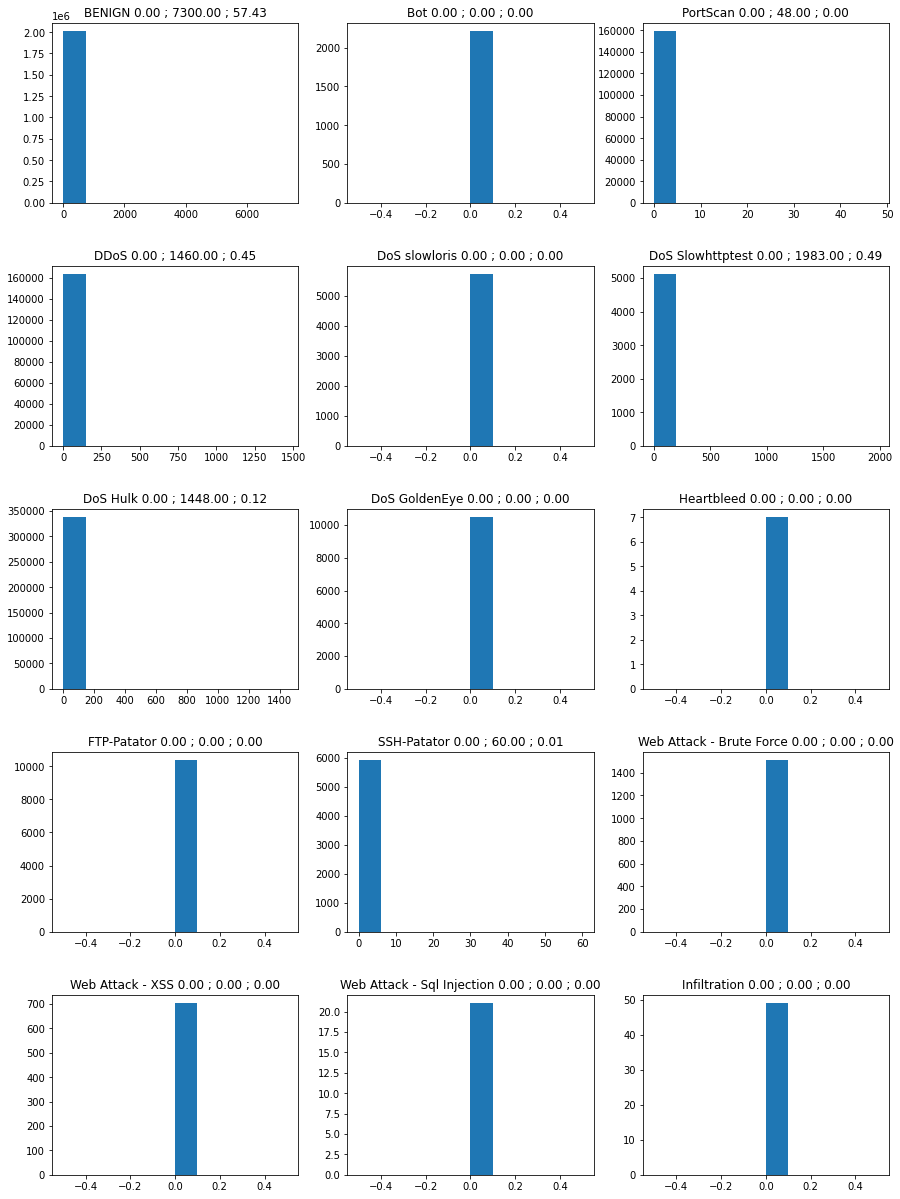

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd Packet Length Mean min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


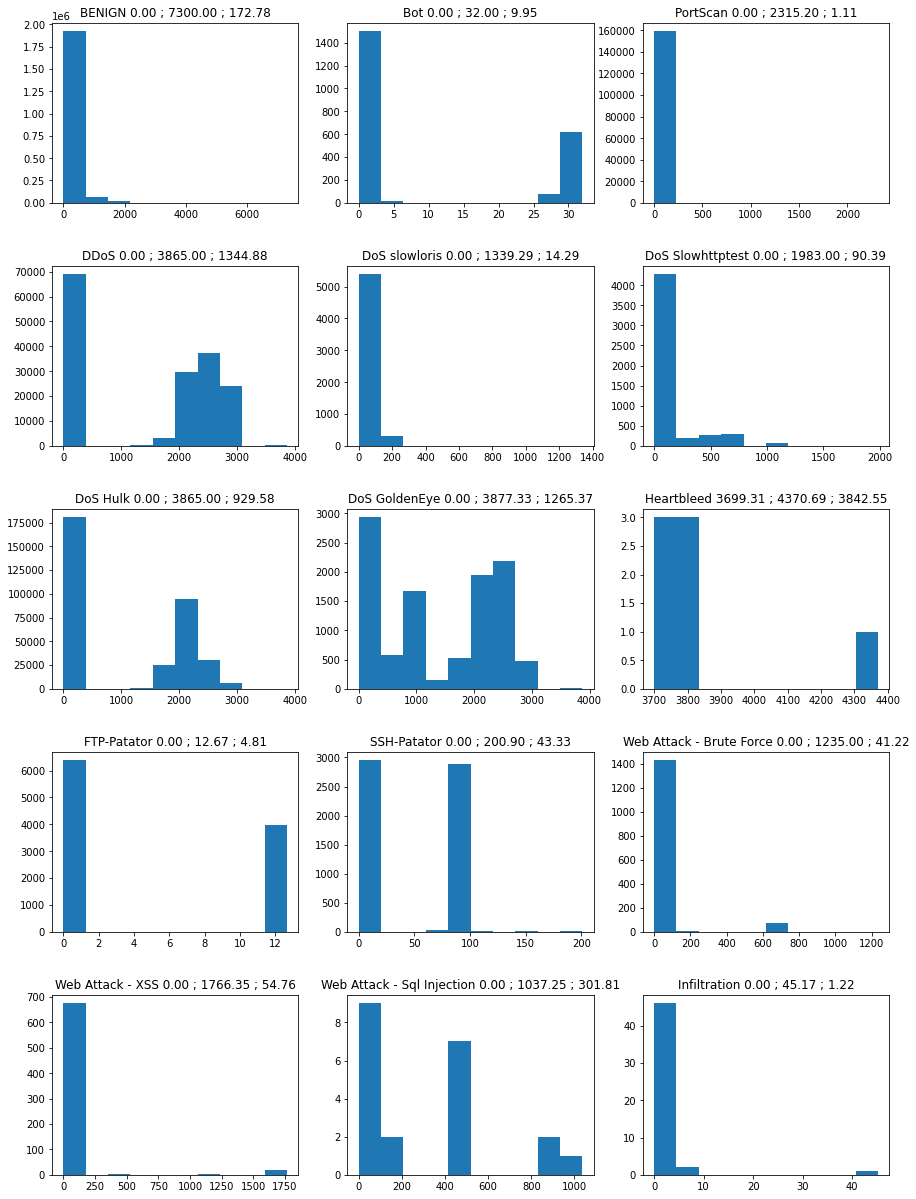

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd Packet Length Std min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


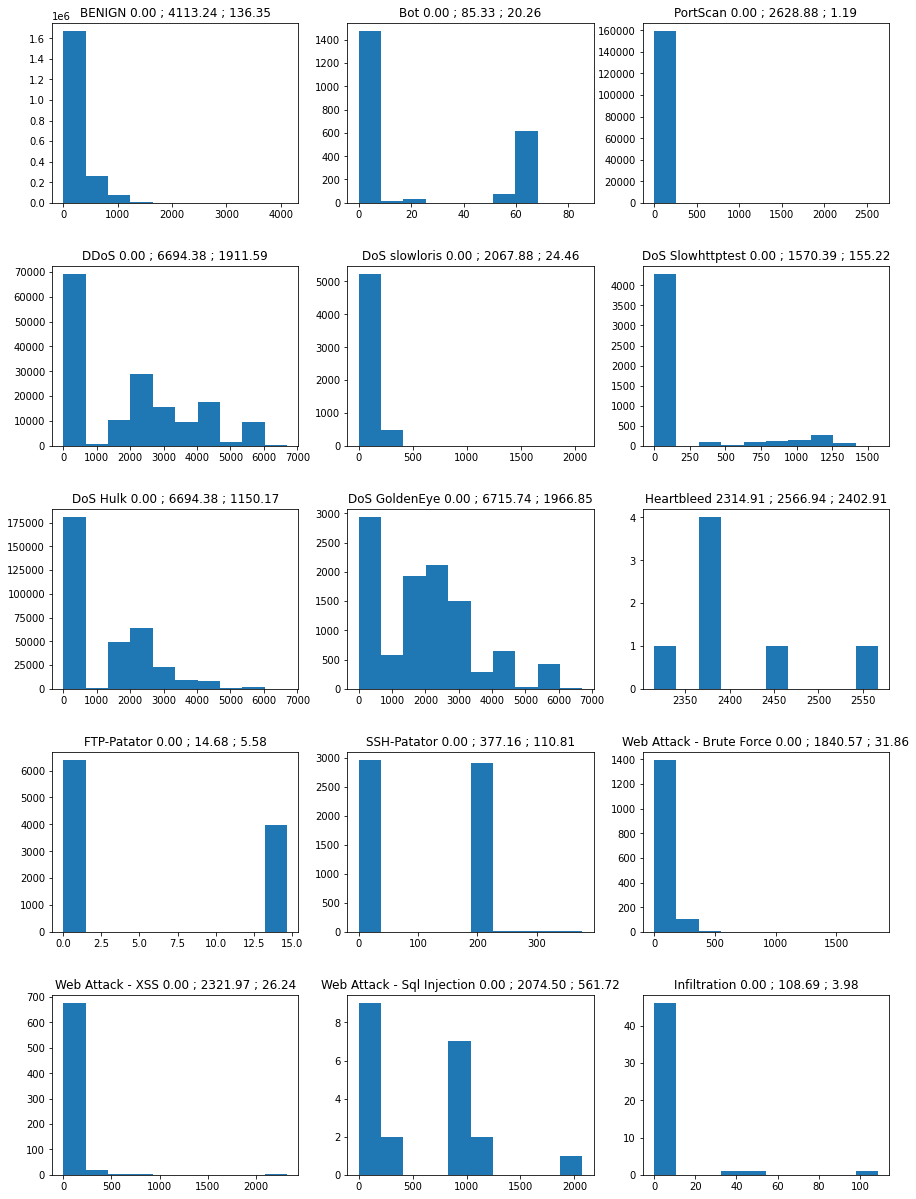

++++++++++++++++++++++++++++++++++++++++++++++++++
Flow Bytes/s min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


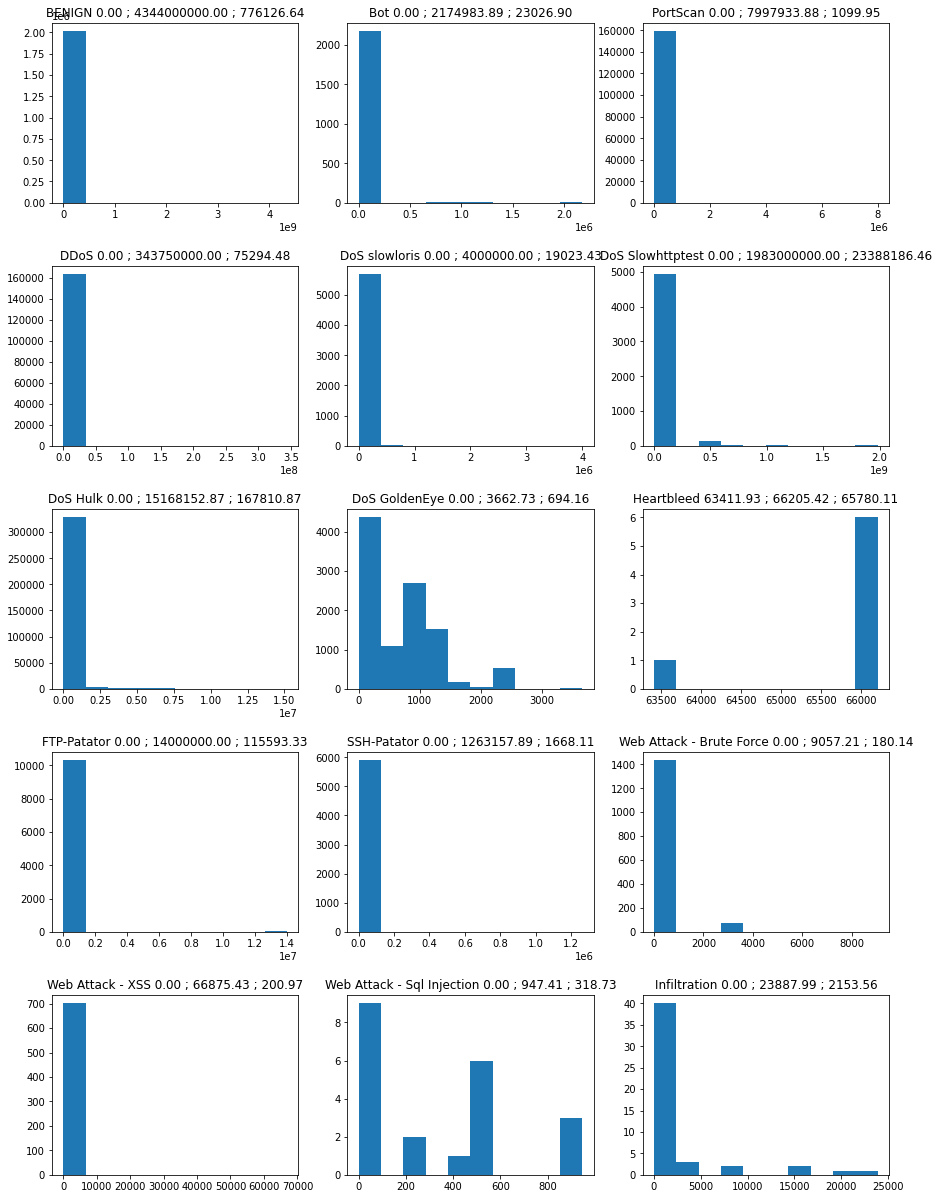

++++++++++++++++++++++++++++++++++++++++++++++++++
Flow Packets/s min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


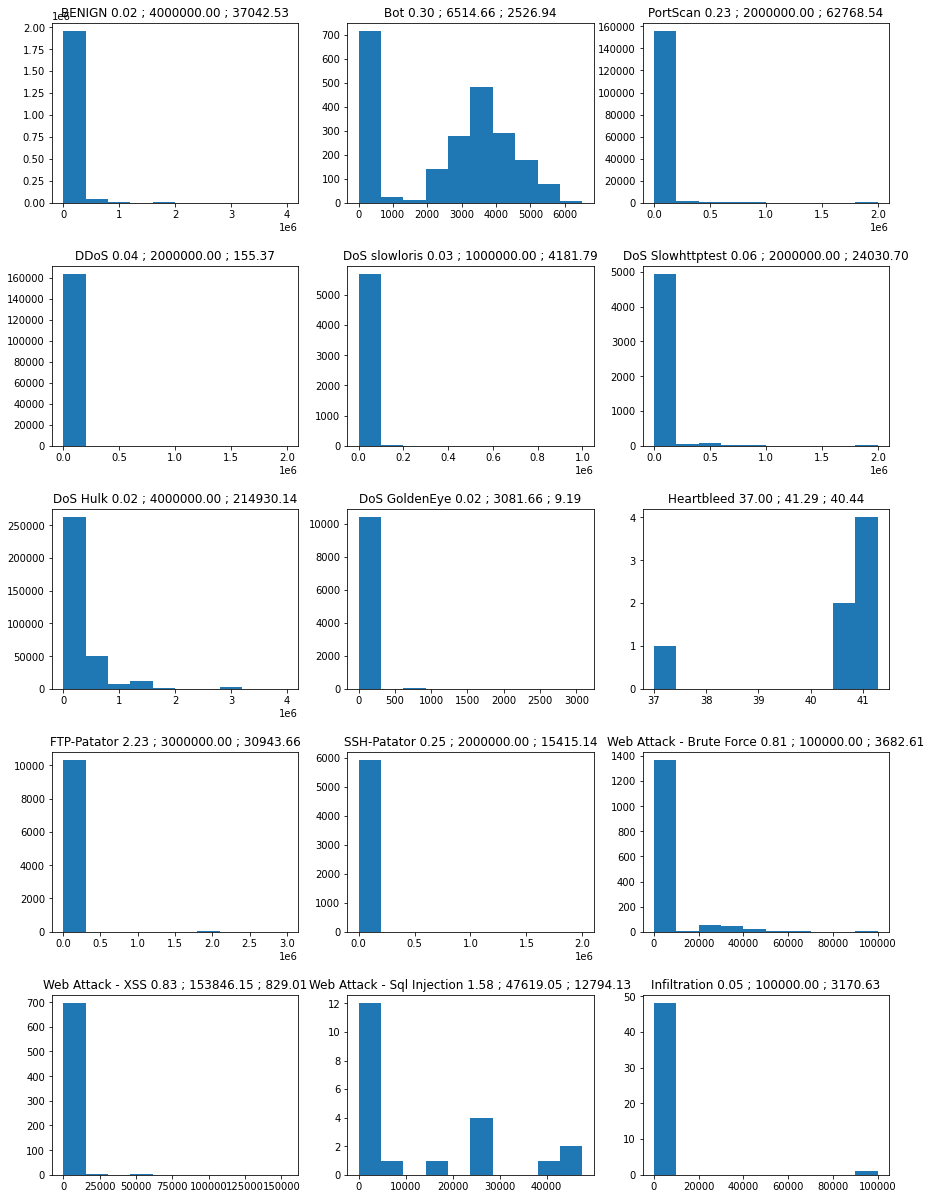

++++++++++++++++++++++++++++++++++++++++++++++++++
Flow IAT Mean min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


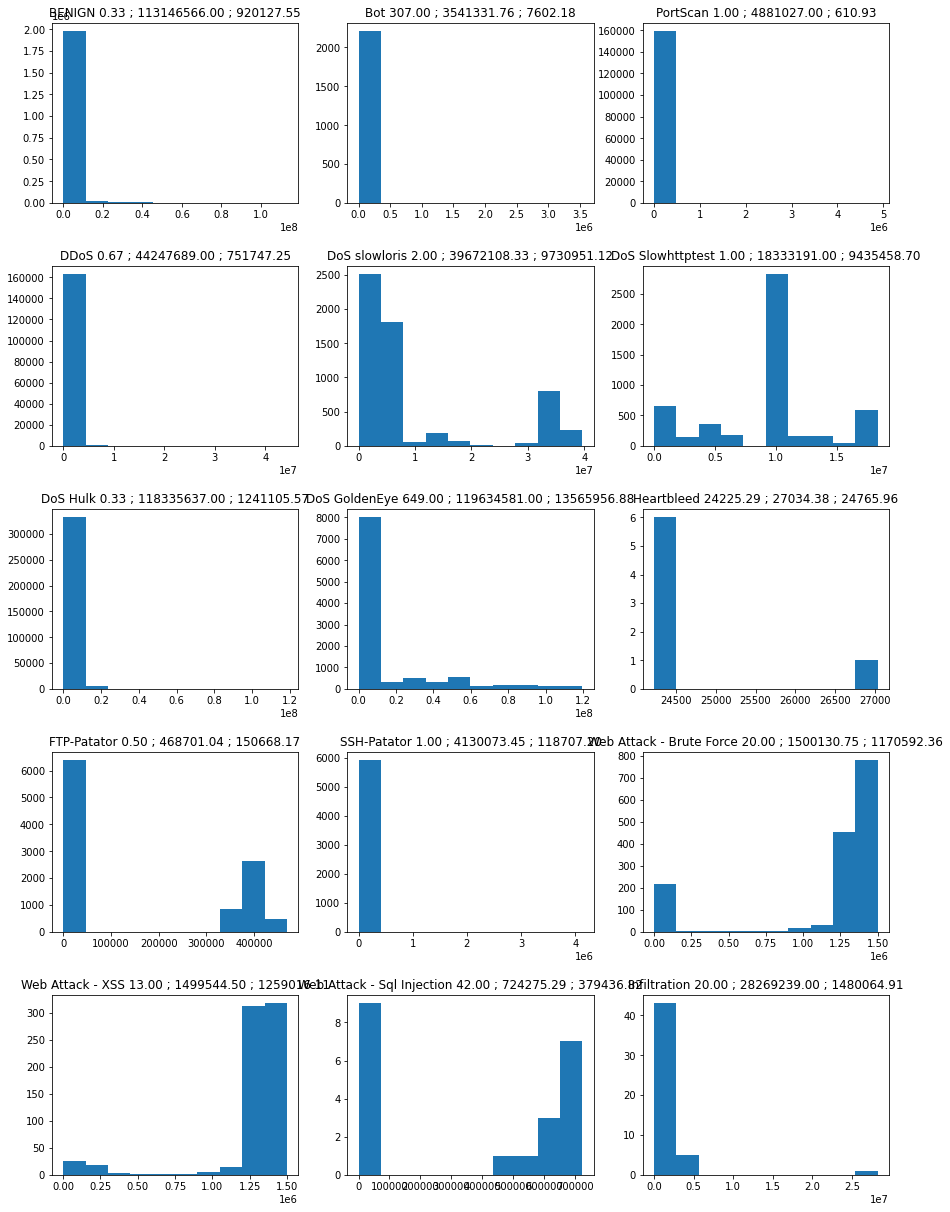

++++++++++++++++++++++++++++++++++++++++++++++++++
Flow IAT Std min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


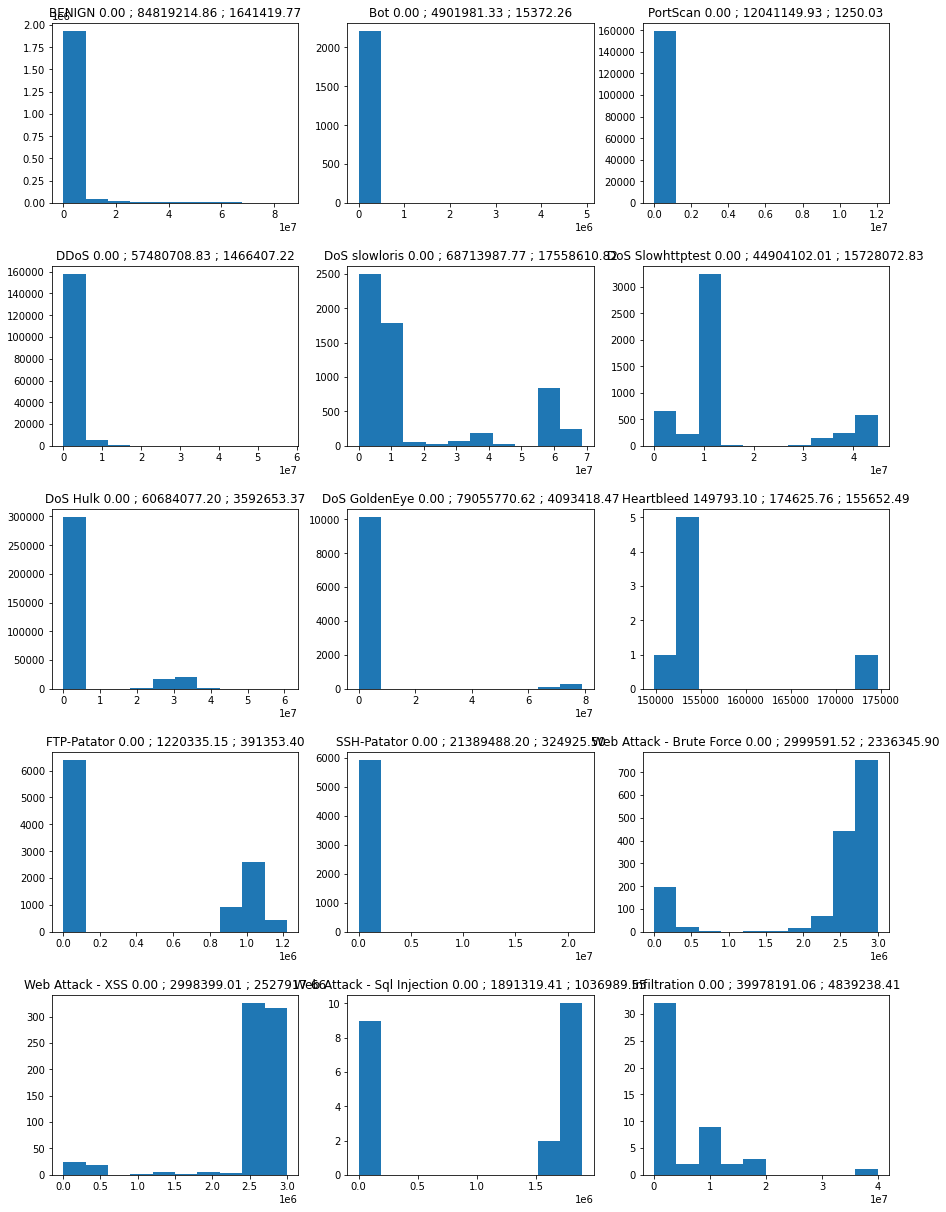

++++++++++++++++++++++++++++++++++++++++++++++++++
Flow IAT Max min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


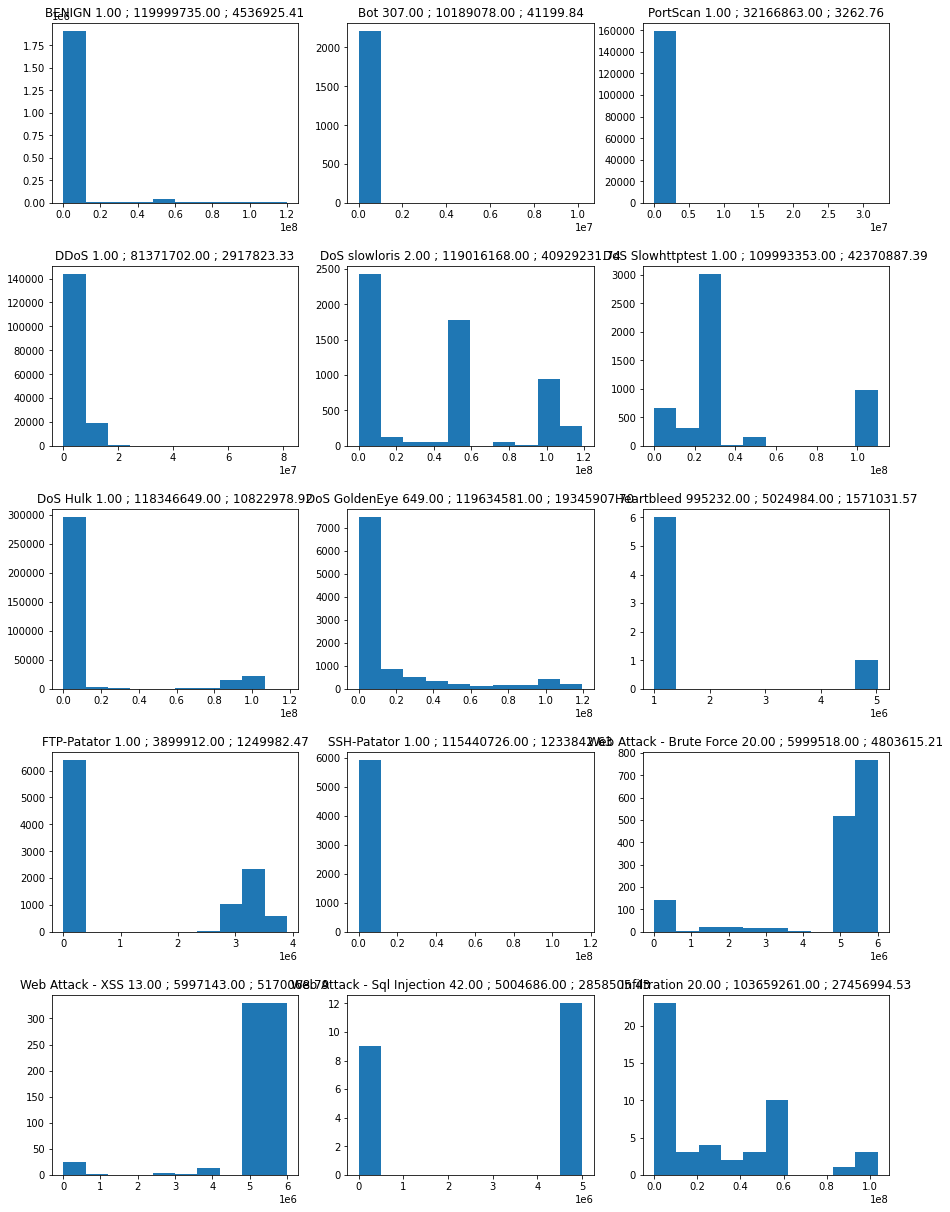

++++++++++++++++++++++++++++++++++++++++++++++++++
Flow IAT Min min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


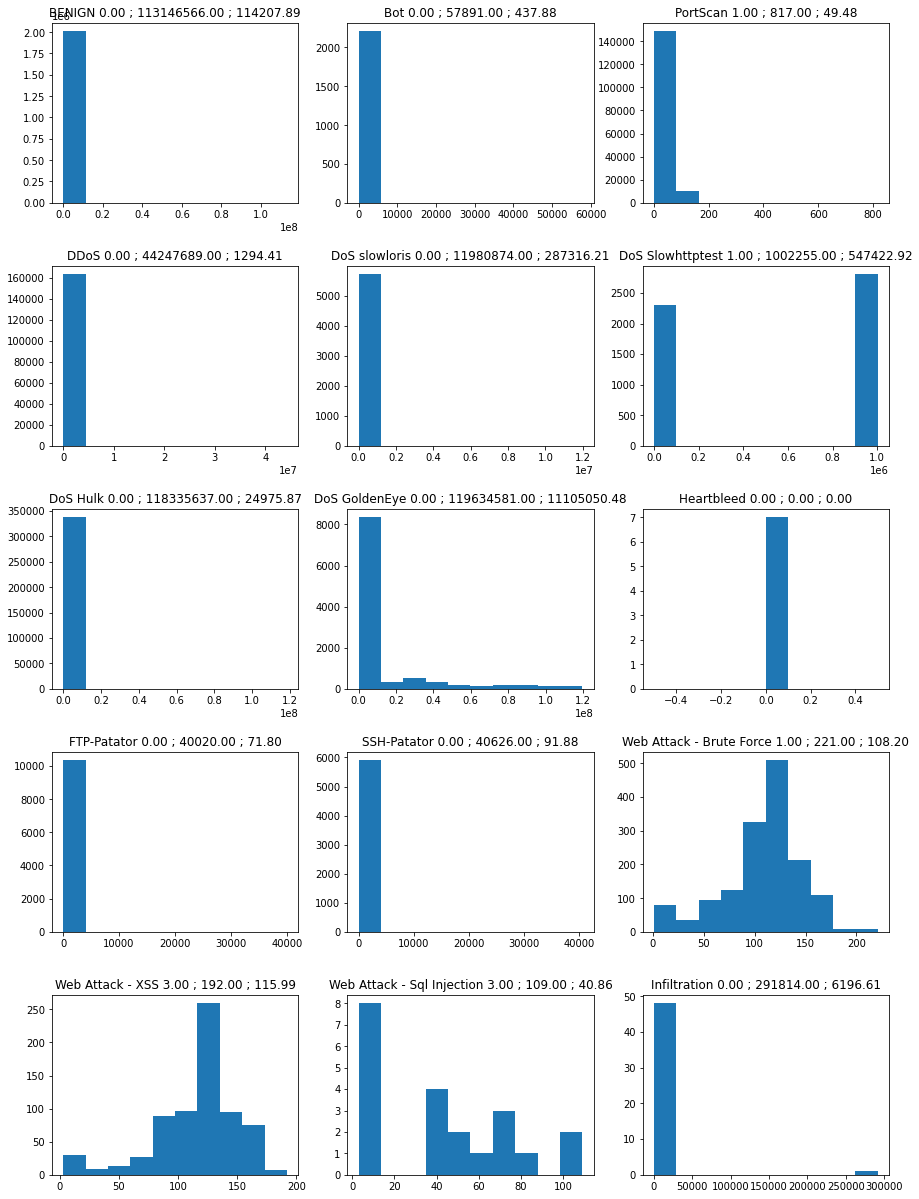

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd IAT Total min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


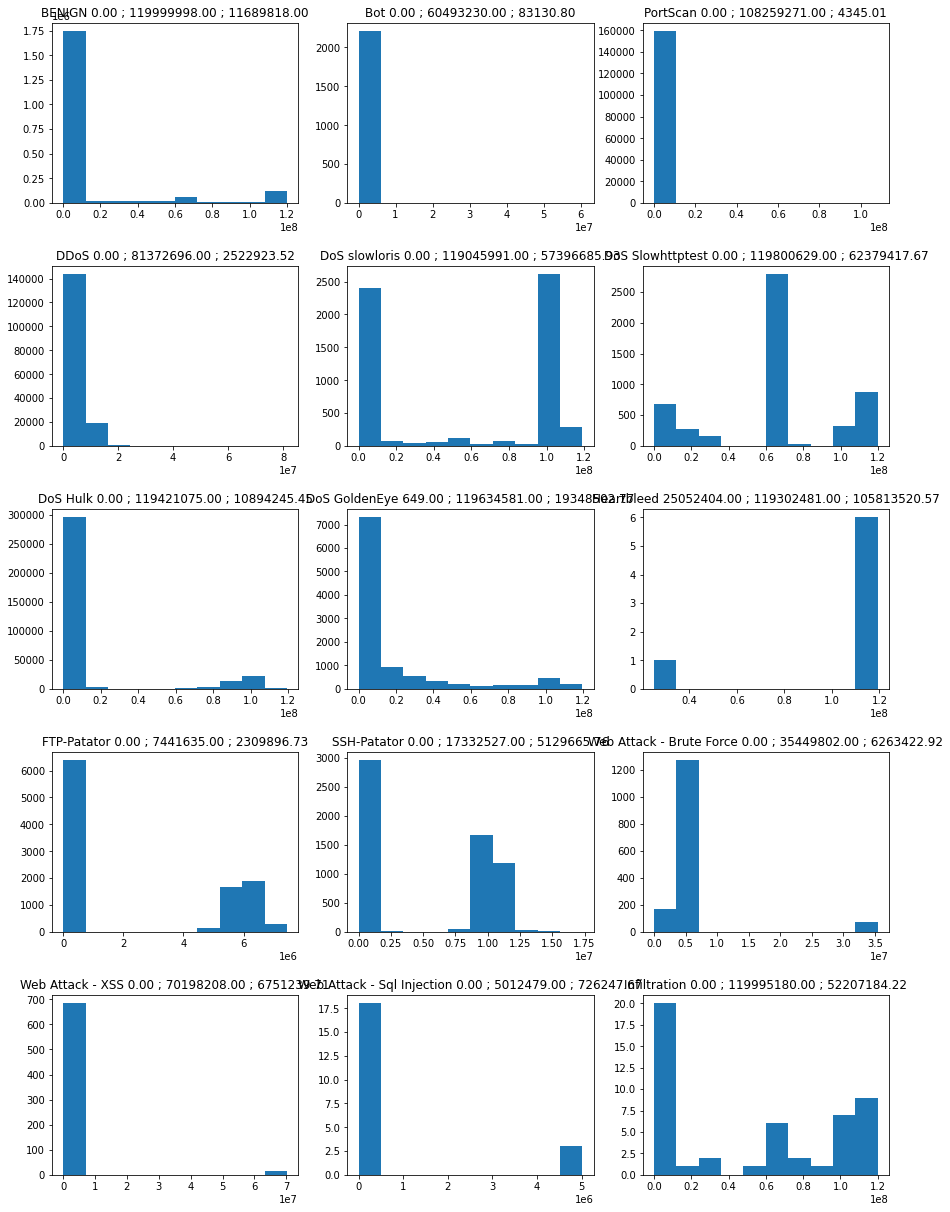

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd IAT Mean min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


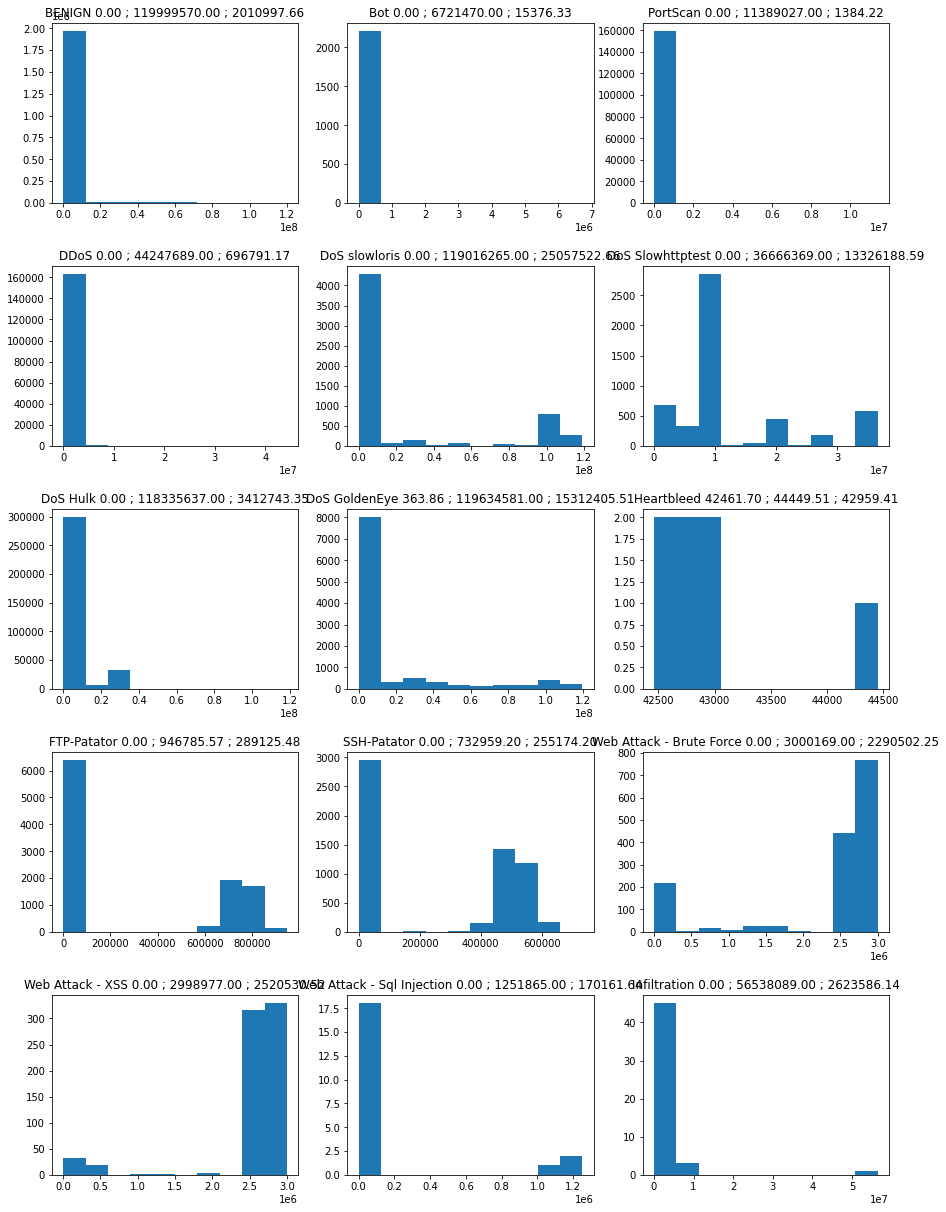

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd IAT Std min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


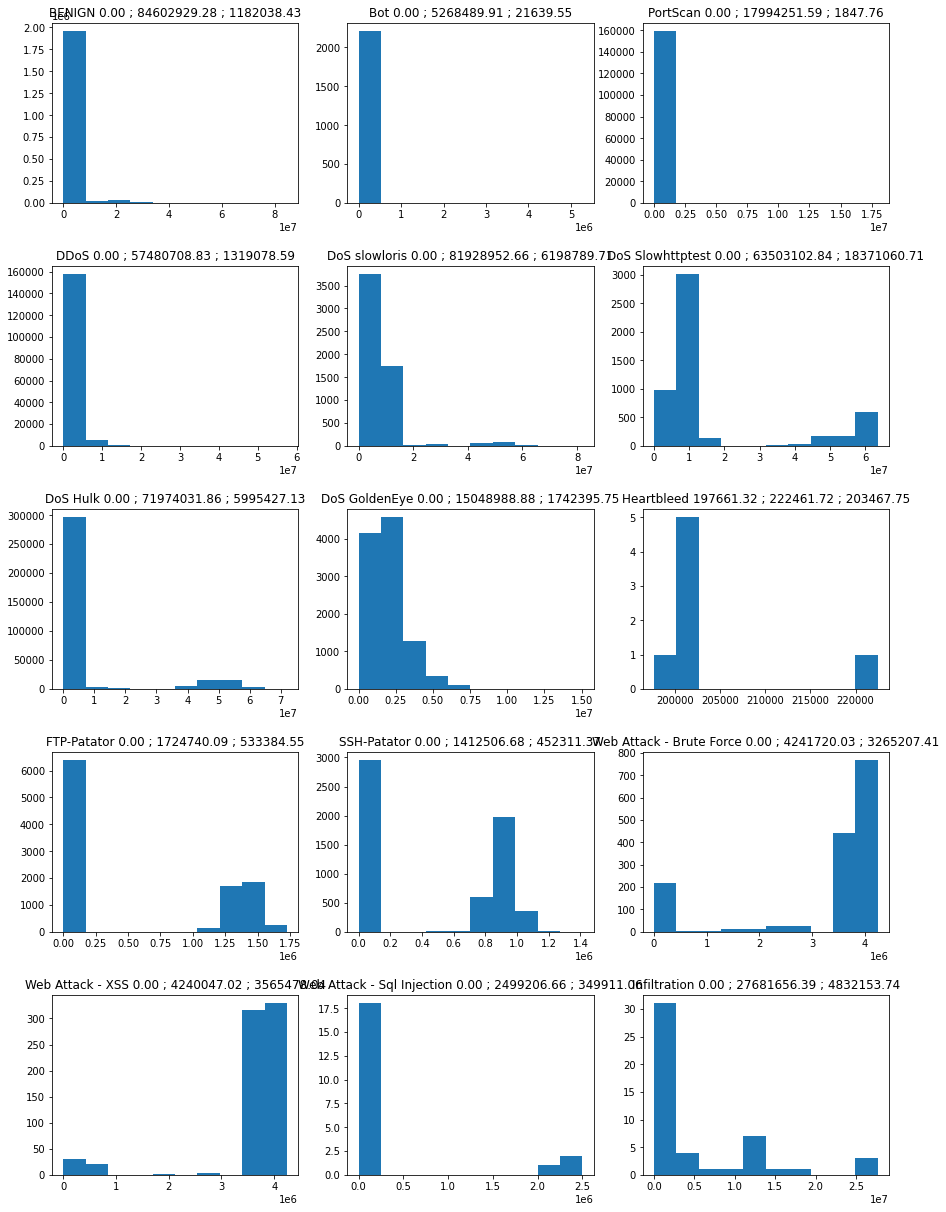

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd IAT Max min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


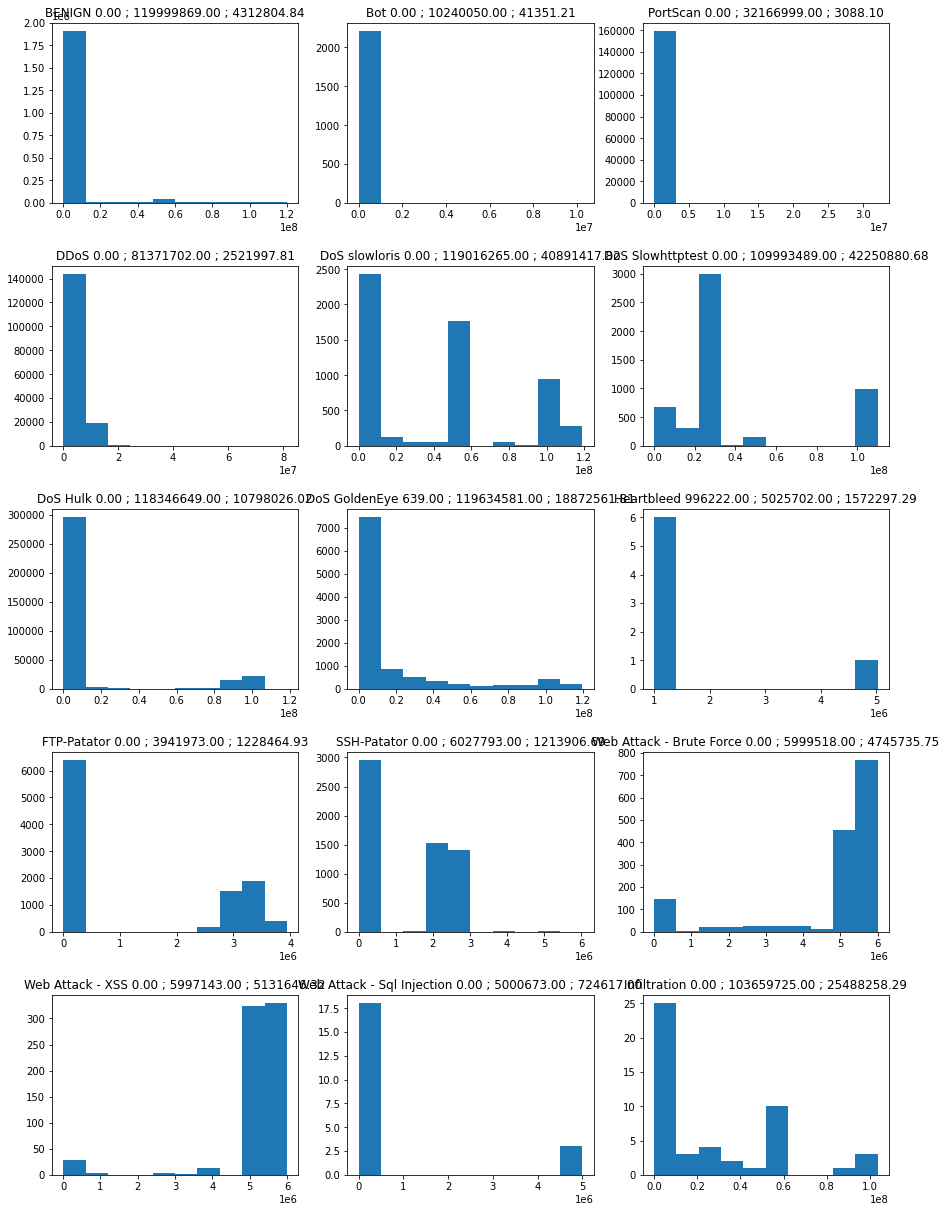

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd IAT Min min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


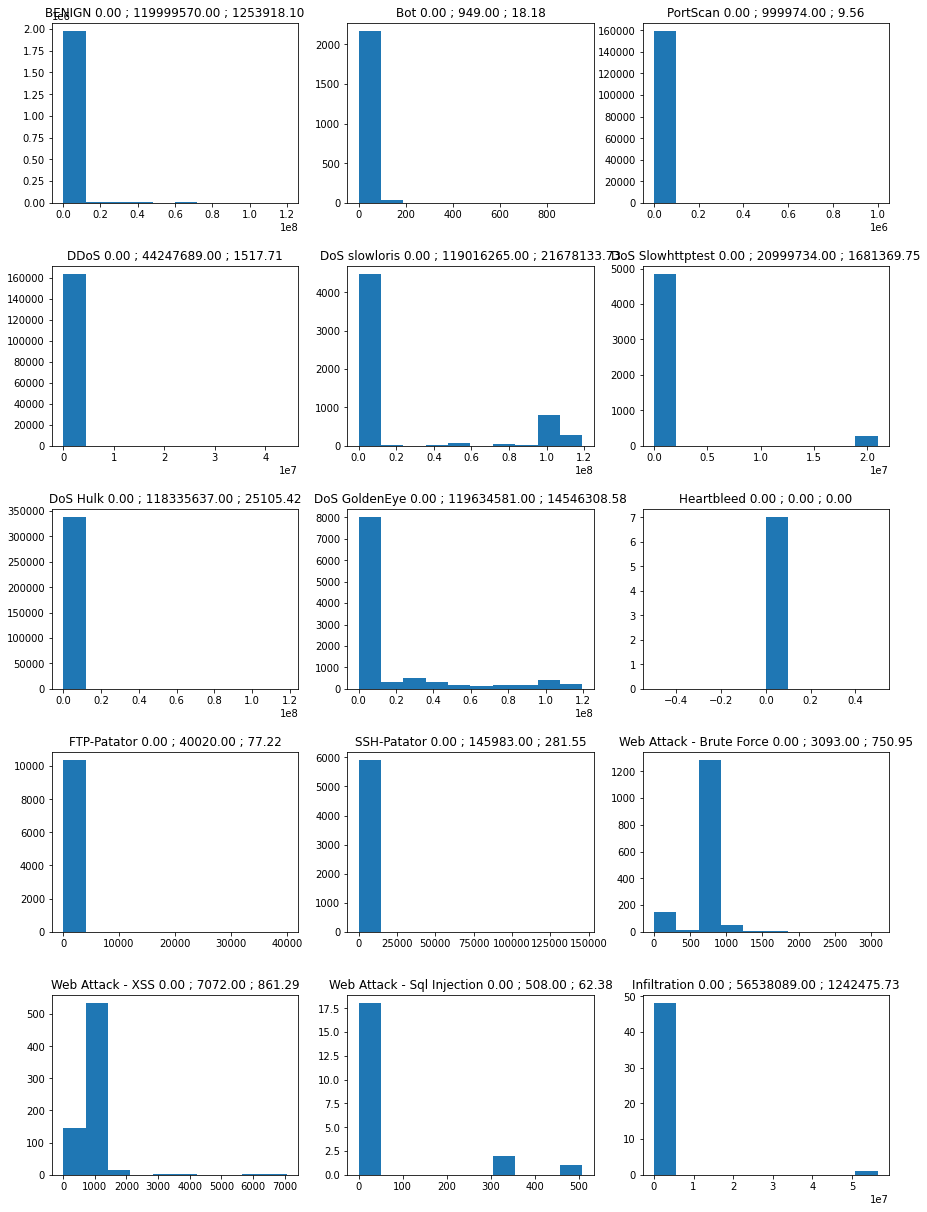

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd IAT Total min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


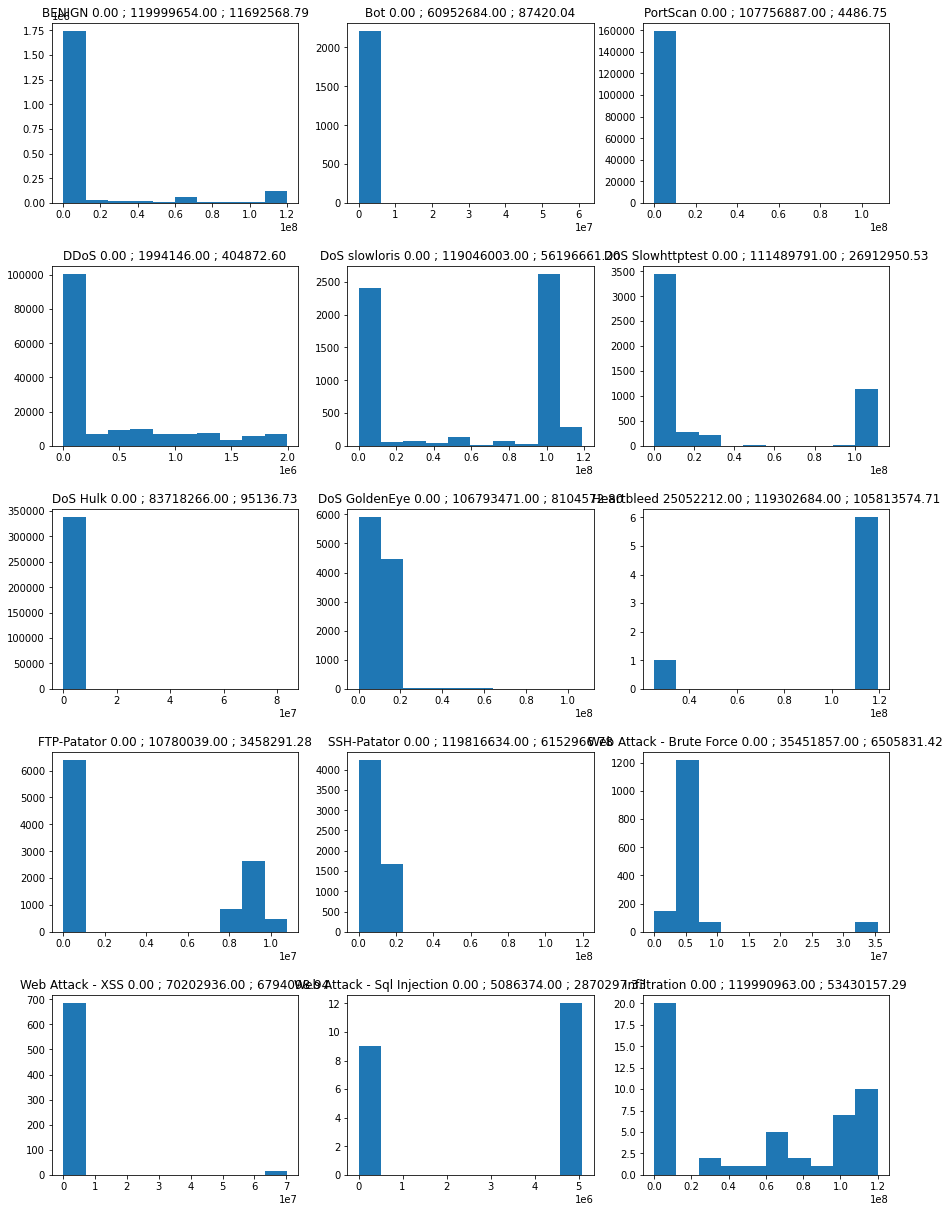

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd IAT Mean min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


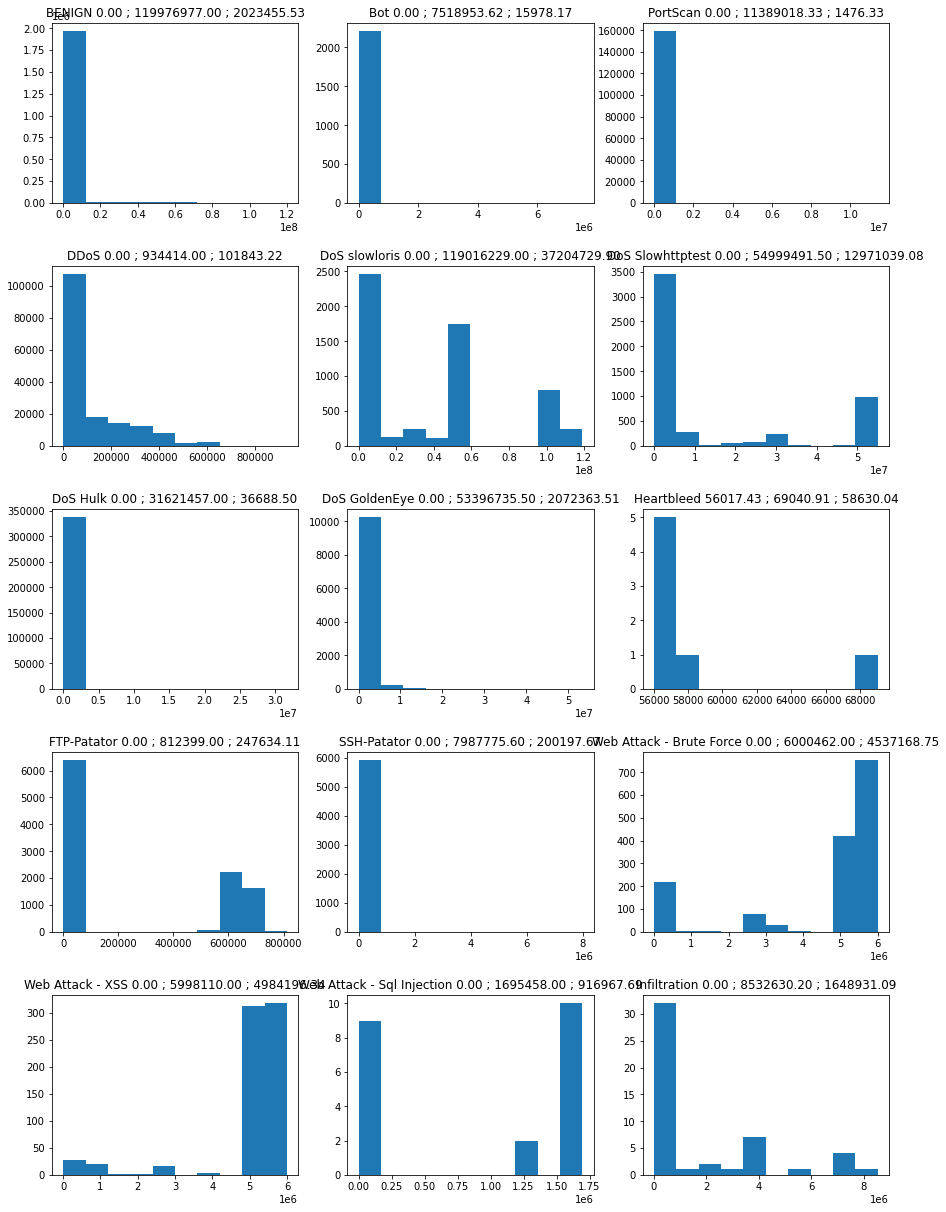

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd IAT Std min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


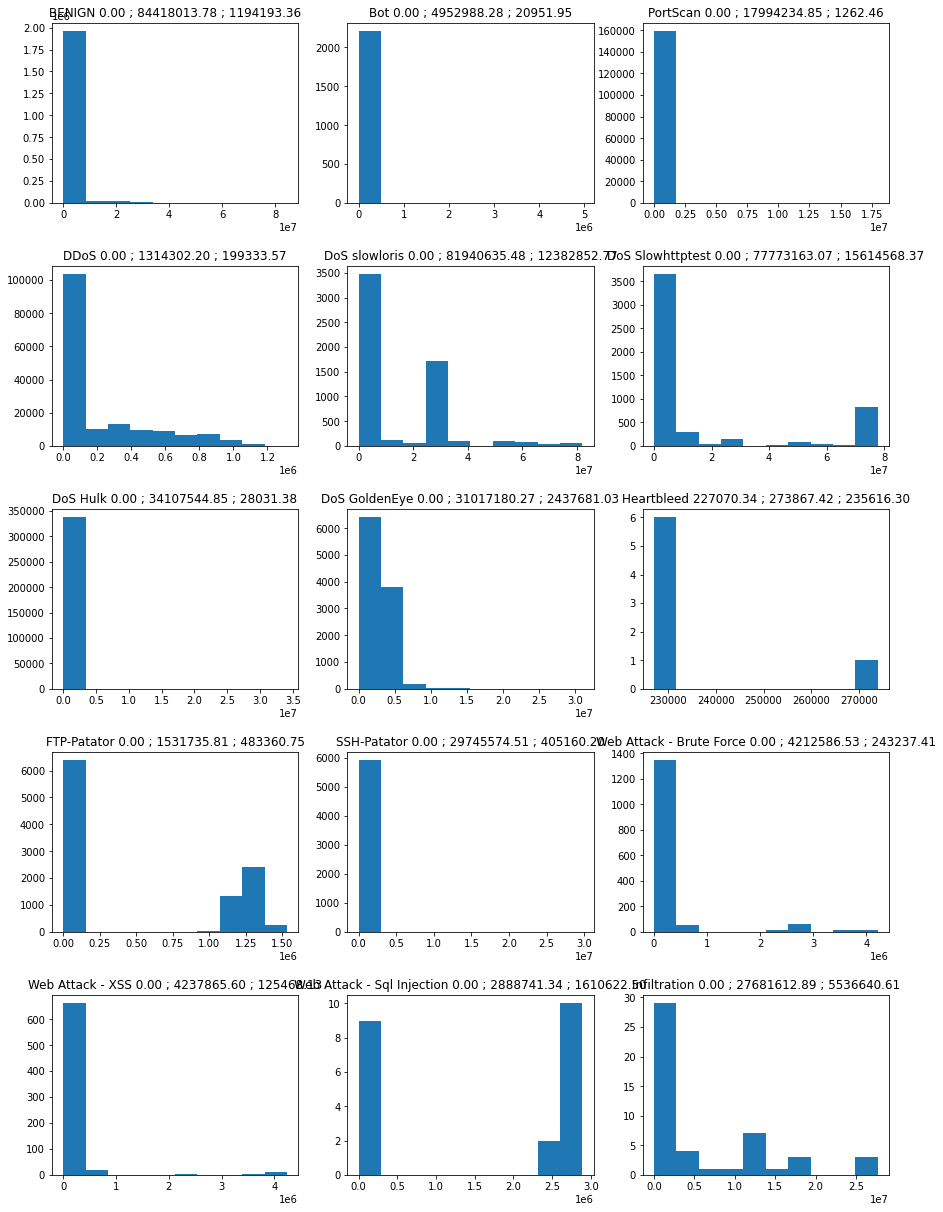

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd IAT Max min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


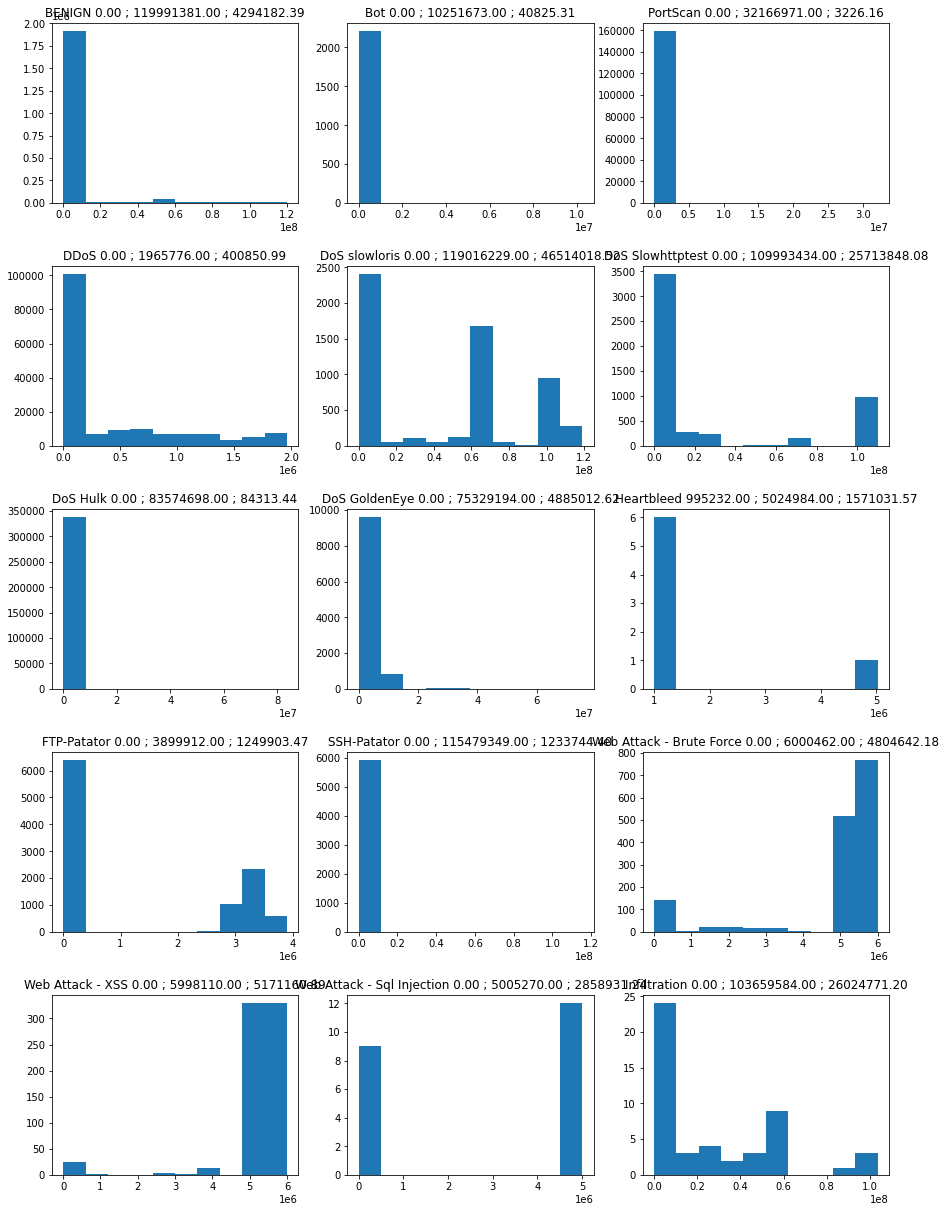

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd IAT Min min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


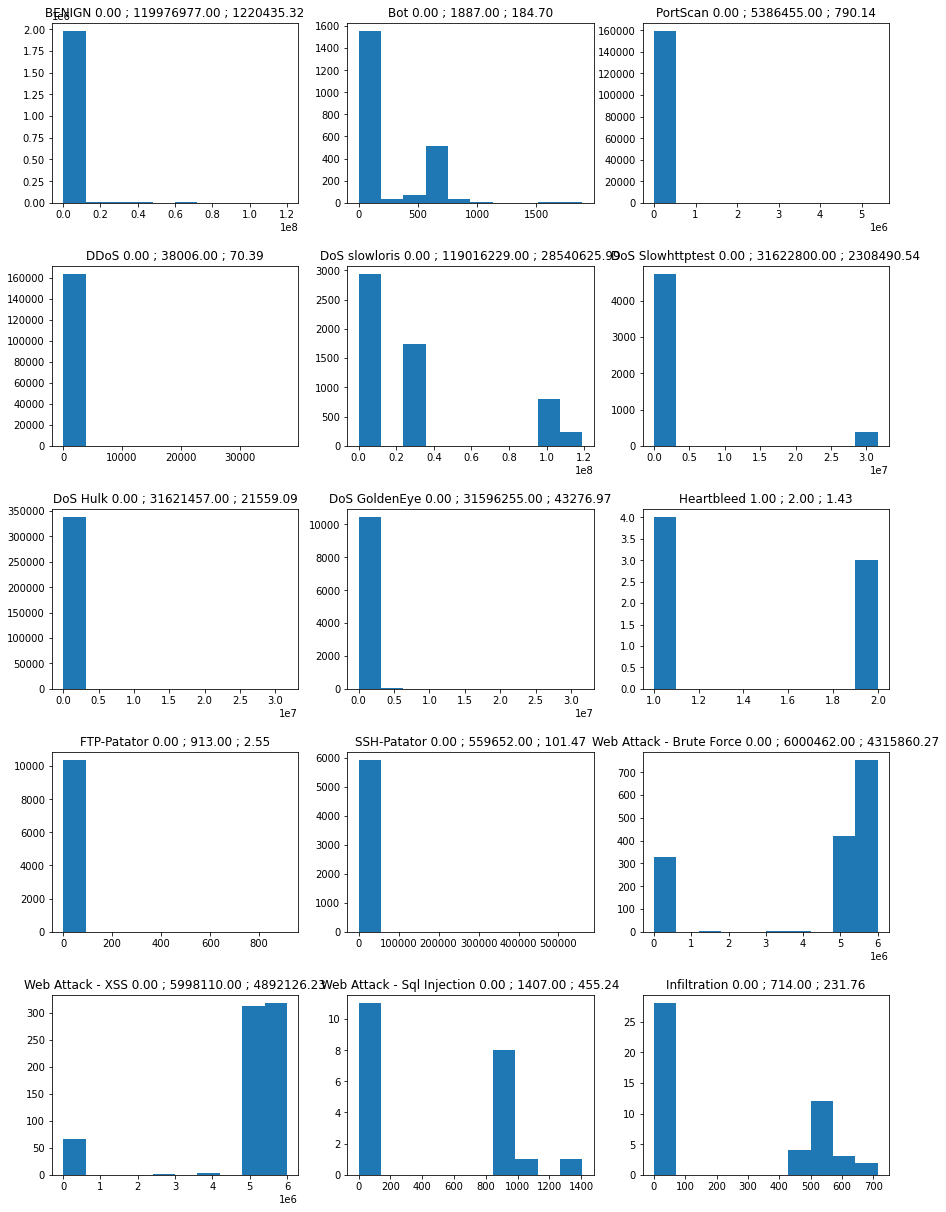

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd PSH Flags min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


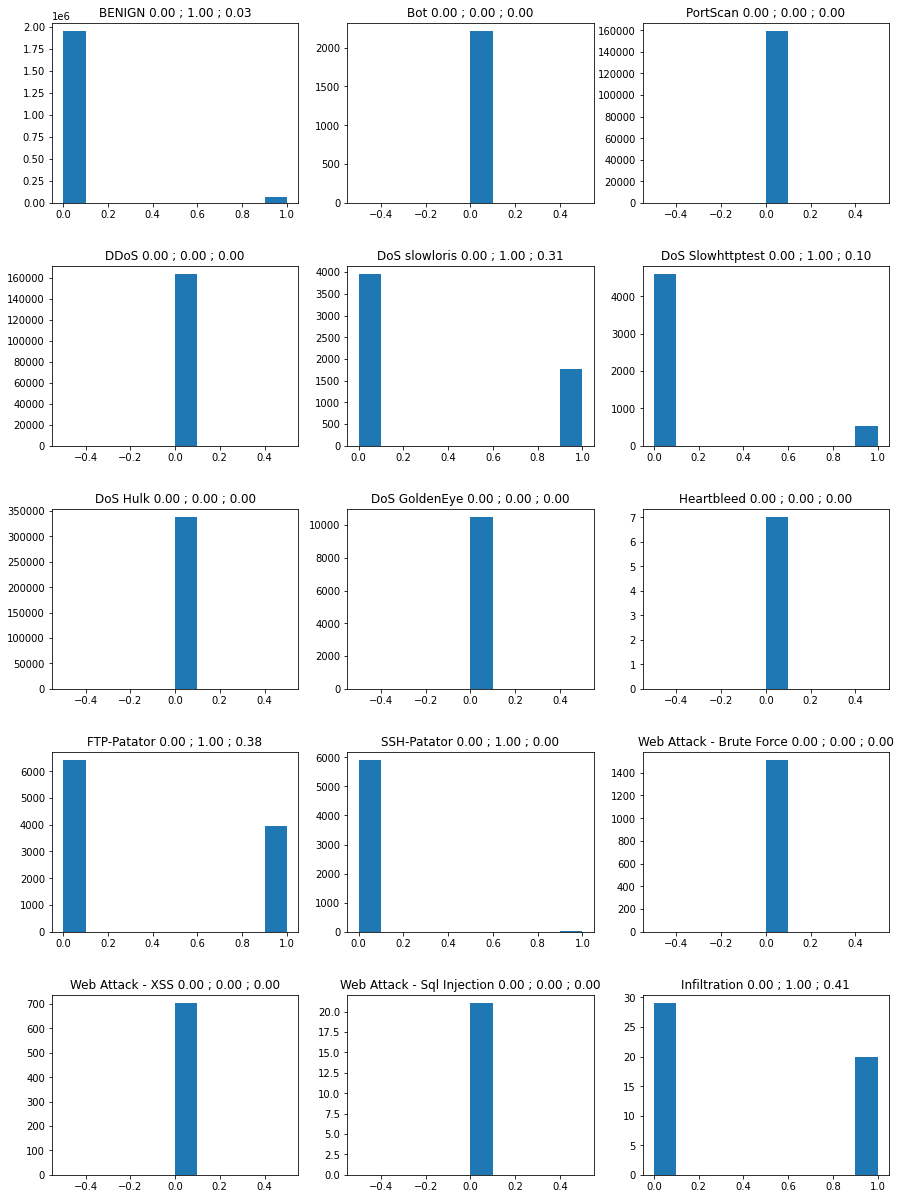

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd URG Flags min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


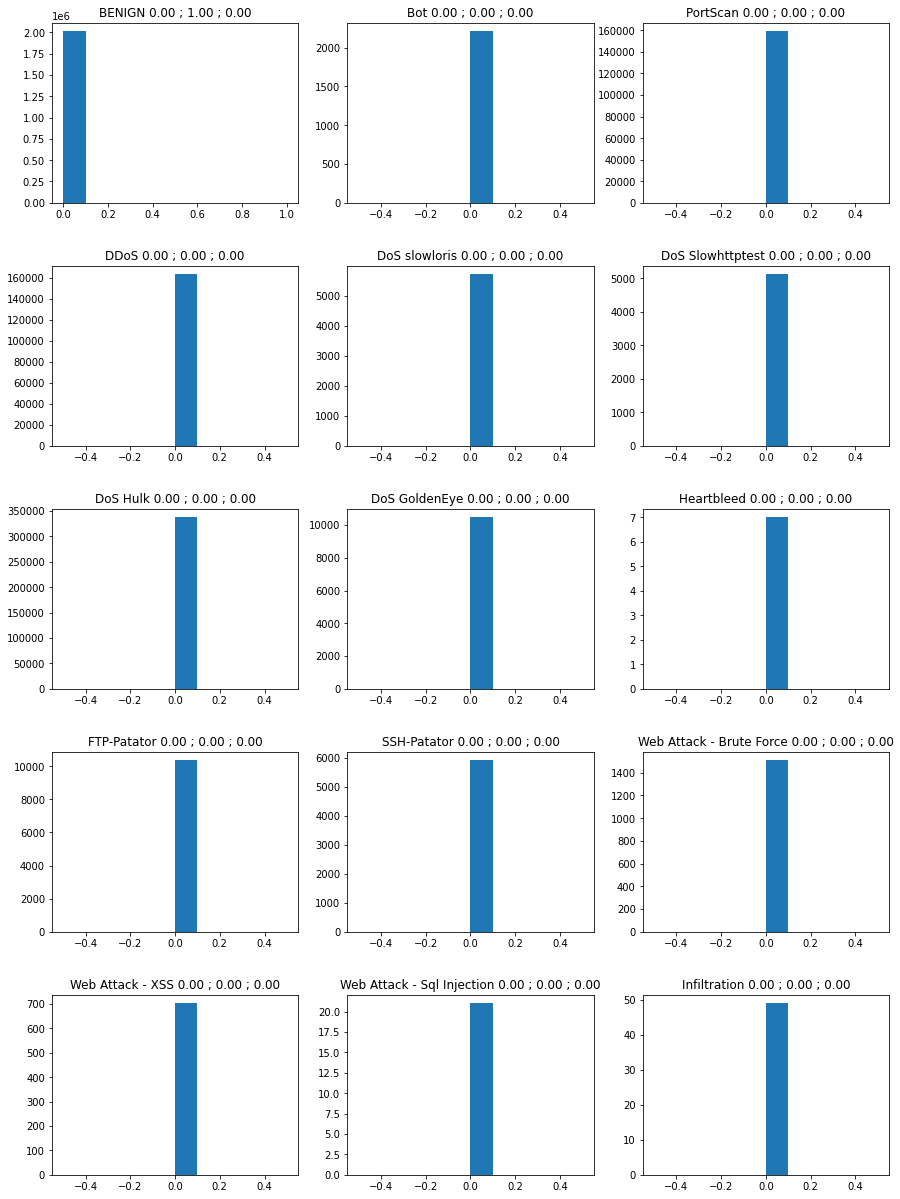

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd Header Length min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


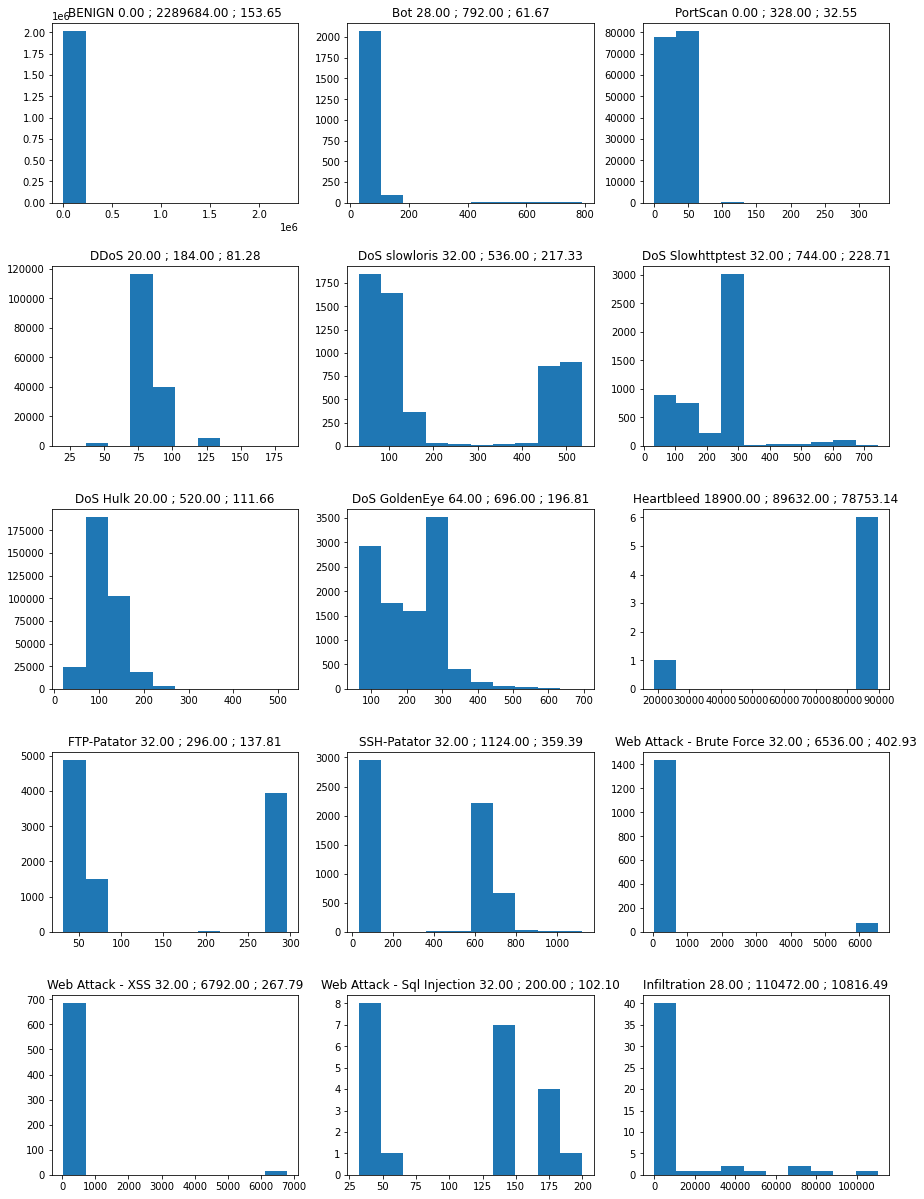

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd Header Length min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


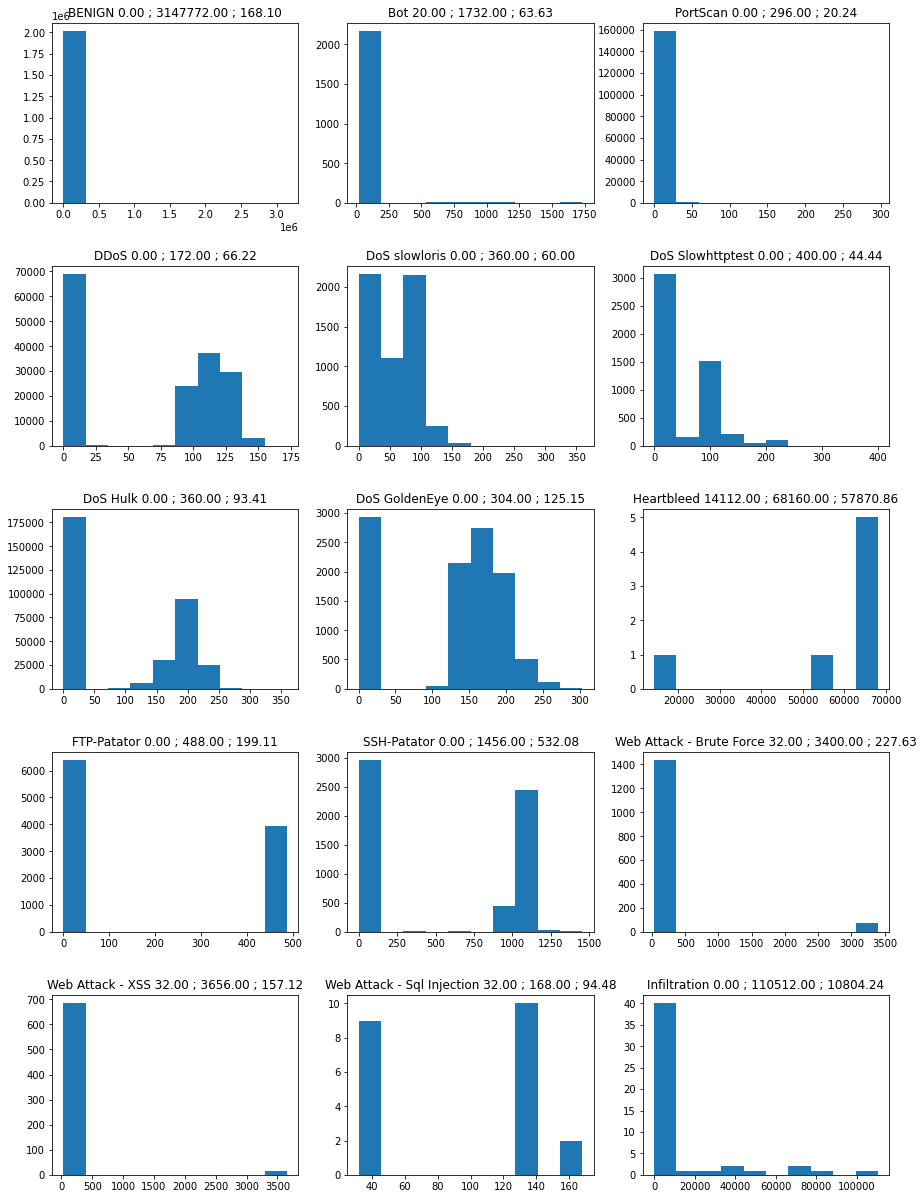

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd Packets/s min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


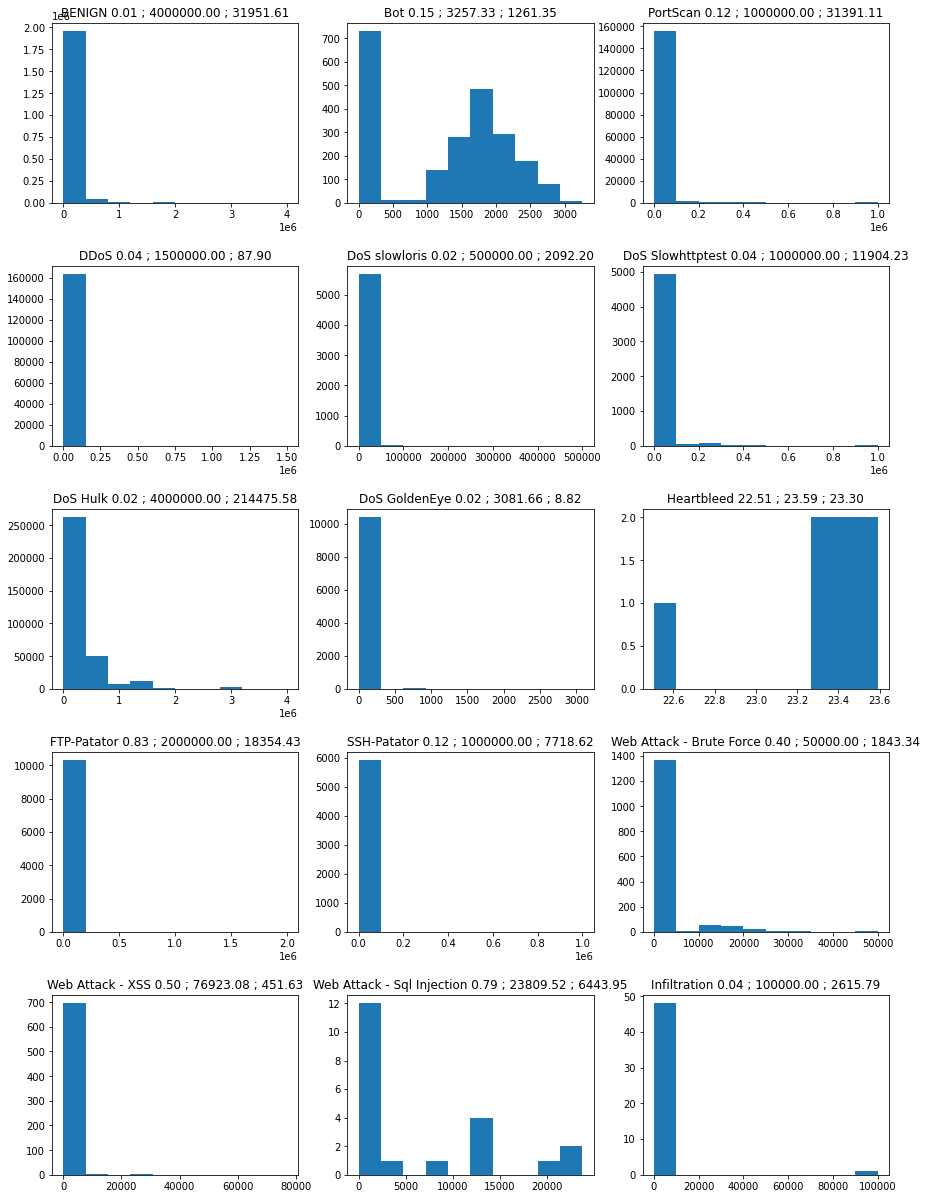

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd Packets/s min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


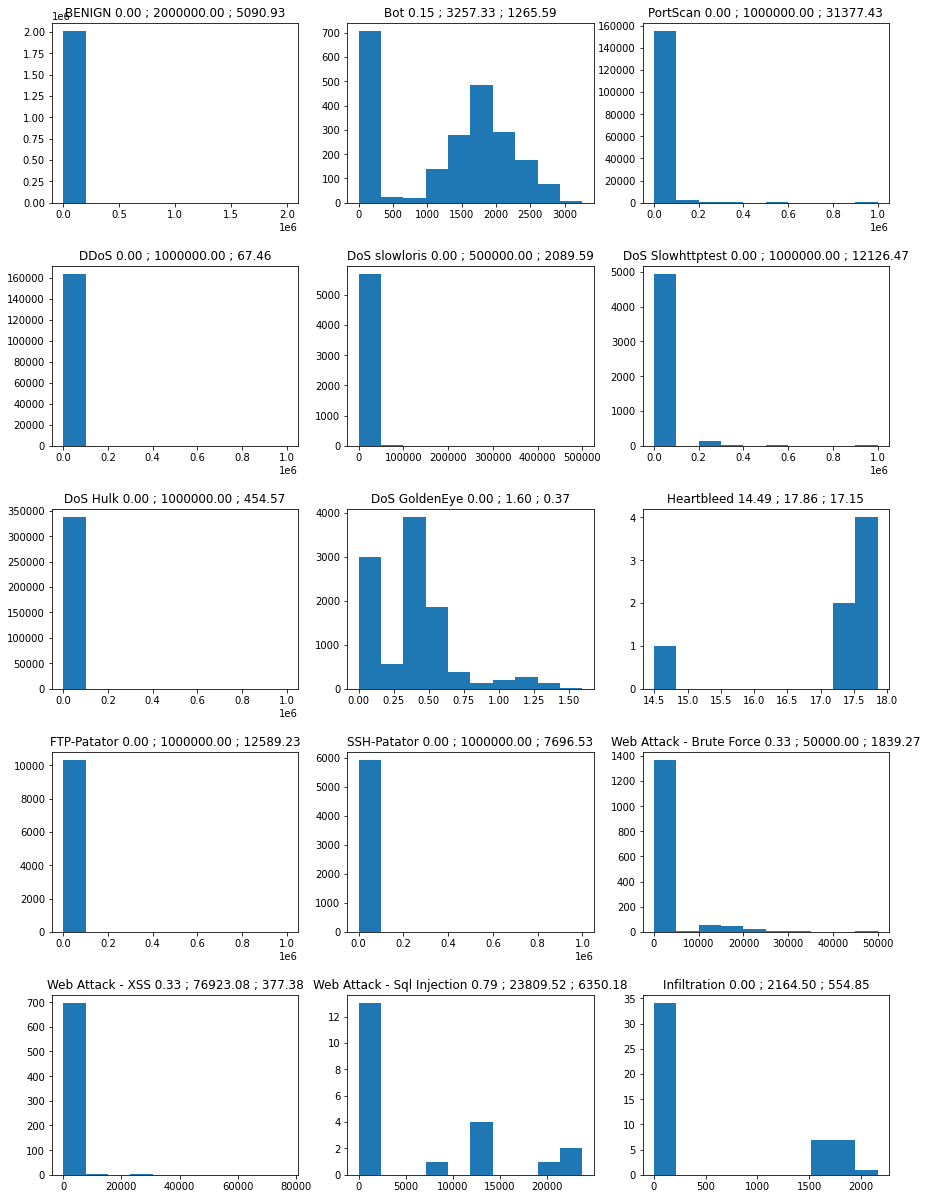

++++++++++++++++++++++++++++++++++++++++++++++++++
Packet Length Min min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


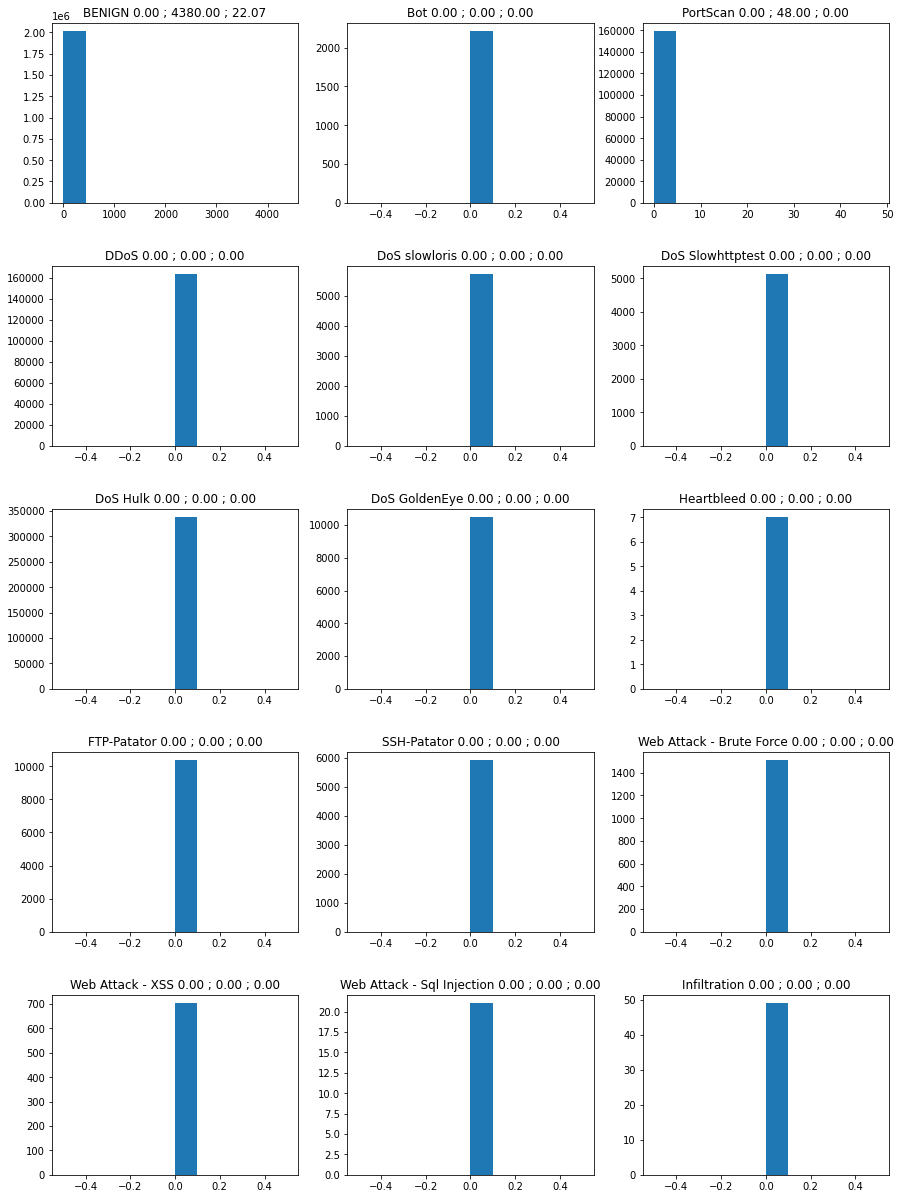

++++++++++++++++++++++++++++++++++++++++++++++++++
Packet Length Max min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


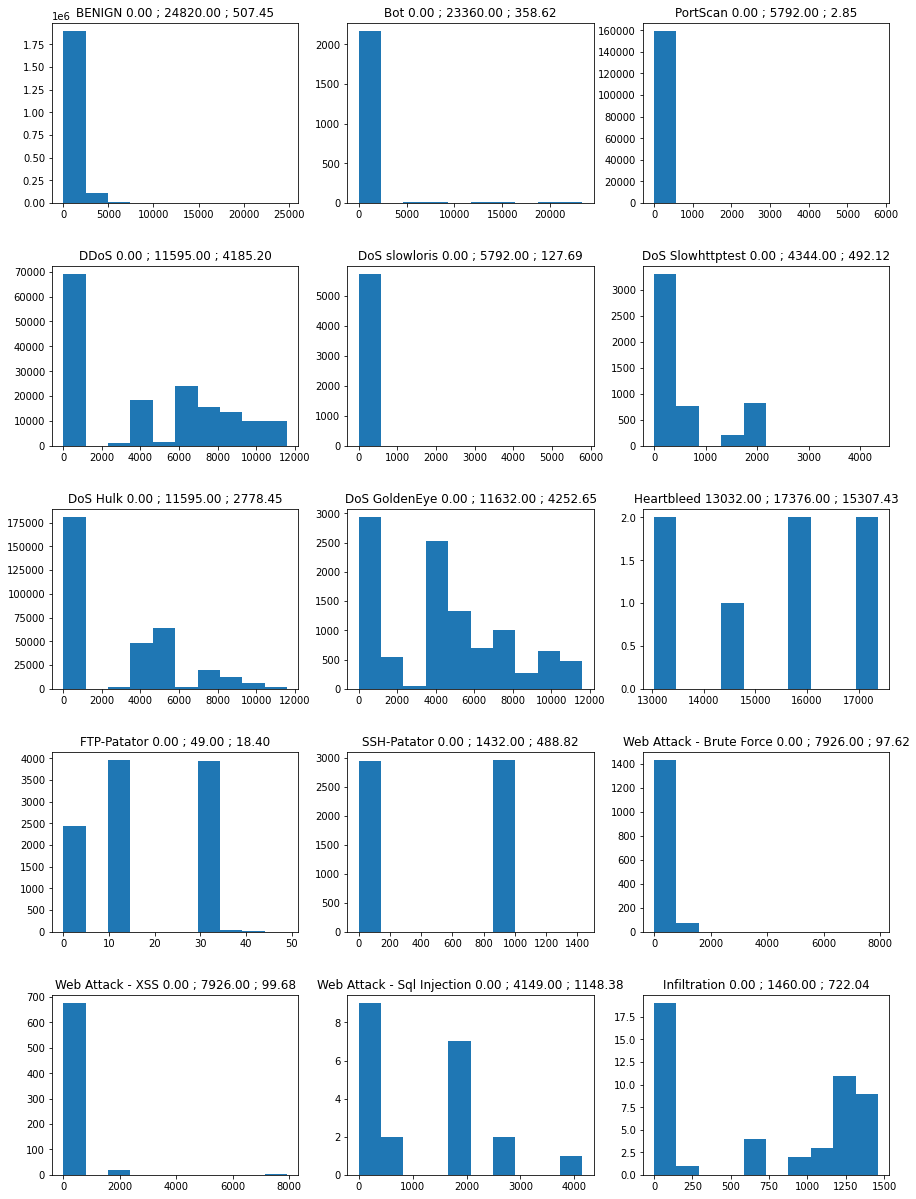

++++++++++++++++++++++++++++++++++++++++++++++++++
Packet Length Mean min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


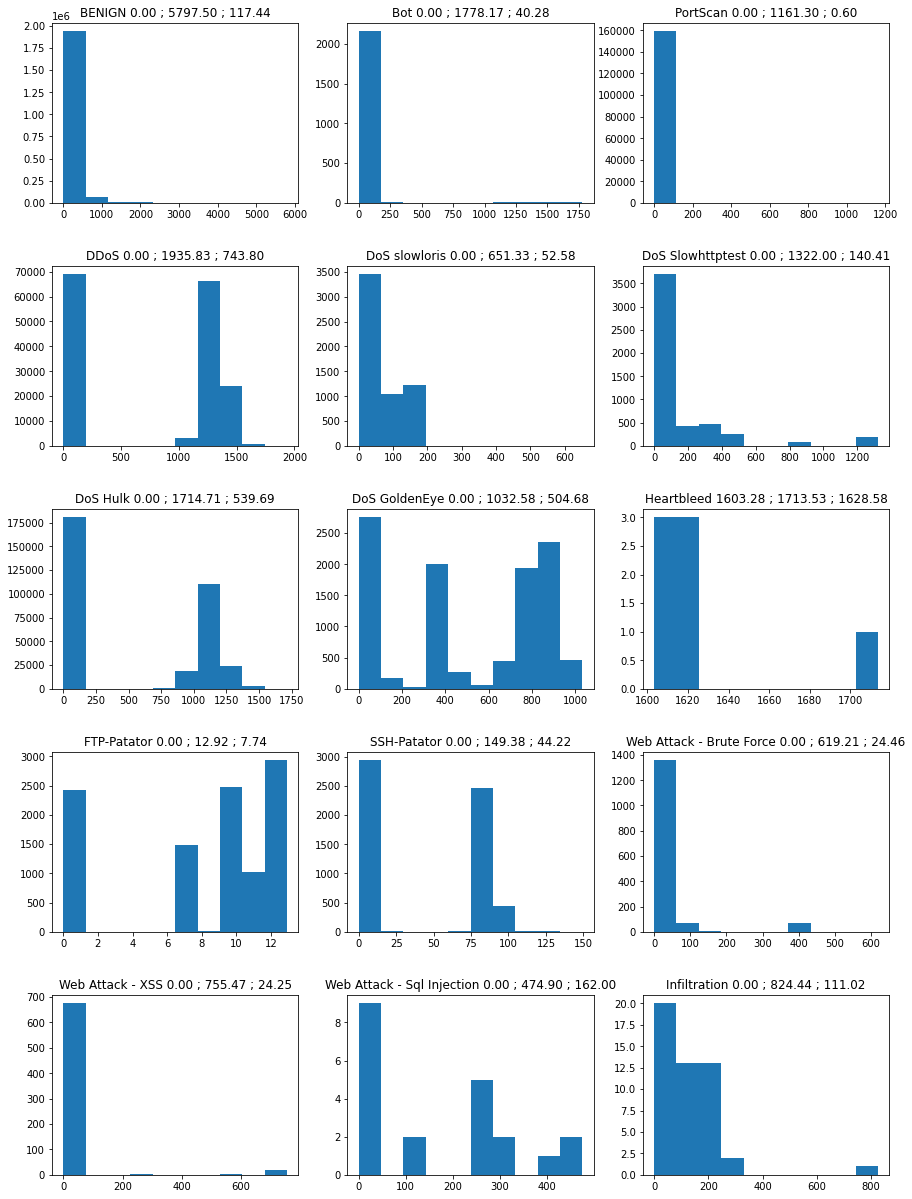

++++++++++++++++++++++++++++++++++++++++++++++++++
Packet Length Std min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


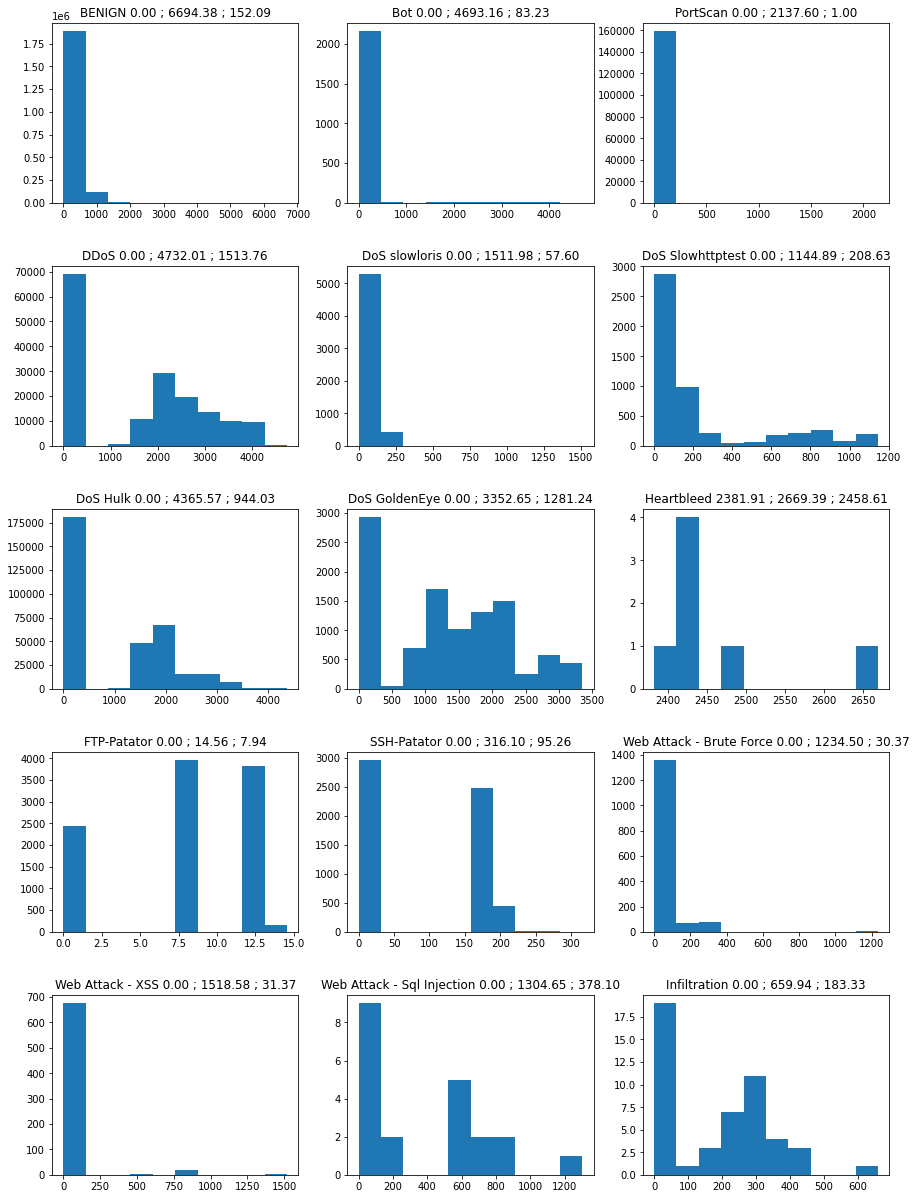

++++++++++++++++++++++++++++++++++++++++++++++++++
Packet Length Variance min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


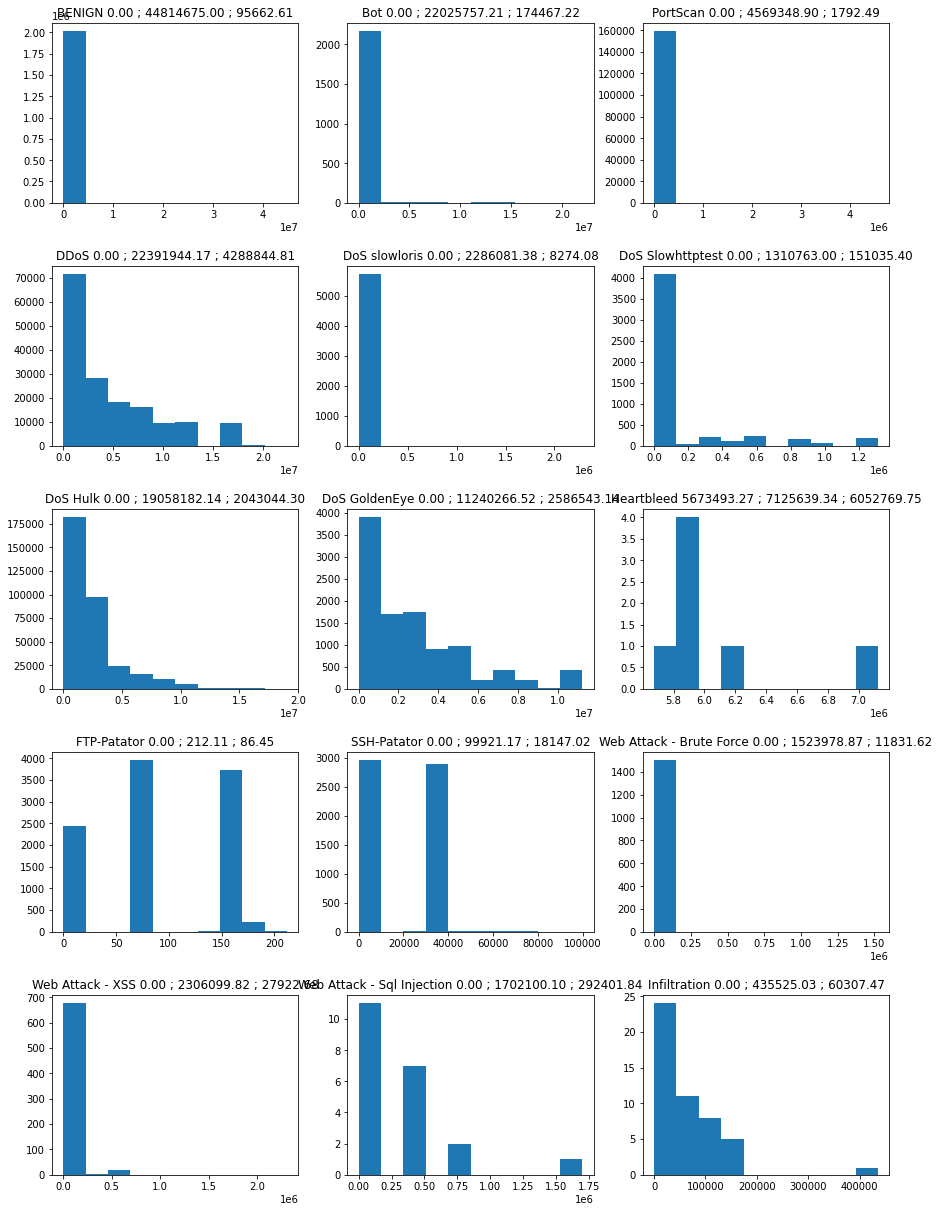

++++++++++++++++++++++++++++++++++++++++++++++++++
FIN Flag Count min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


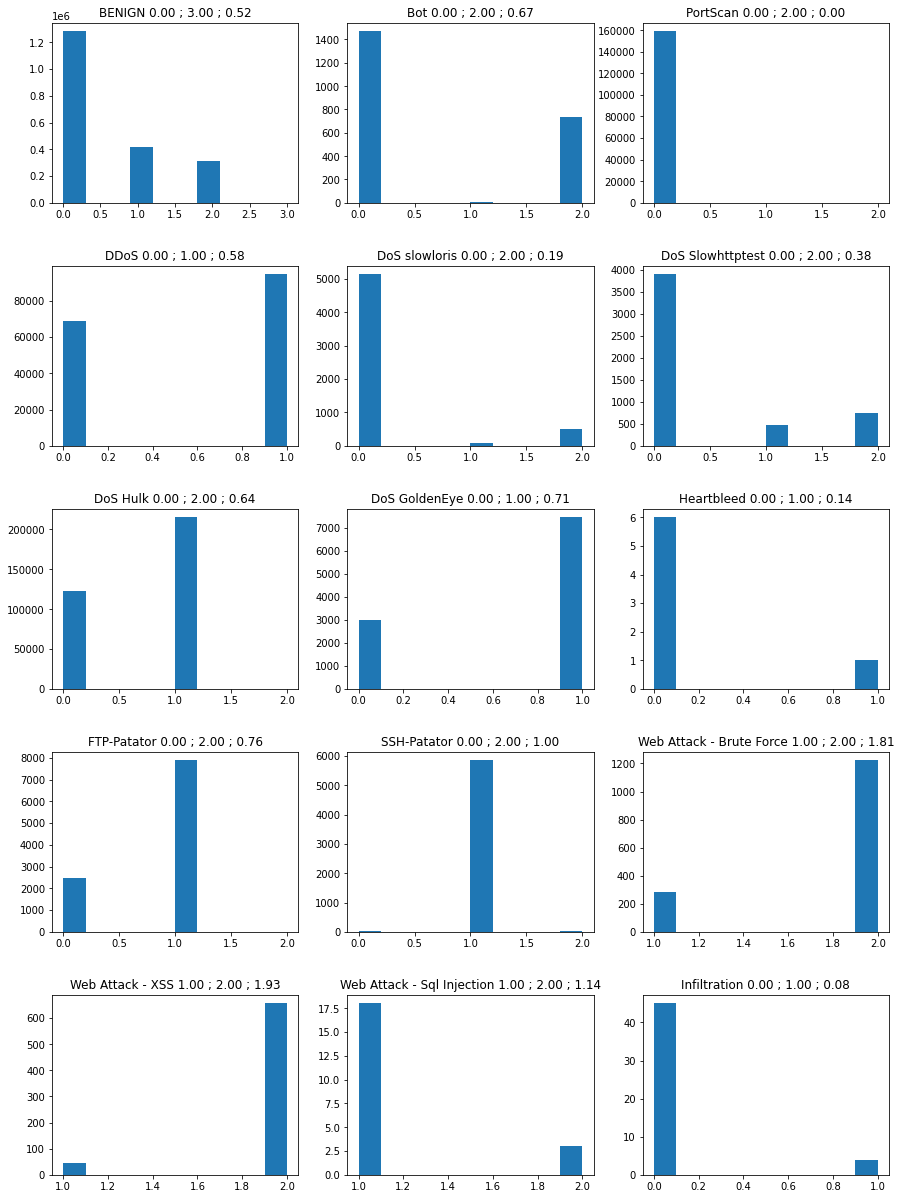

++++++++++++++++++++++++++++++++++++++++++++++++++
SYN Flag Count min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


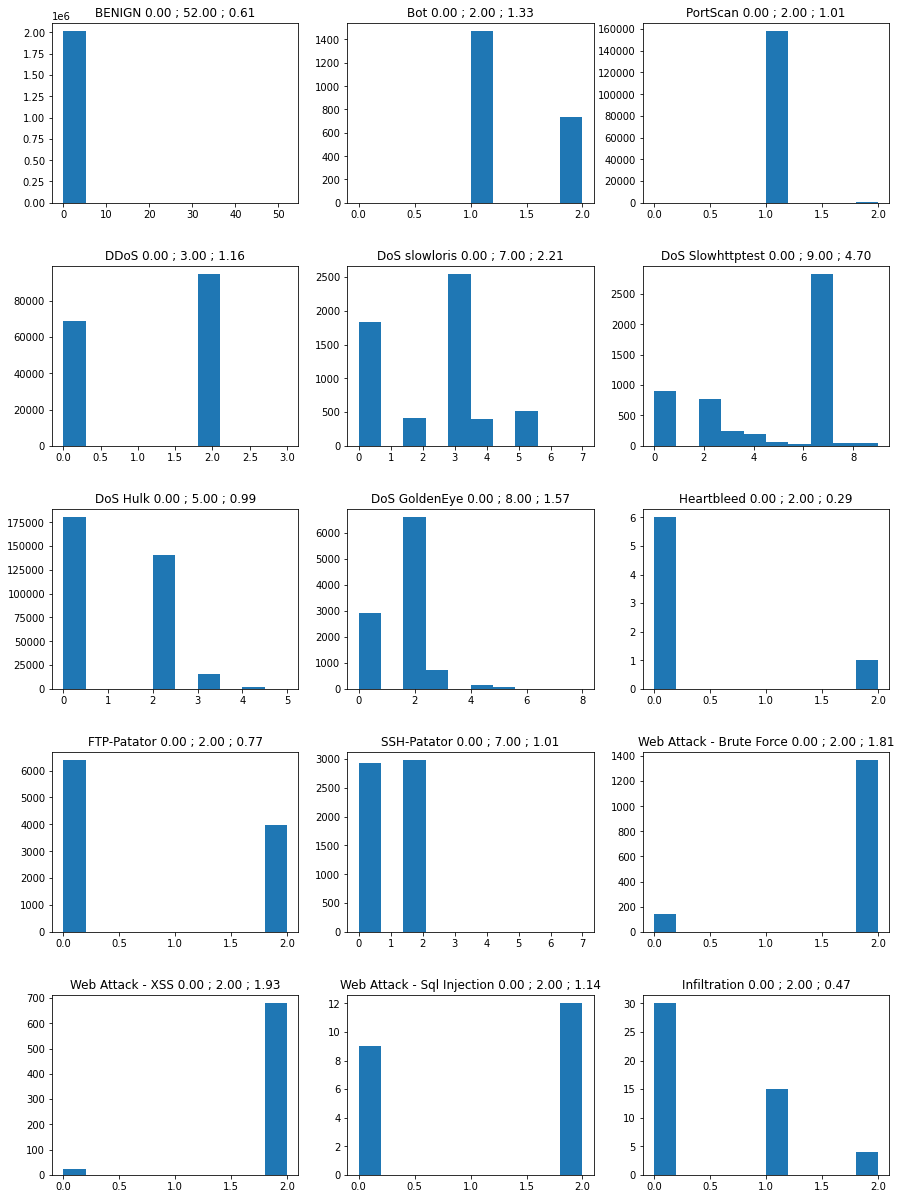

++++++++++++++++++++++++++++++++++++++++++++++++++
RST Flag Count min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


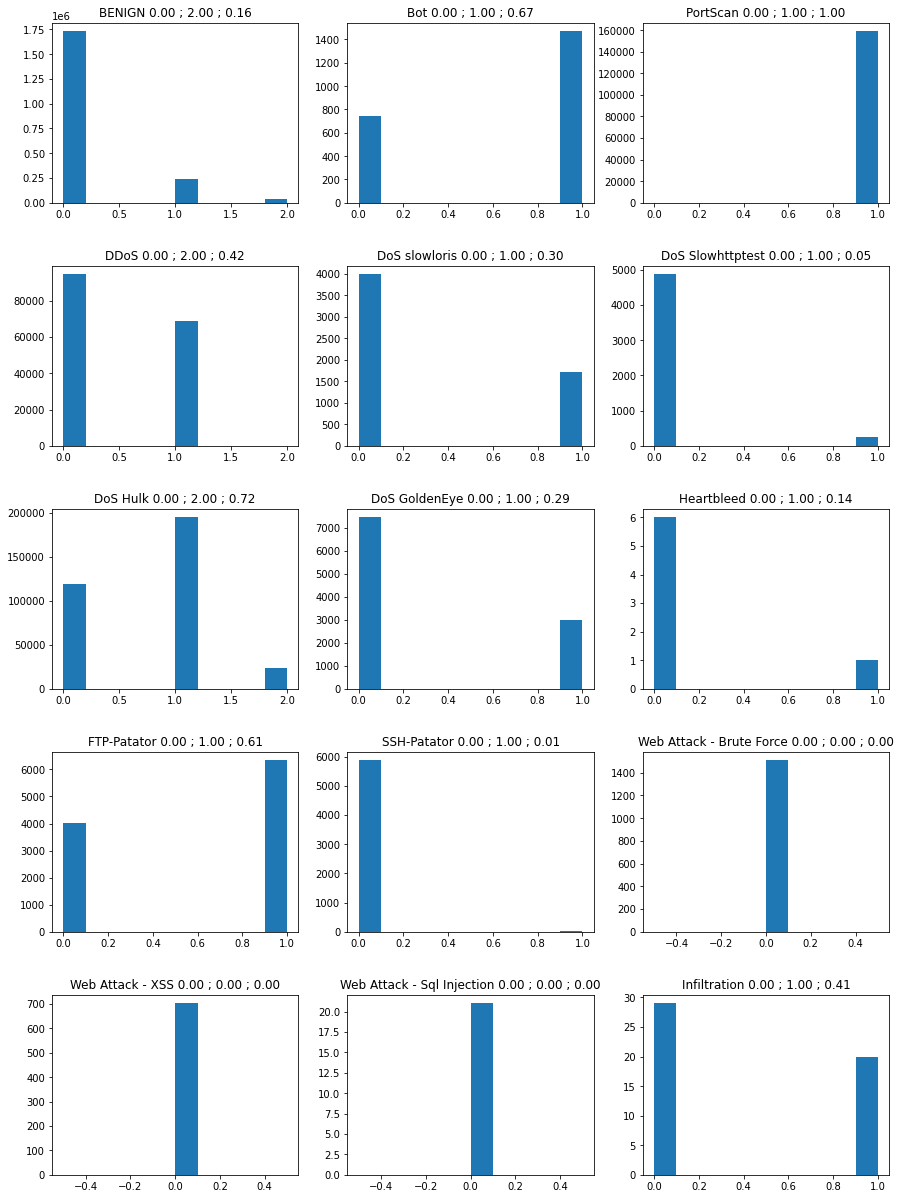

++++++++++++++++++++++++++++++++++++++++++++++++++
PSH Flag Count min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


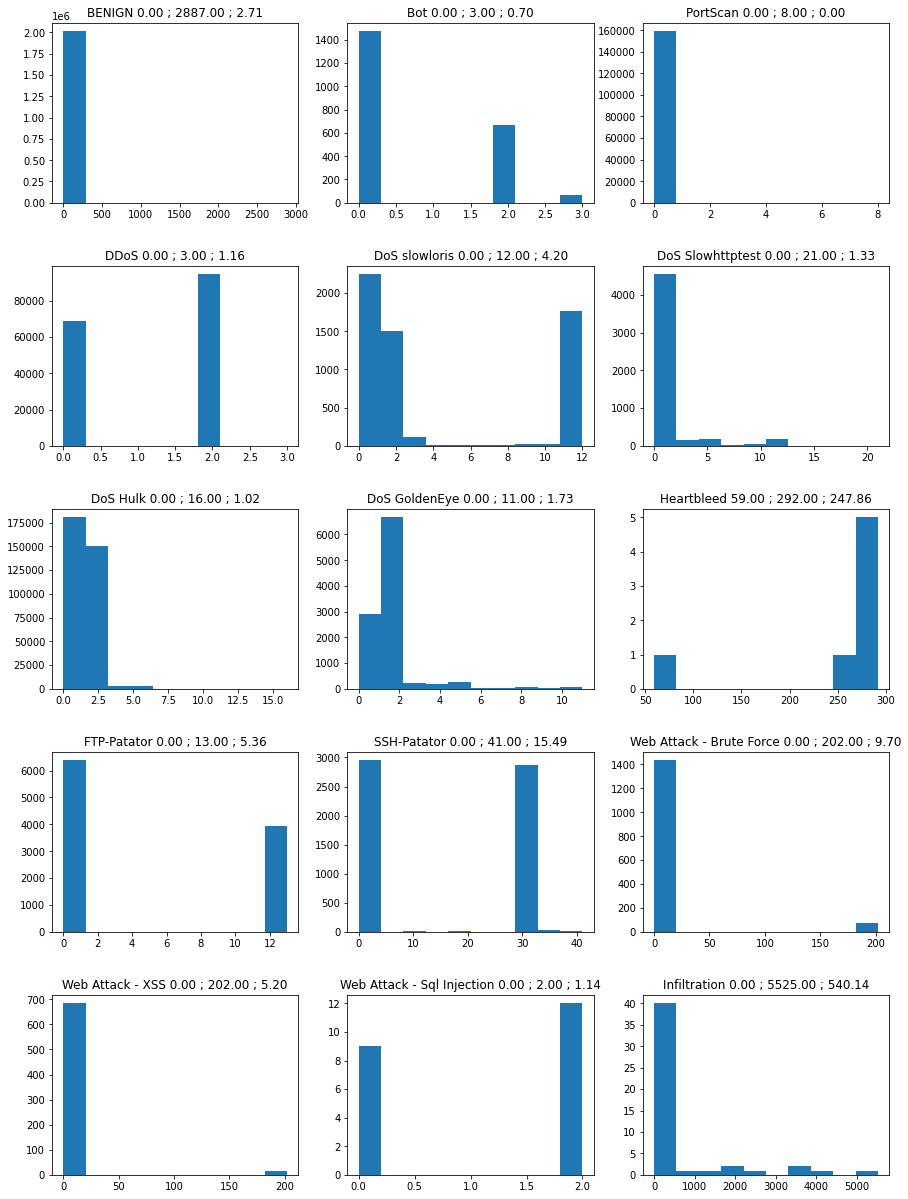

++++++++++++++++++++++++++++++++++++++++++++++++++
ACK Flag Count min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


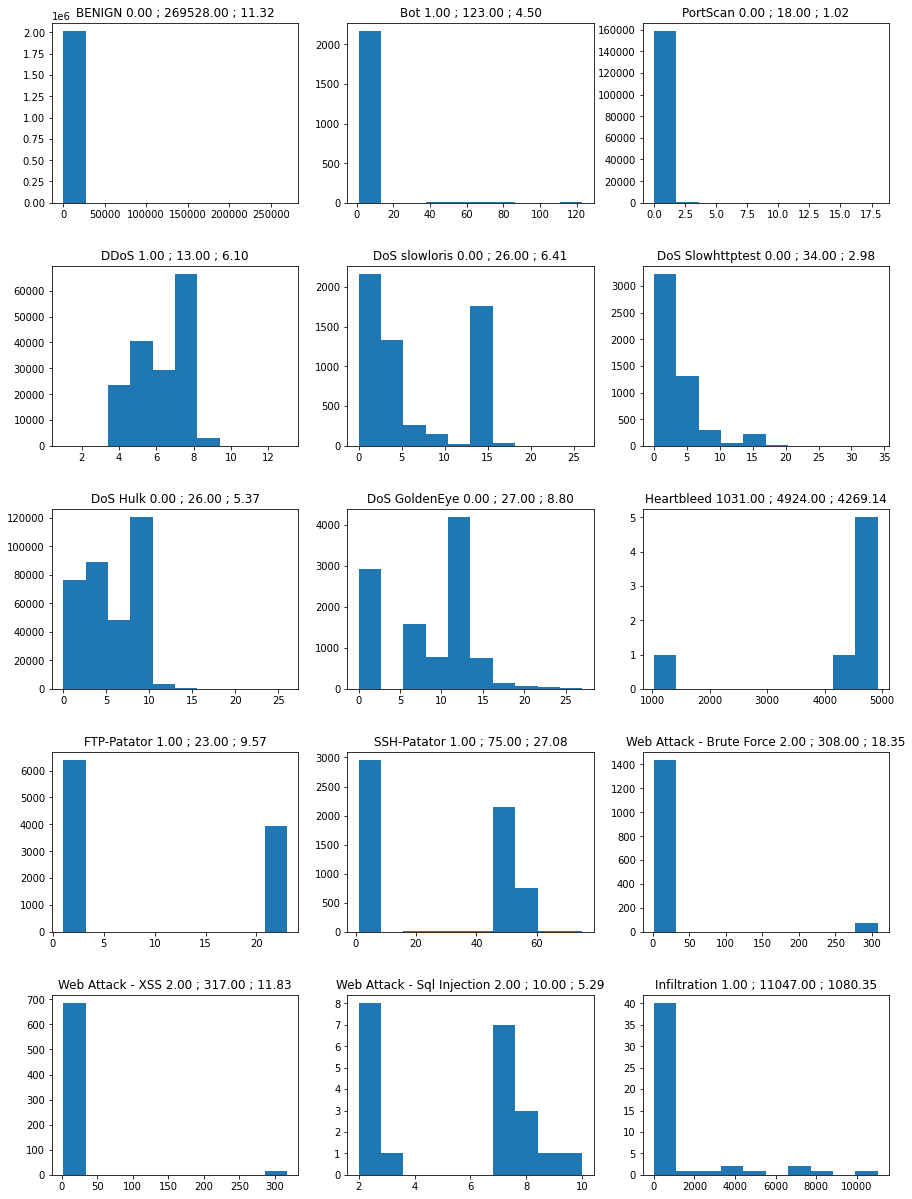

++++++++++++++++++++++++++++++++++++++++++++++++++
URG Flag Count min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


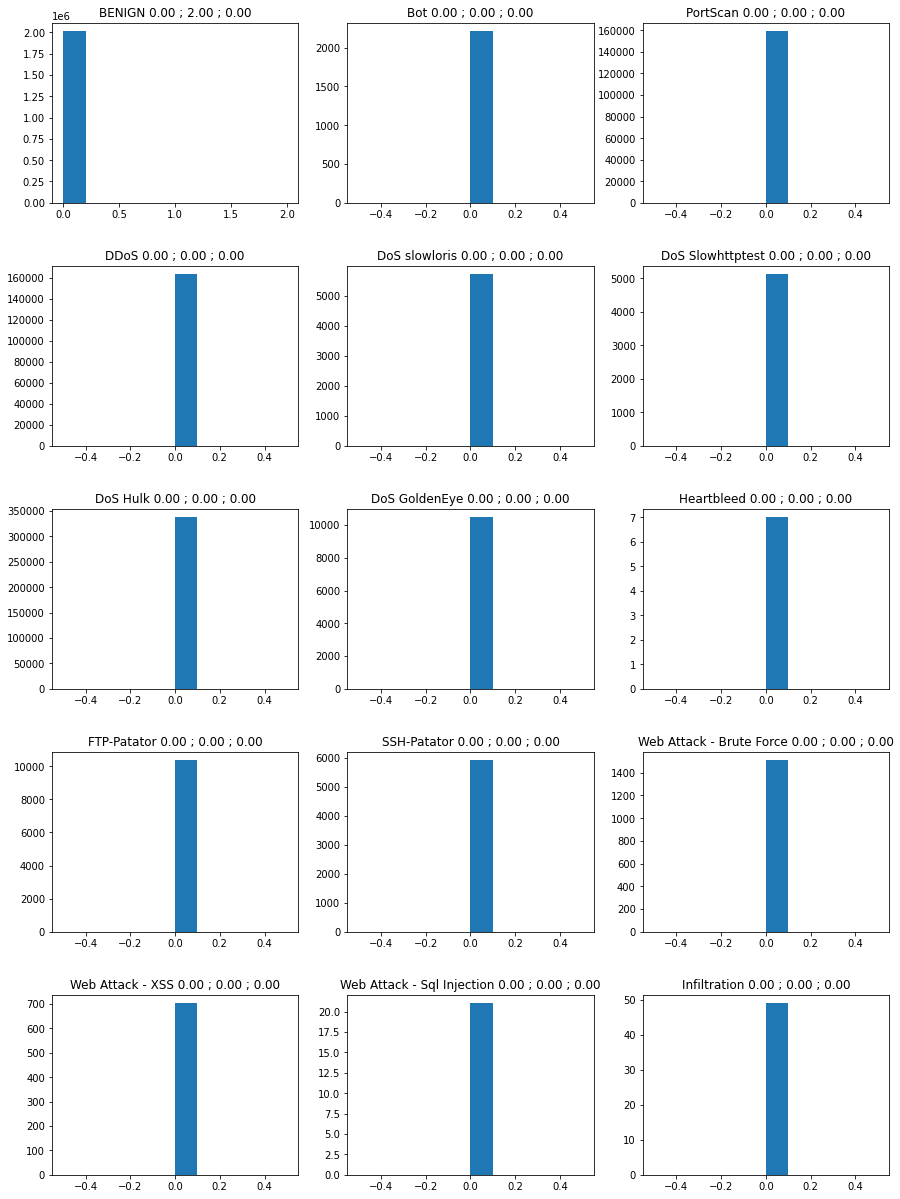

++++++++++++++++++++++++++++++++++++++++++++++++++
CWR Flag Count min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


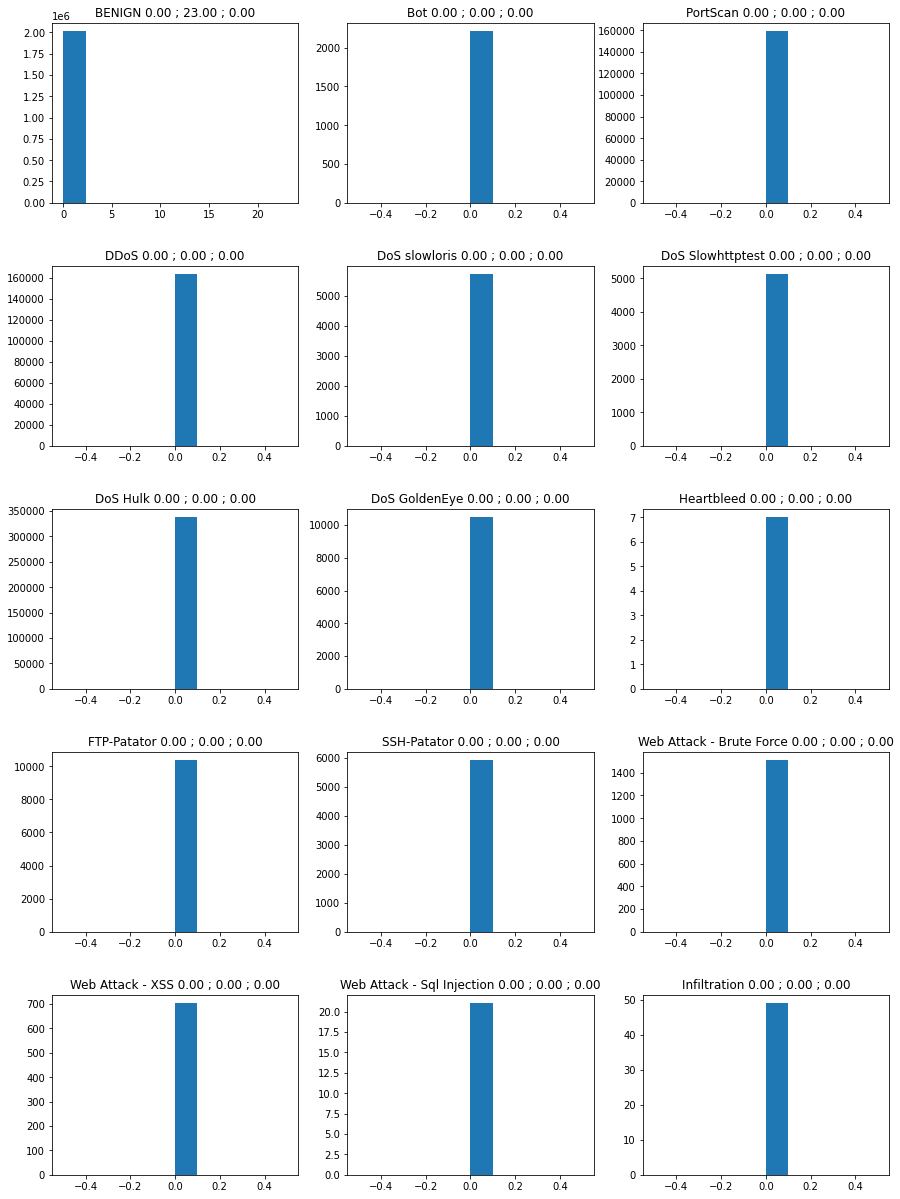

++++++++++++++++++++++++++++++++++++++++++++++++++
ECE Flag Count min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


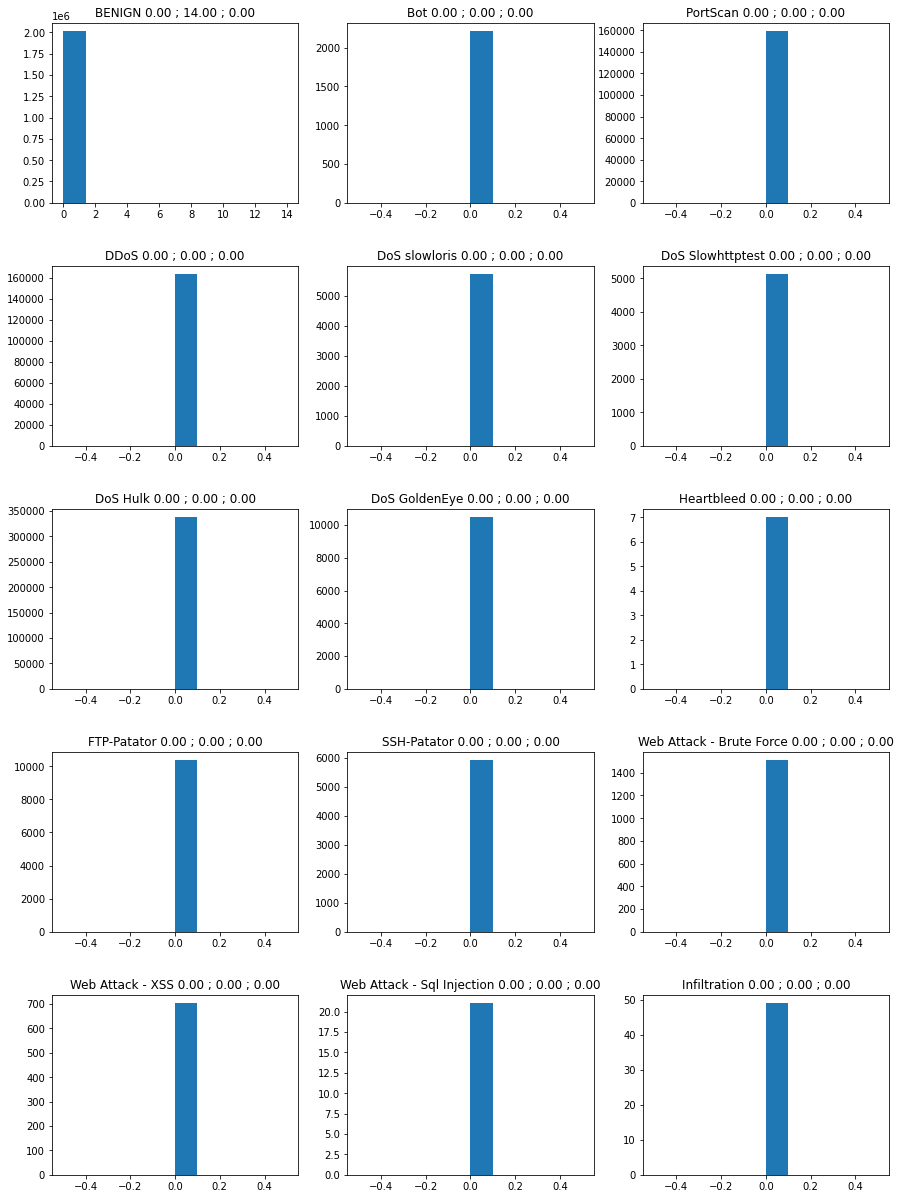

++++++++++++++++++++++++++++++++++++++++++++++++++
Down/Up Ratio min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


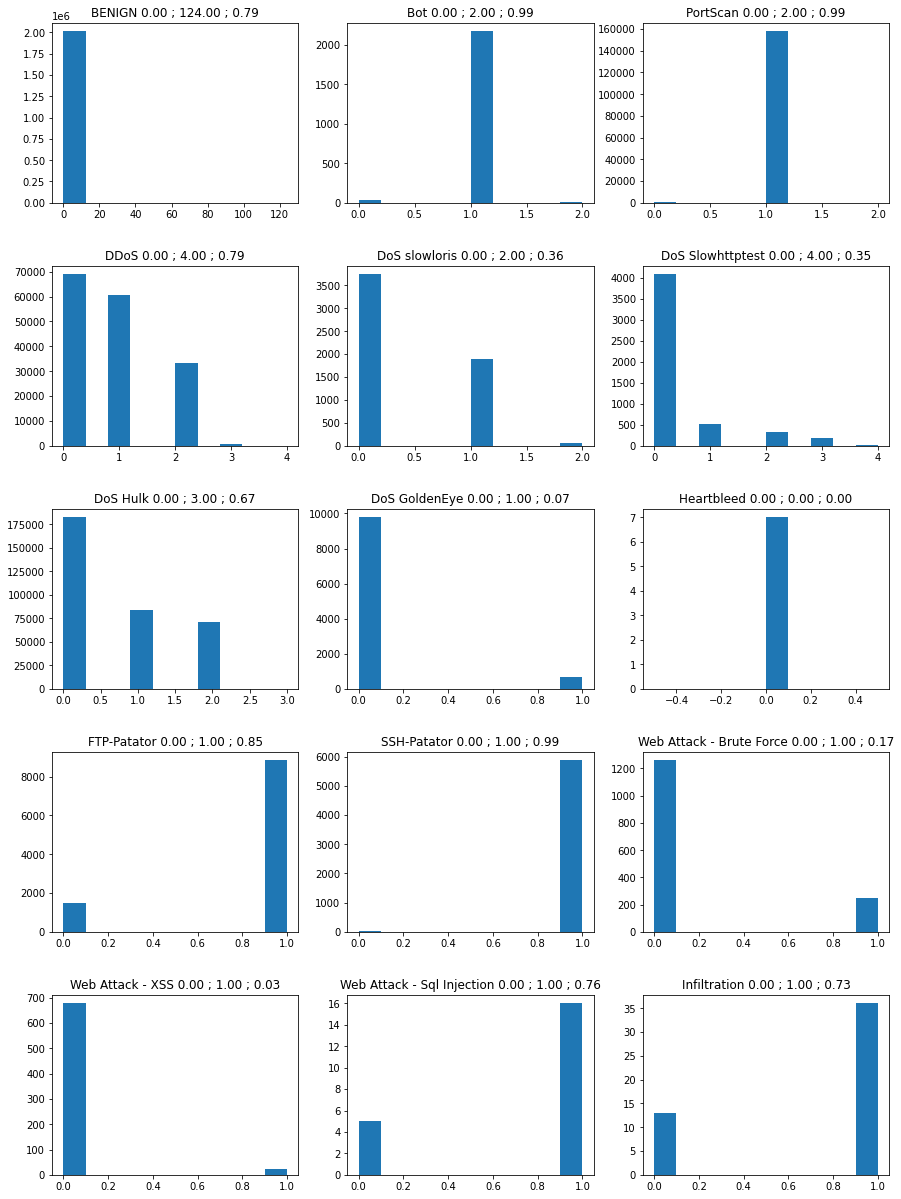

++++++++++++++++++++++++++++++++++++++++++++++++++
Average Packet Size min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


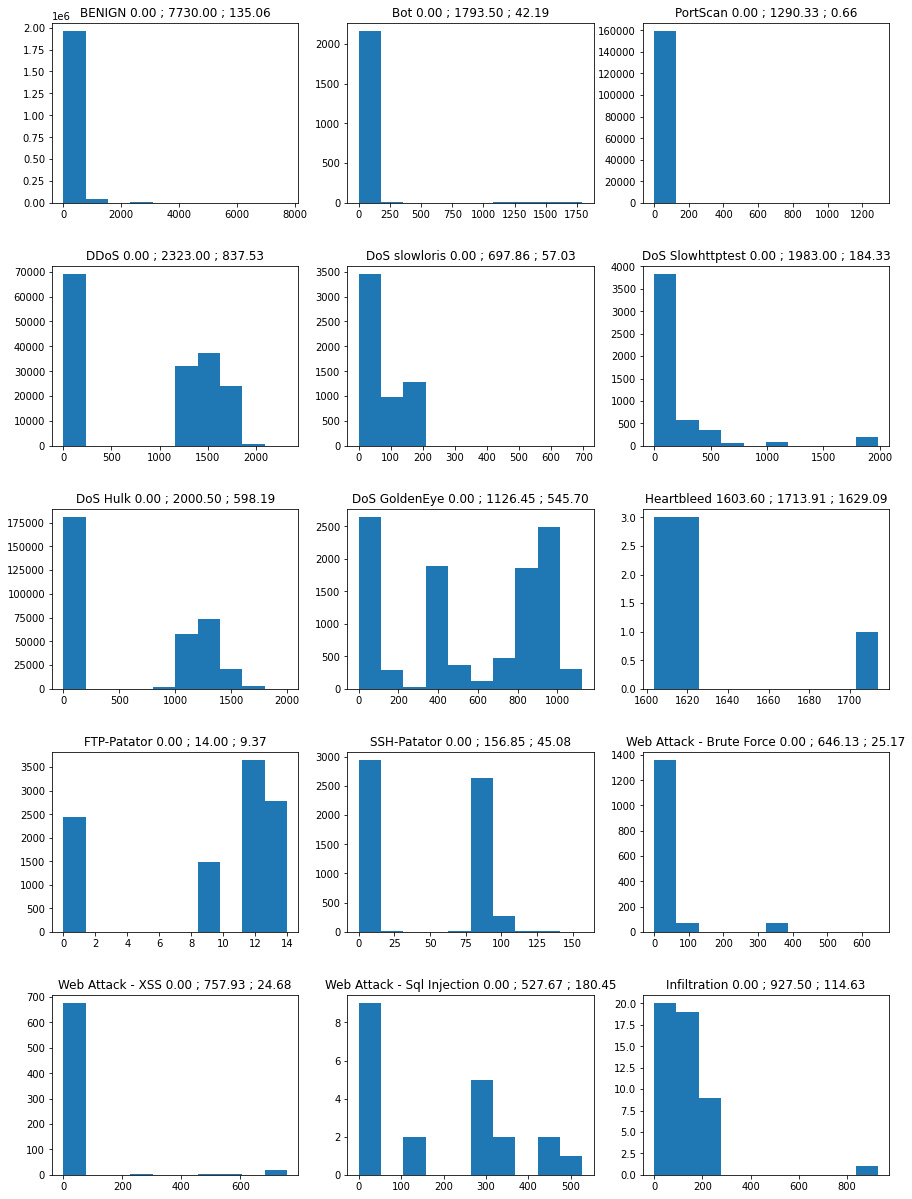

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd Segment Size Avg min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


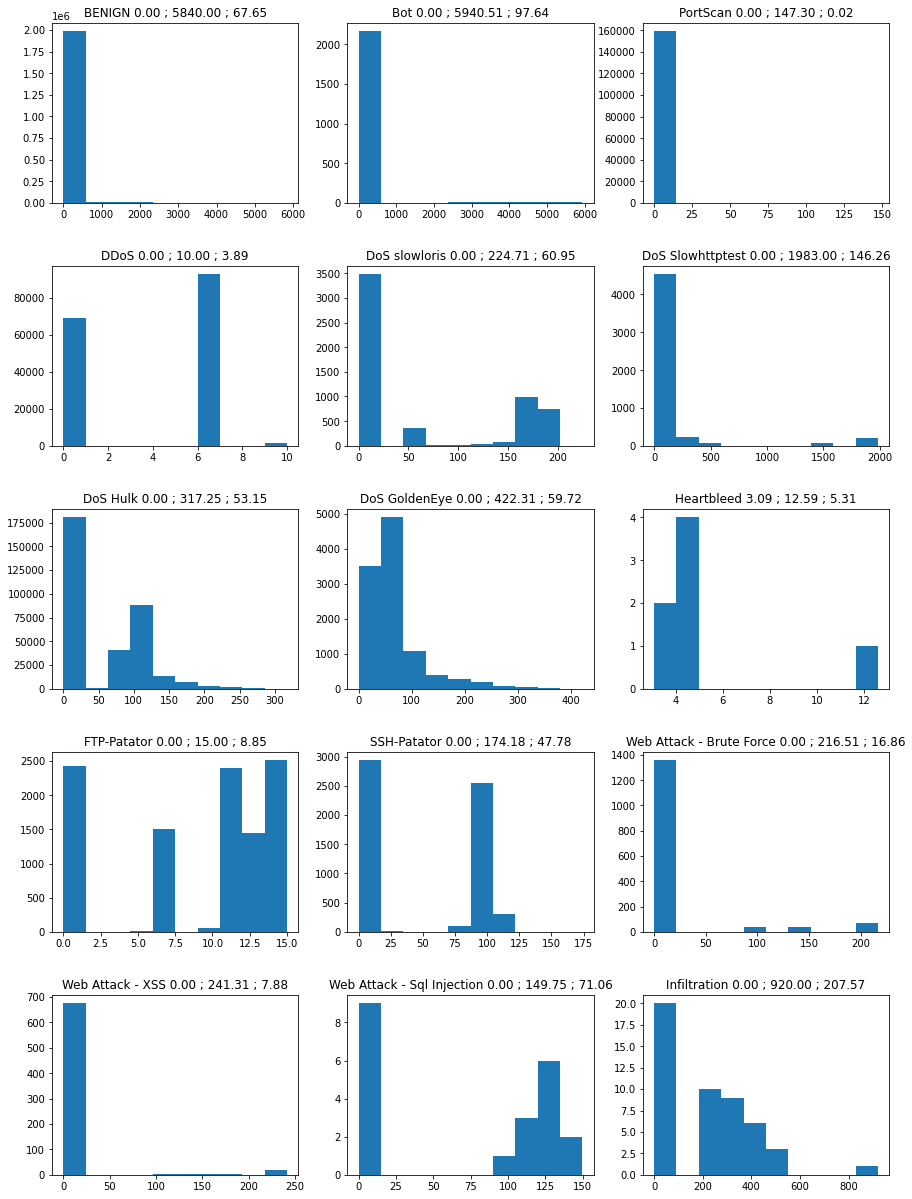

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd Segment Size Avg min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


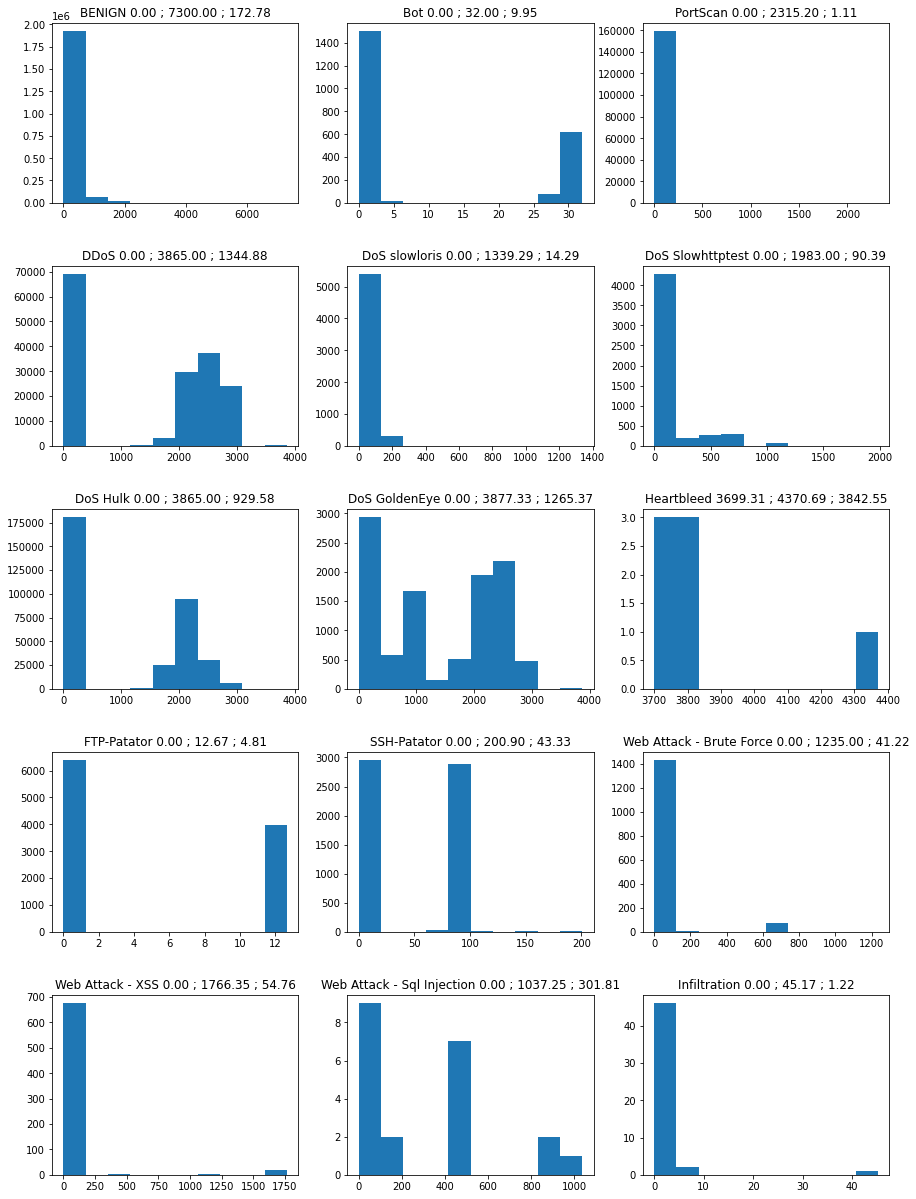

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd Bytes/Bulk Avg min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


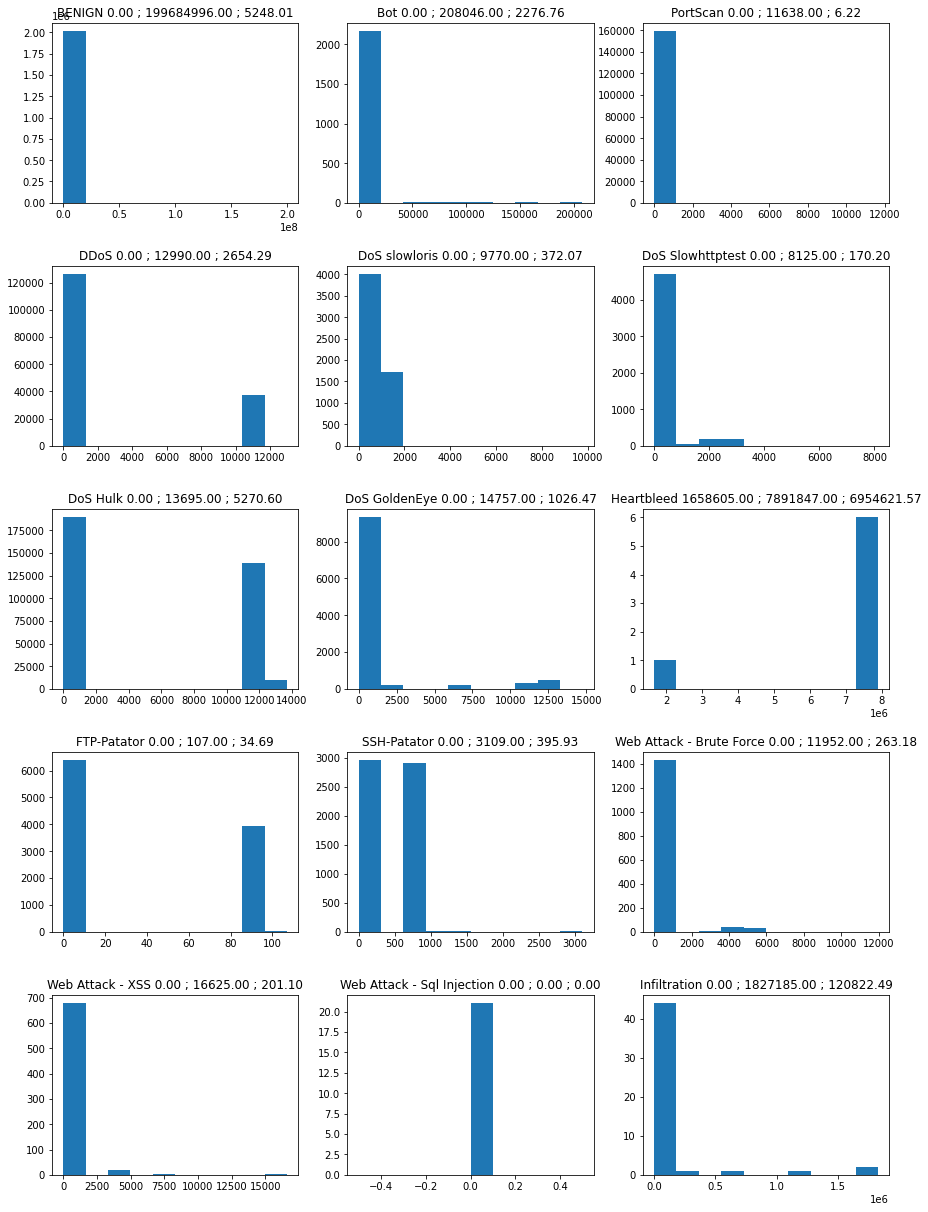

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd Packet/Bulk Avg min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


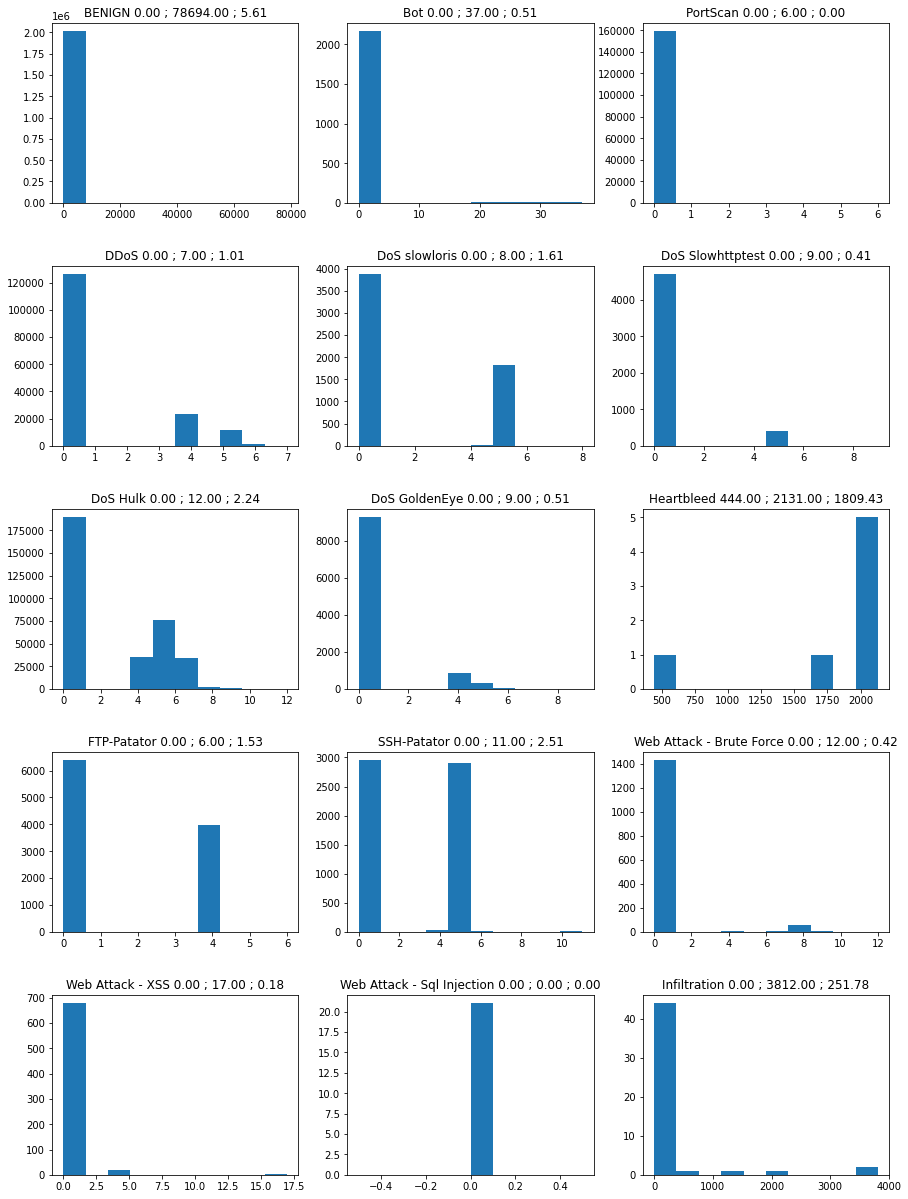

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd Bulk Rate Avg min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


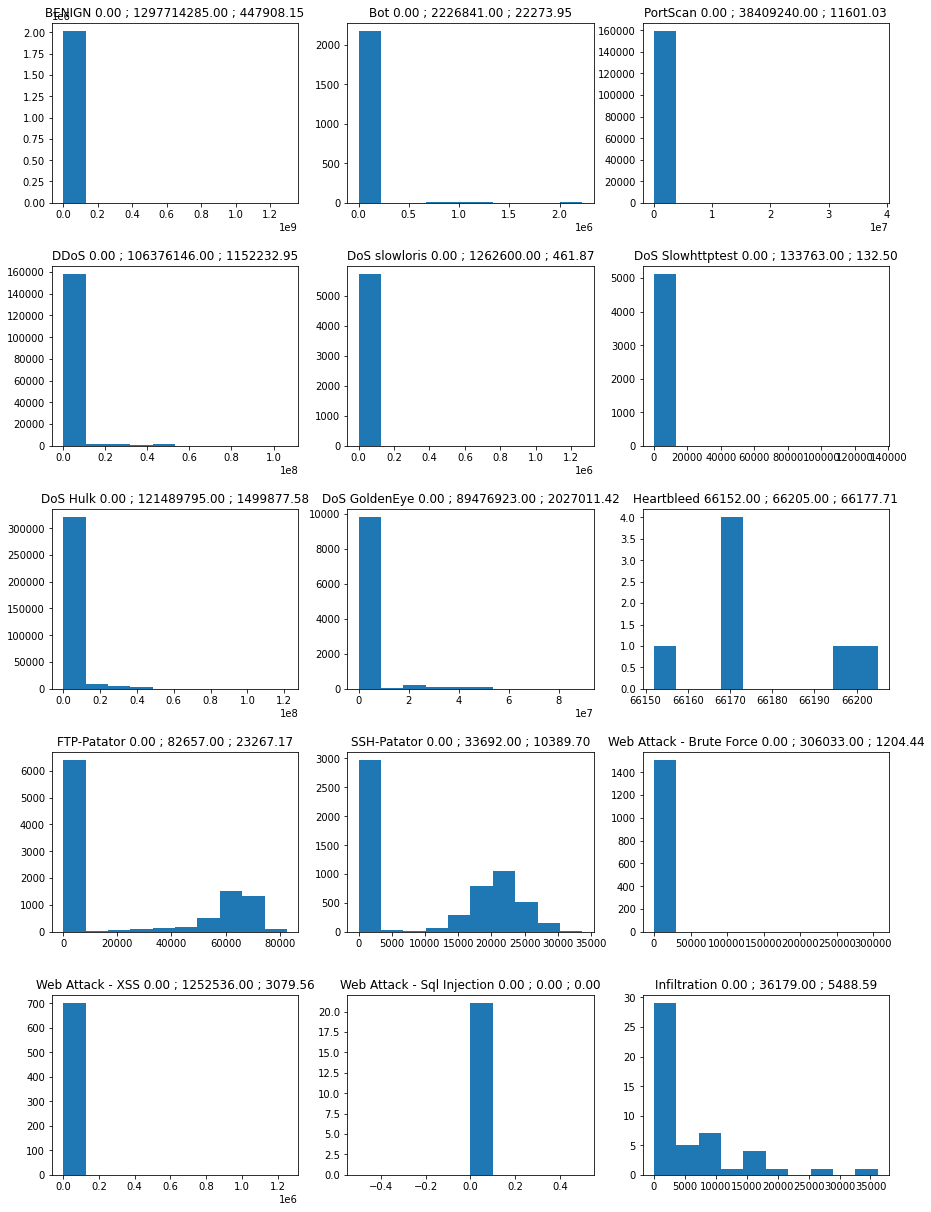

++++++++++++++++++++++++++++++++++++++++++++++++++
Subflow Fwd Packets min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


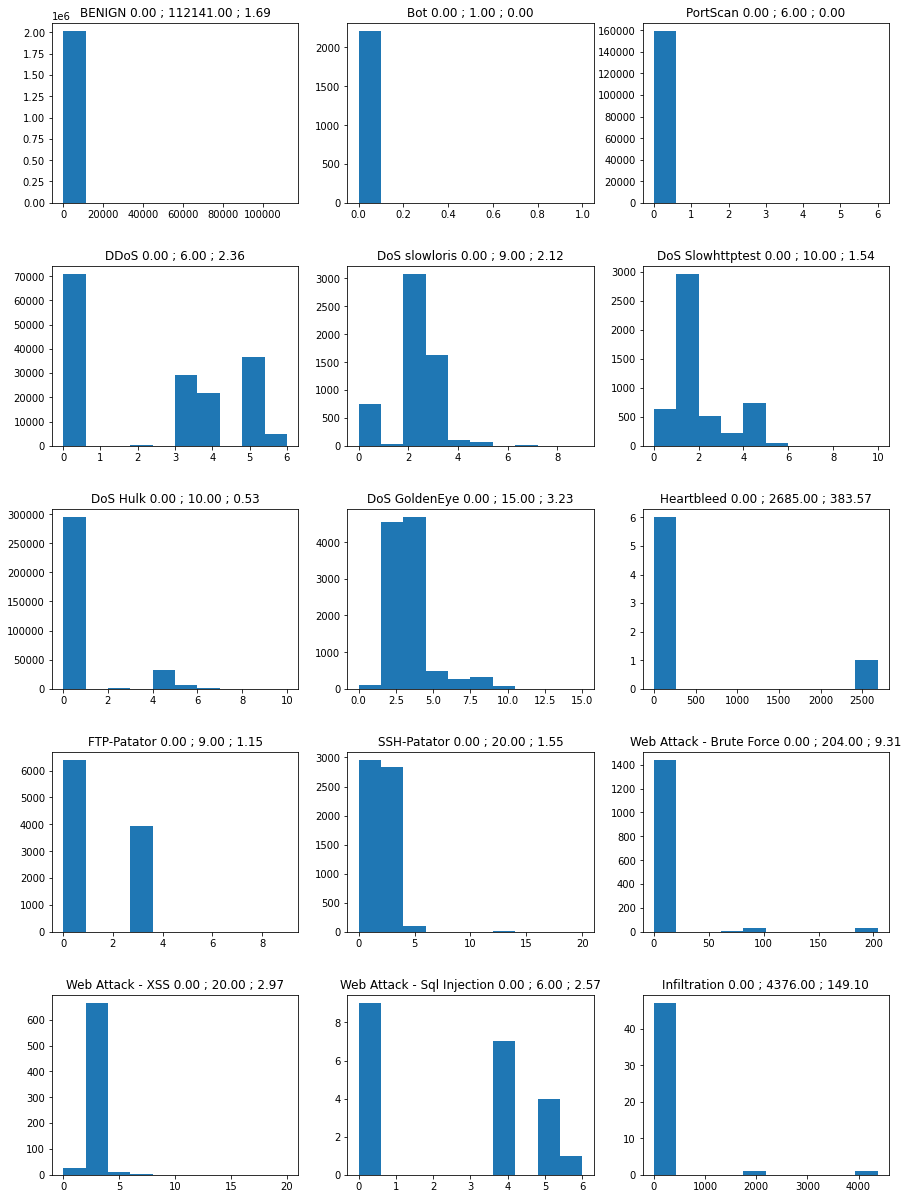

++++++++++++++++++++++++++++++++++++++++++++++++++
Subflow Fwd Bytes min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


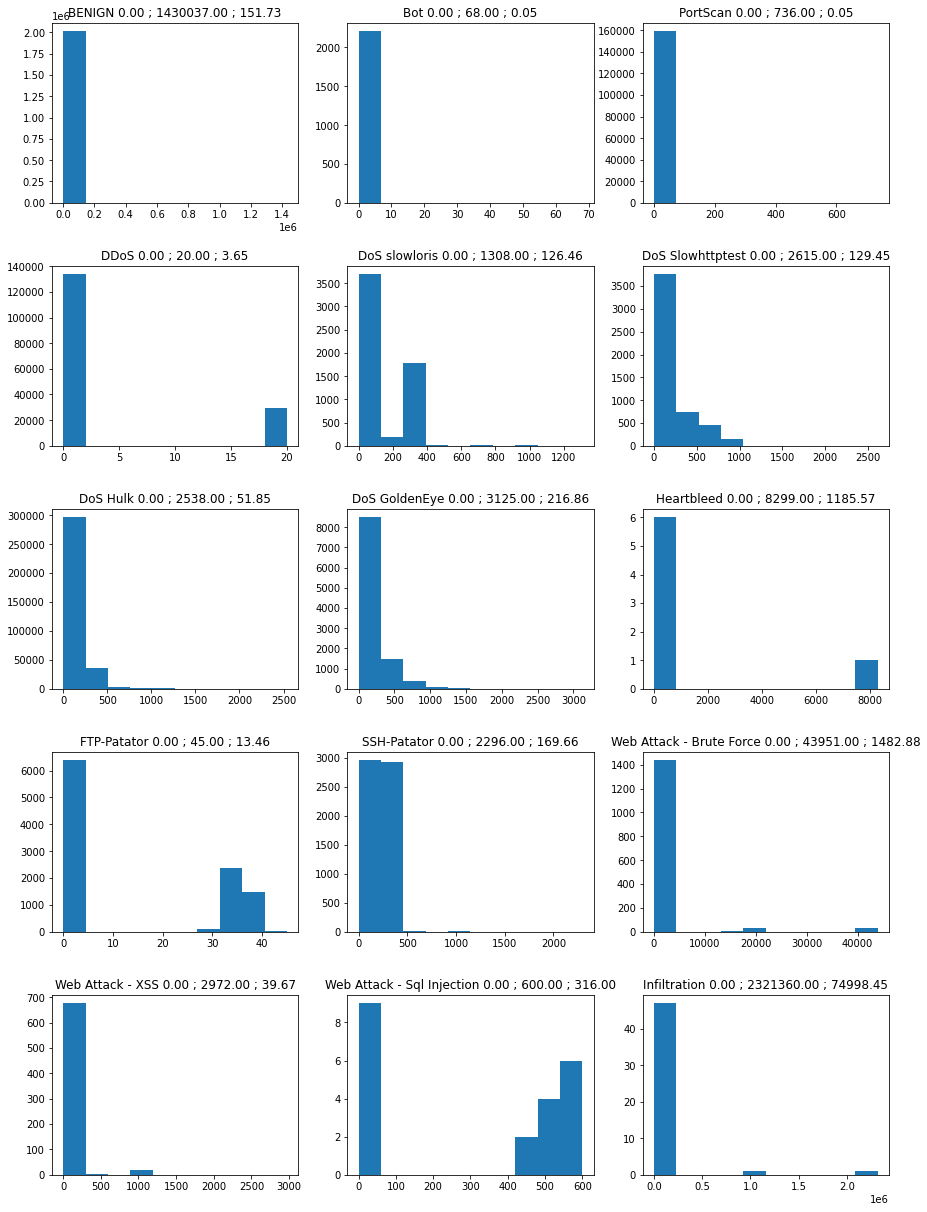

++++++++++++++++++++++++++++++++++++++++++++++++++
Subflow Bwd Packets min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


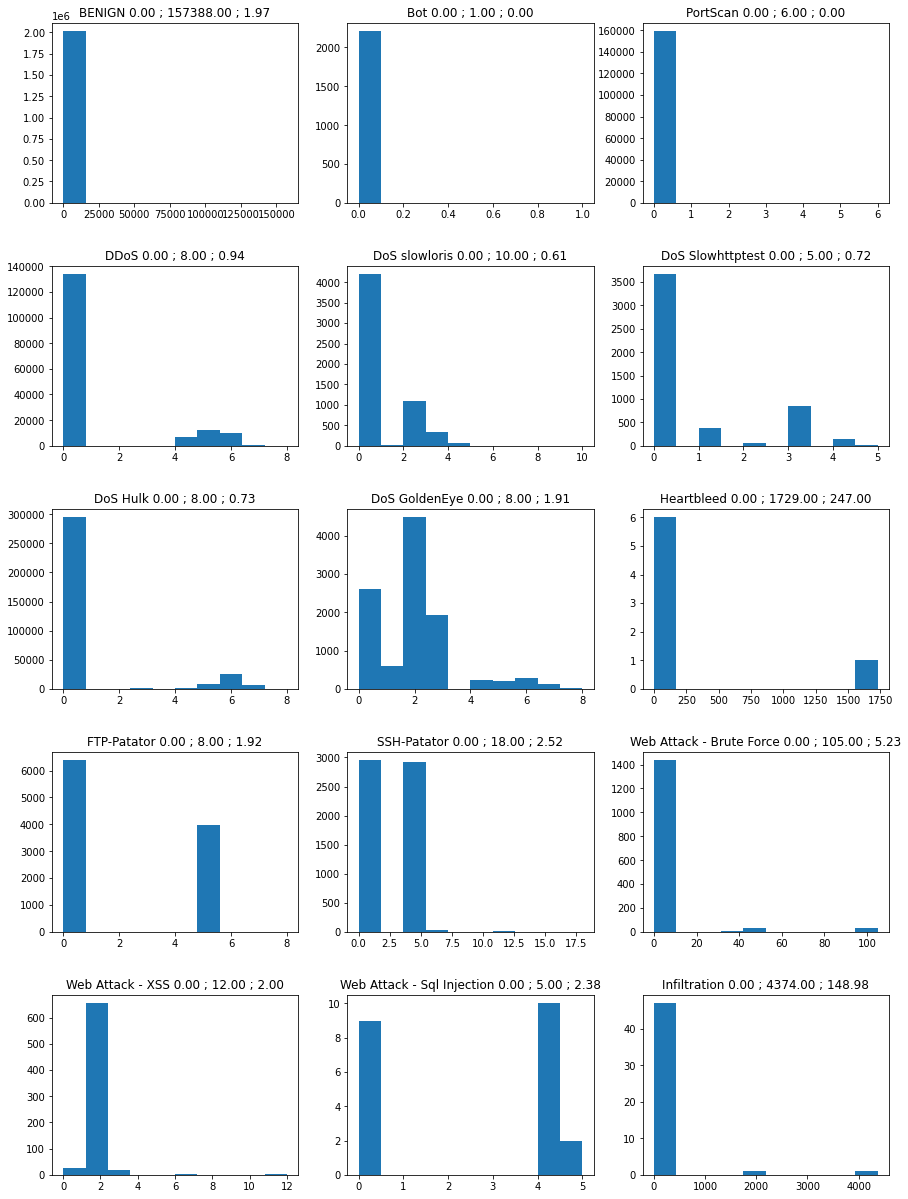

++++++++++++++++++++++++++++++++++++++++++++++++++
Subflow Bwd Bytes min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


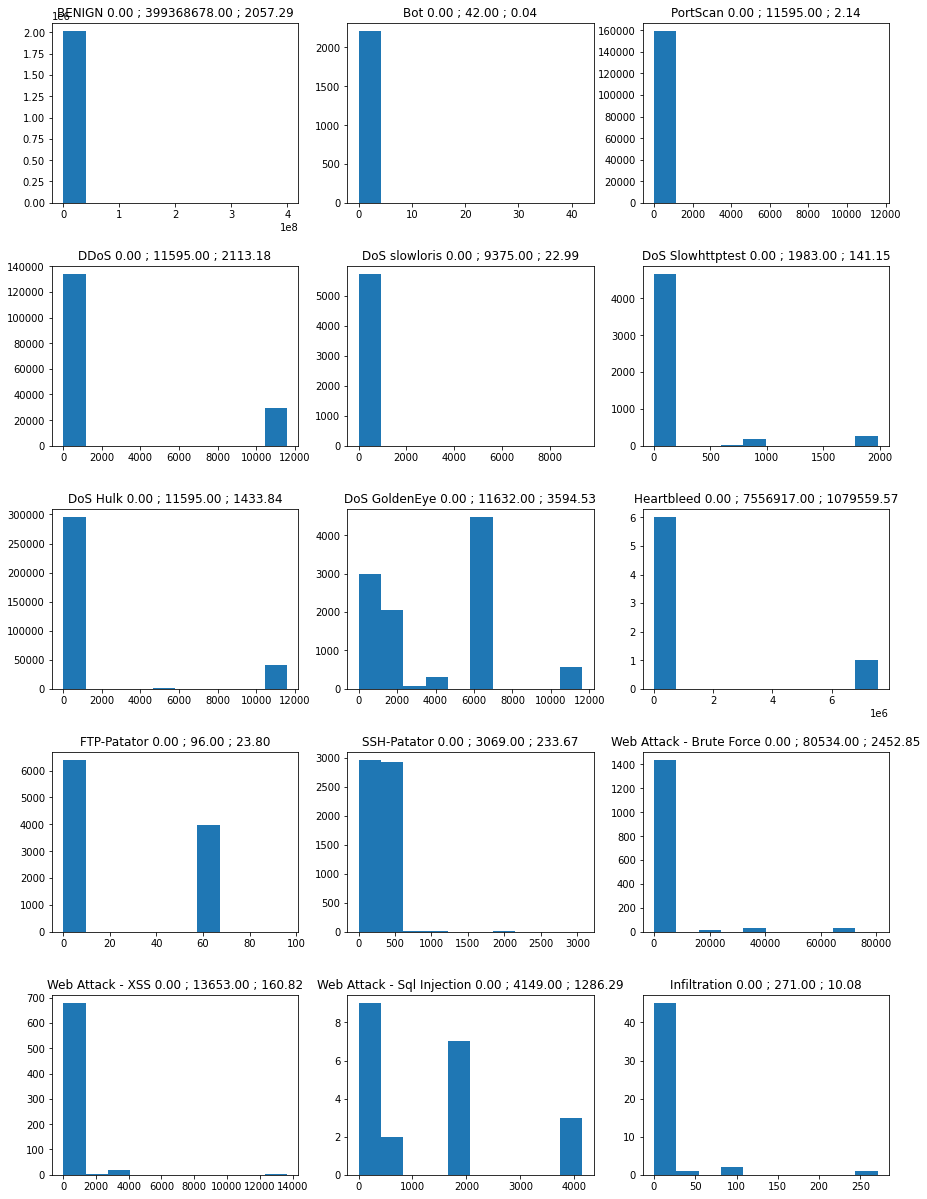

++++++++++++++++++++++++++++++++++++++++++++++++++
FWD Init Win Bytes min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


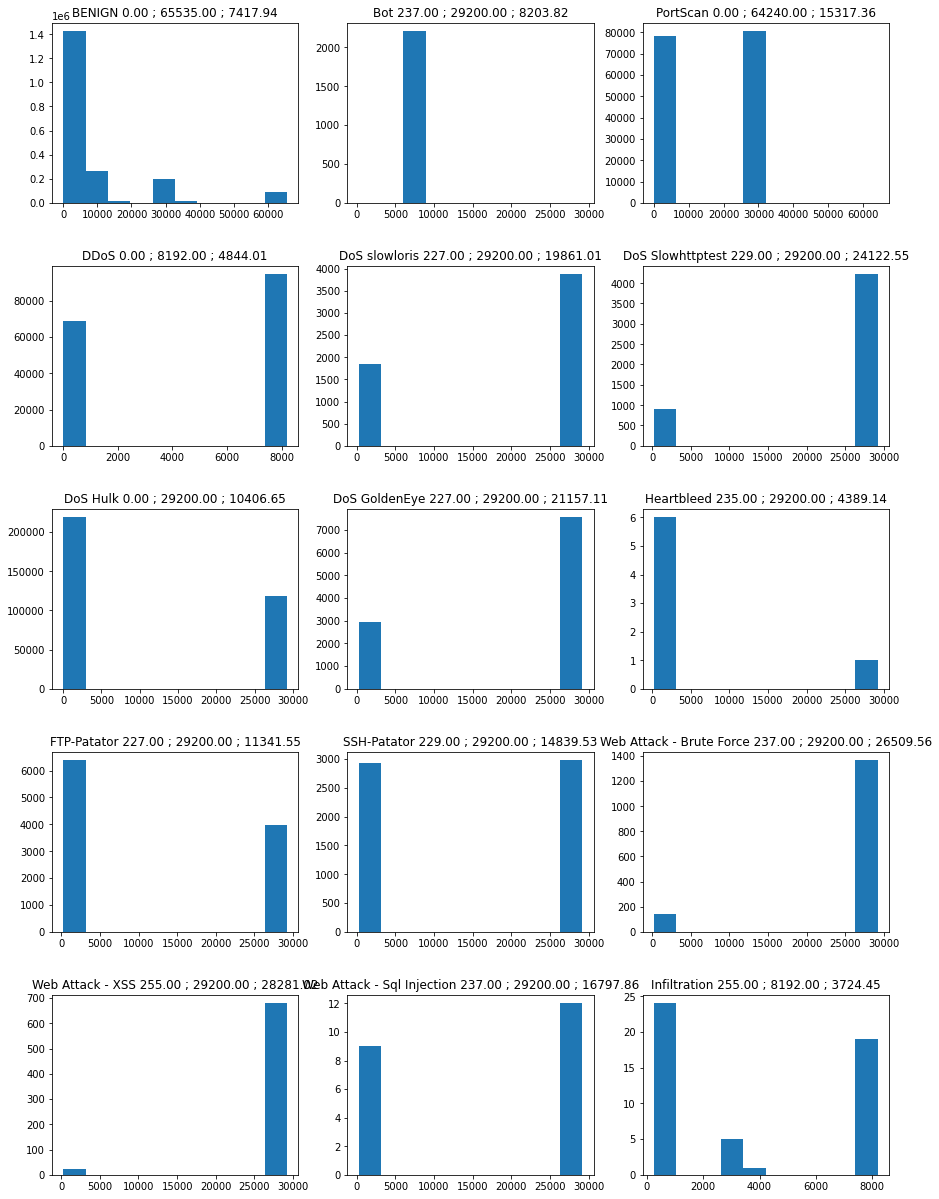

++++++++++++++++++++++++++++++++++++++++++++++++++
Bwd Init Win Bytes min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


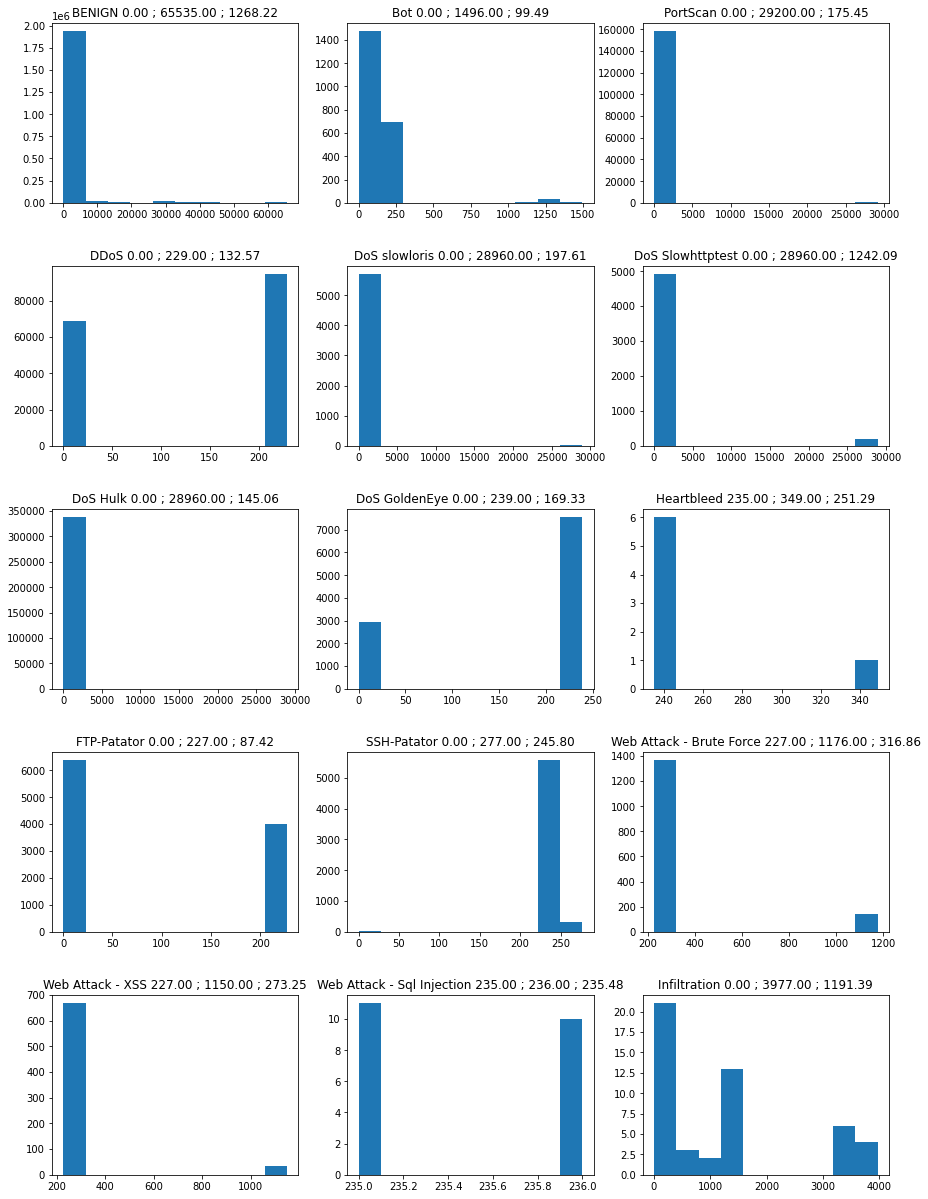

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd Act Data Pkts min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


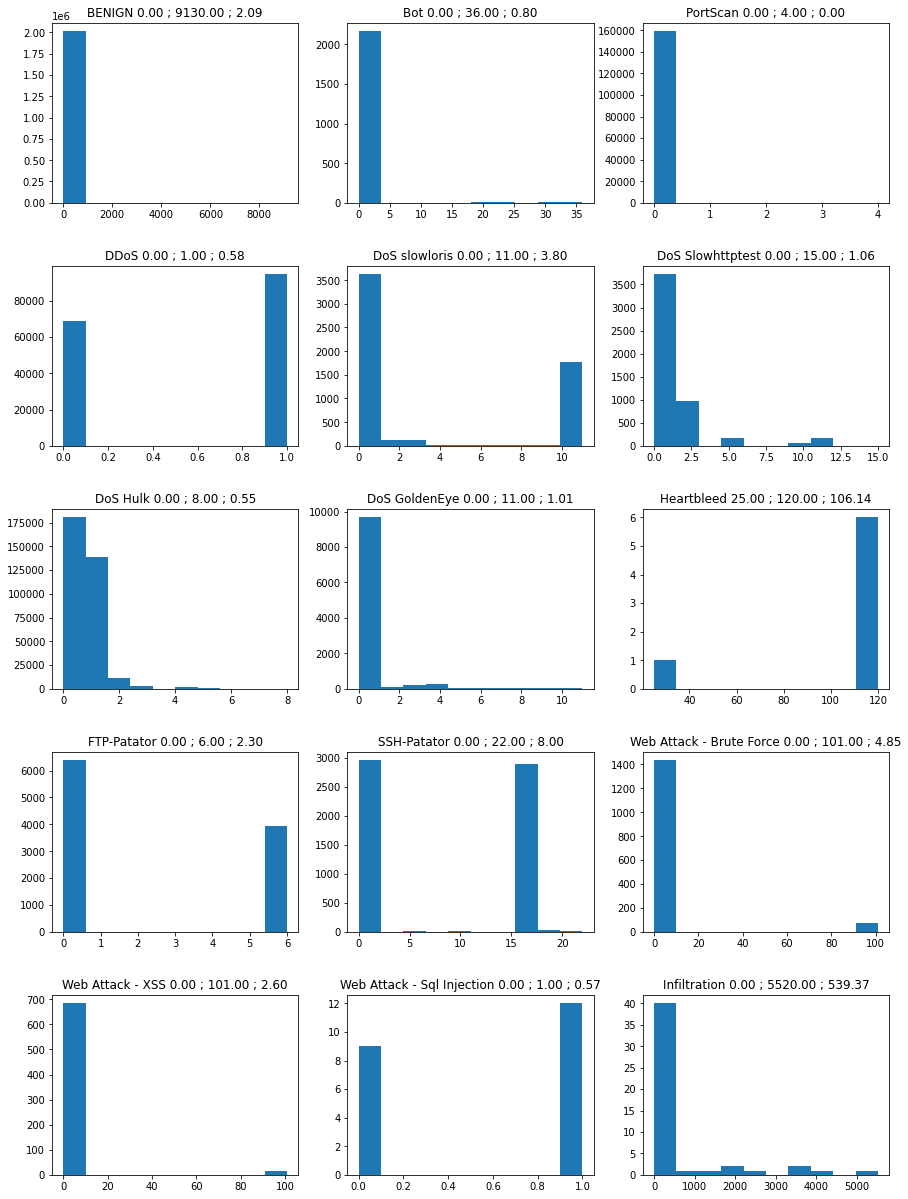

++++++++++++++++++++++++++++++++++++++++++++++++++
Fwd Seg Size Min min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


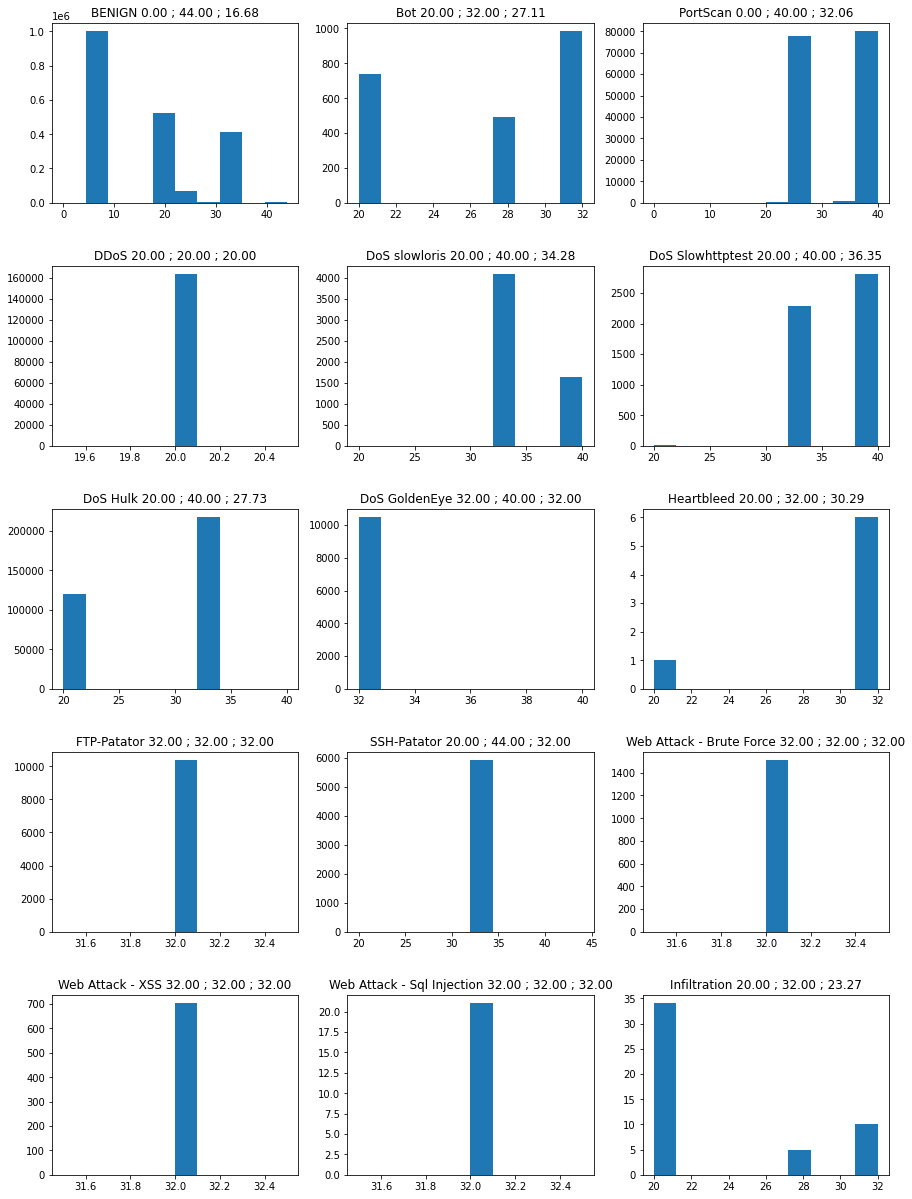

++++++++++++++++++++++++++++++++++++++++++++++++++
Active Mean min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


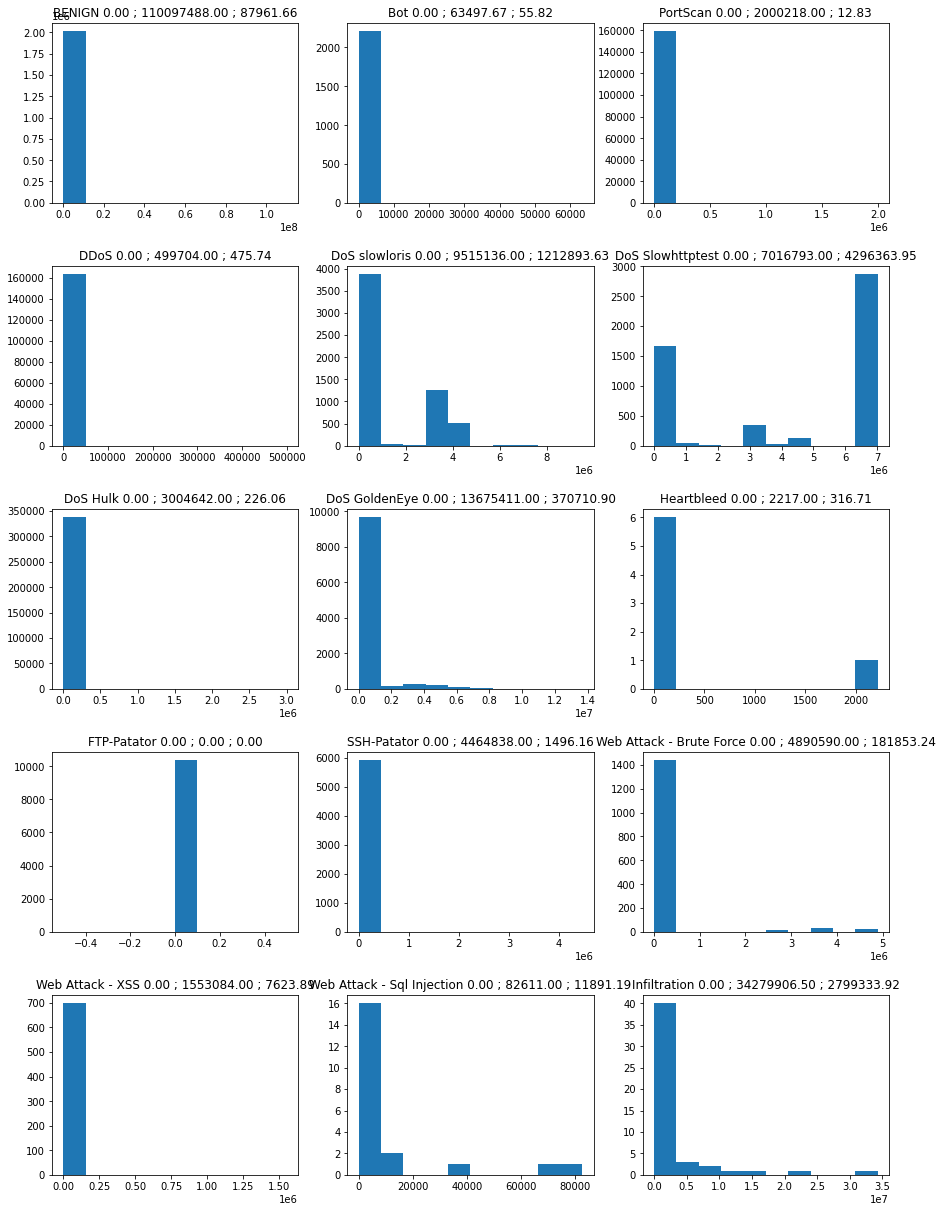

++++++++++++++++++++++++++++++++++++++++++++++++++
Active Std min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


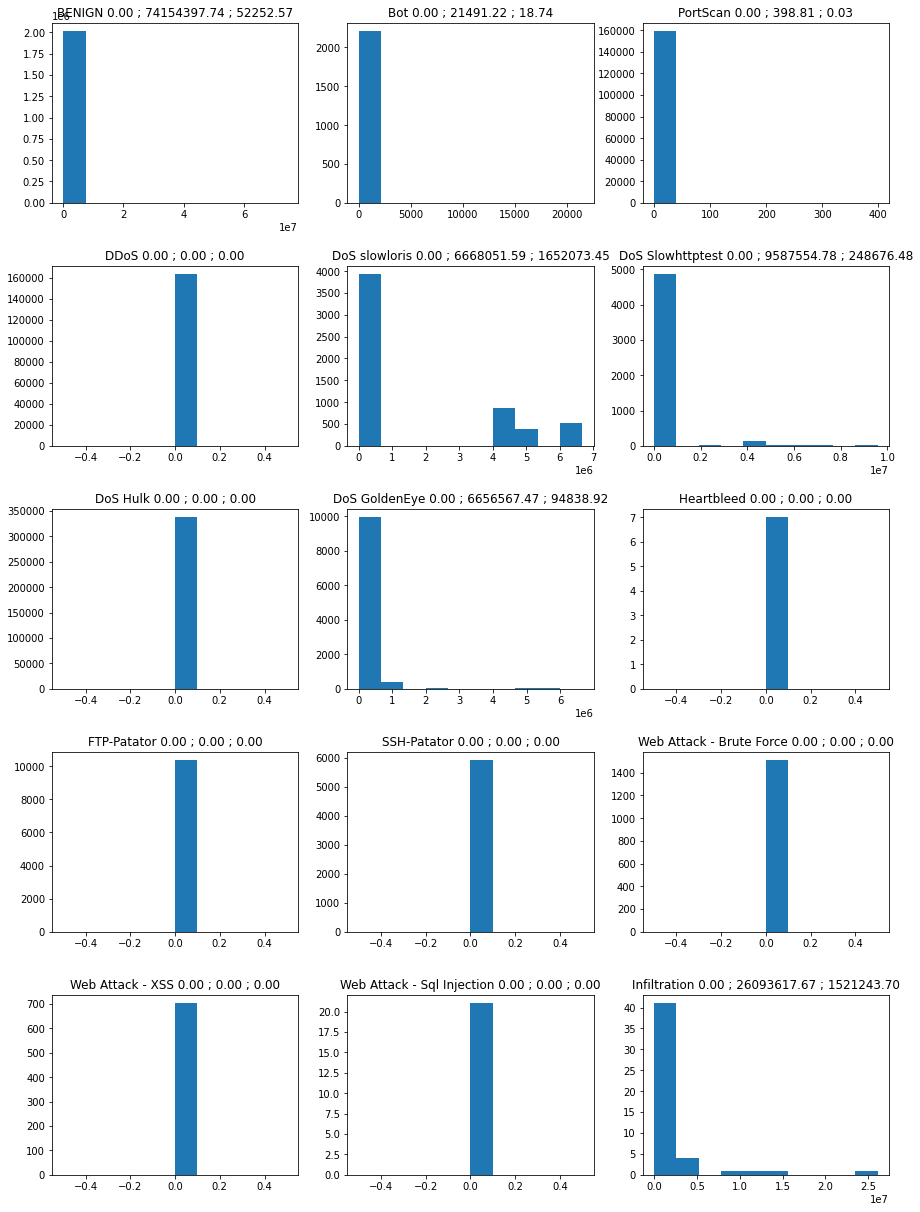

++++++++++++++++++++++++++++++++++++++++++++++++++
Active Max min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


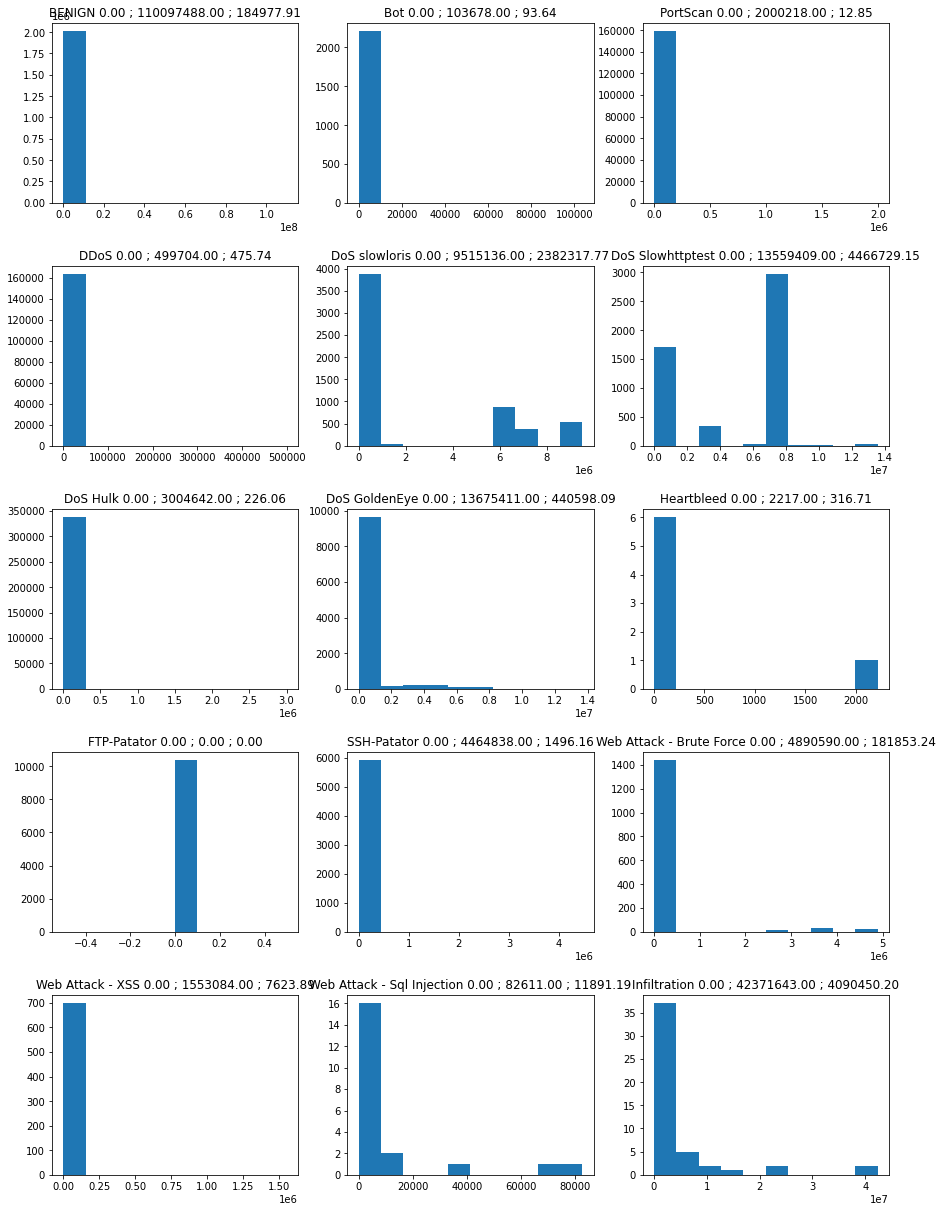

++++++++++++++++++++++++++++++++++++++++++++++++++
Active Min min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


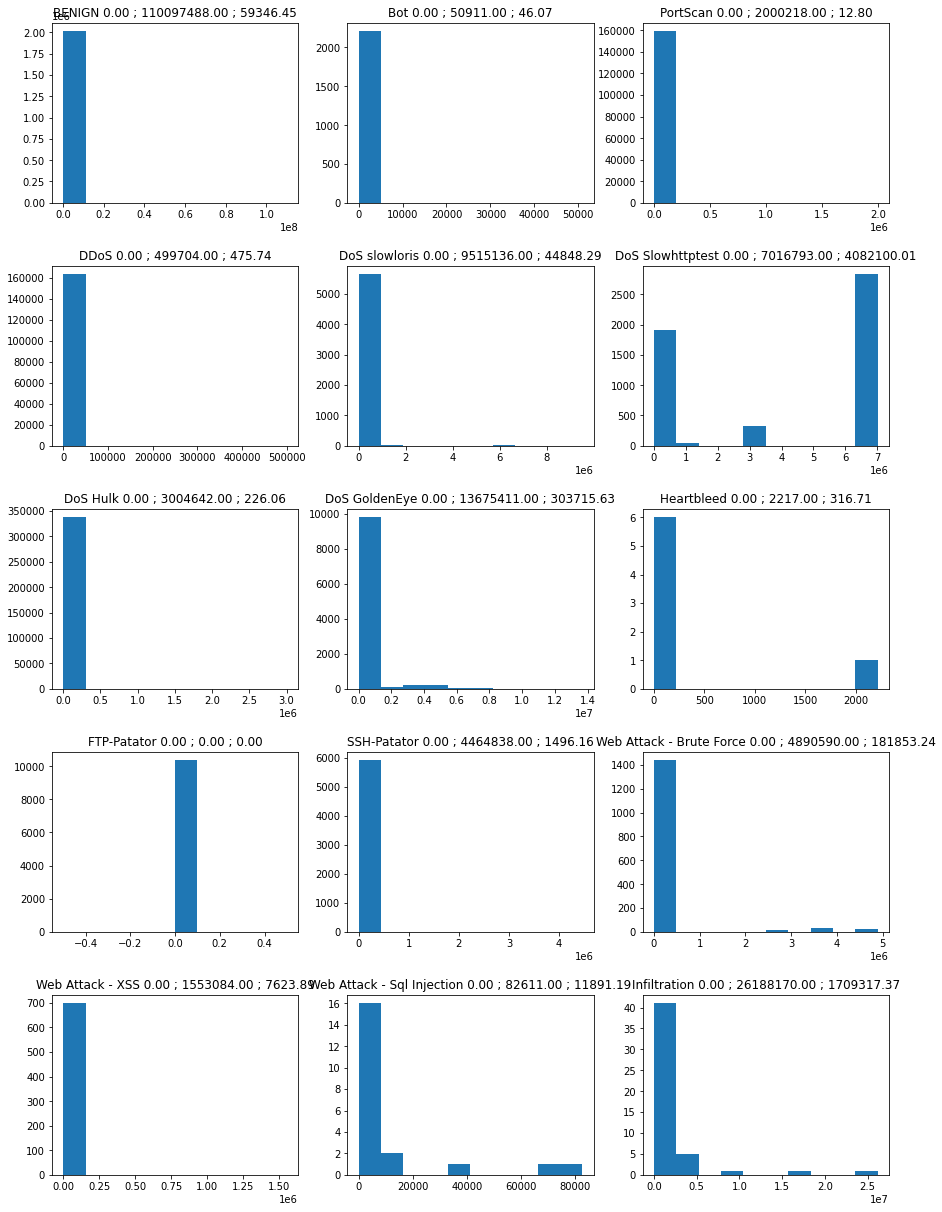

++++++++++++++++++++++++++++++++++++++++++++++++++
Idle Mean min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


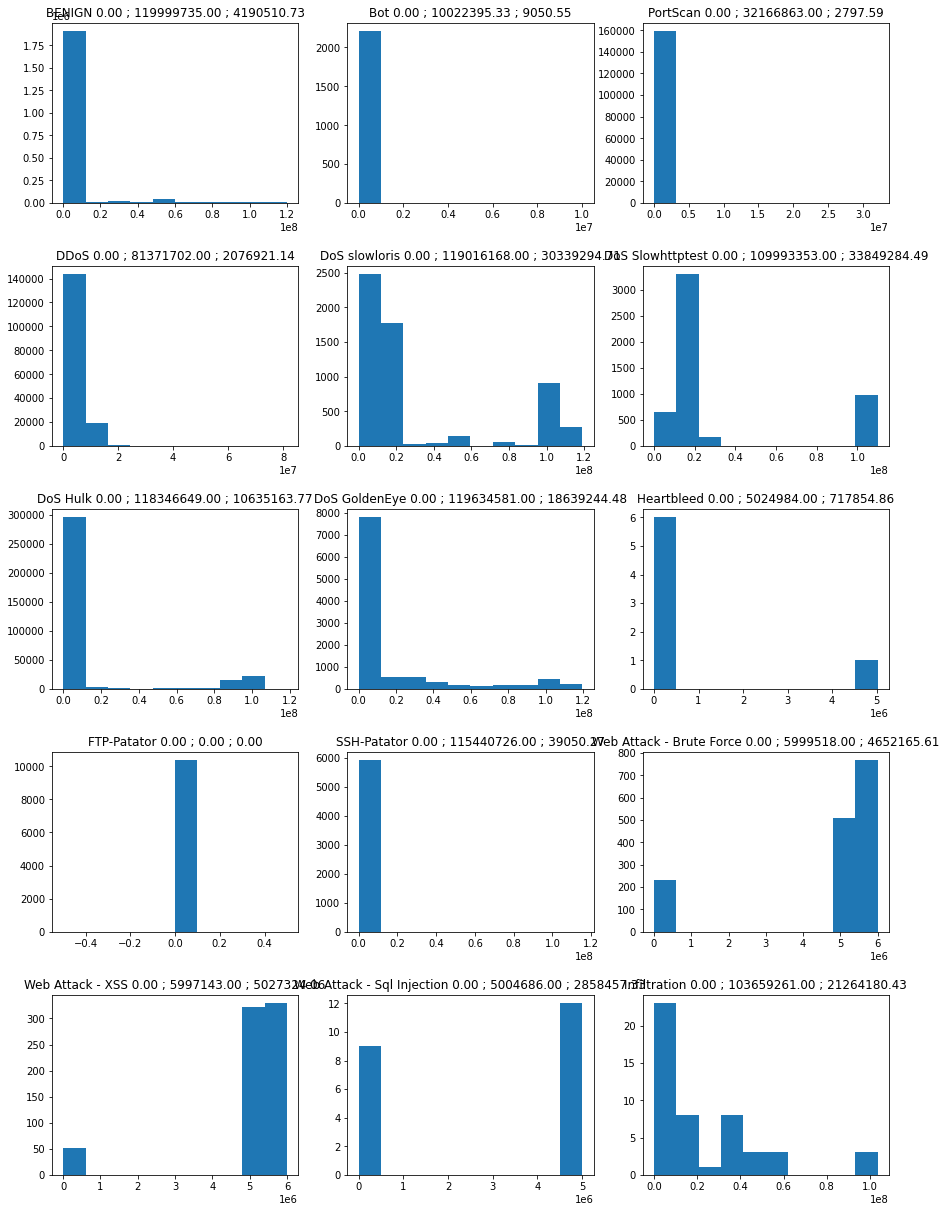

++++++++++++++++++++++++++++++++++++++++++++++++++
Idle Std min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


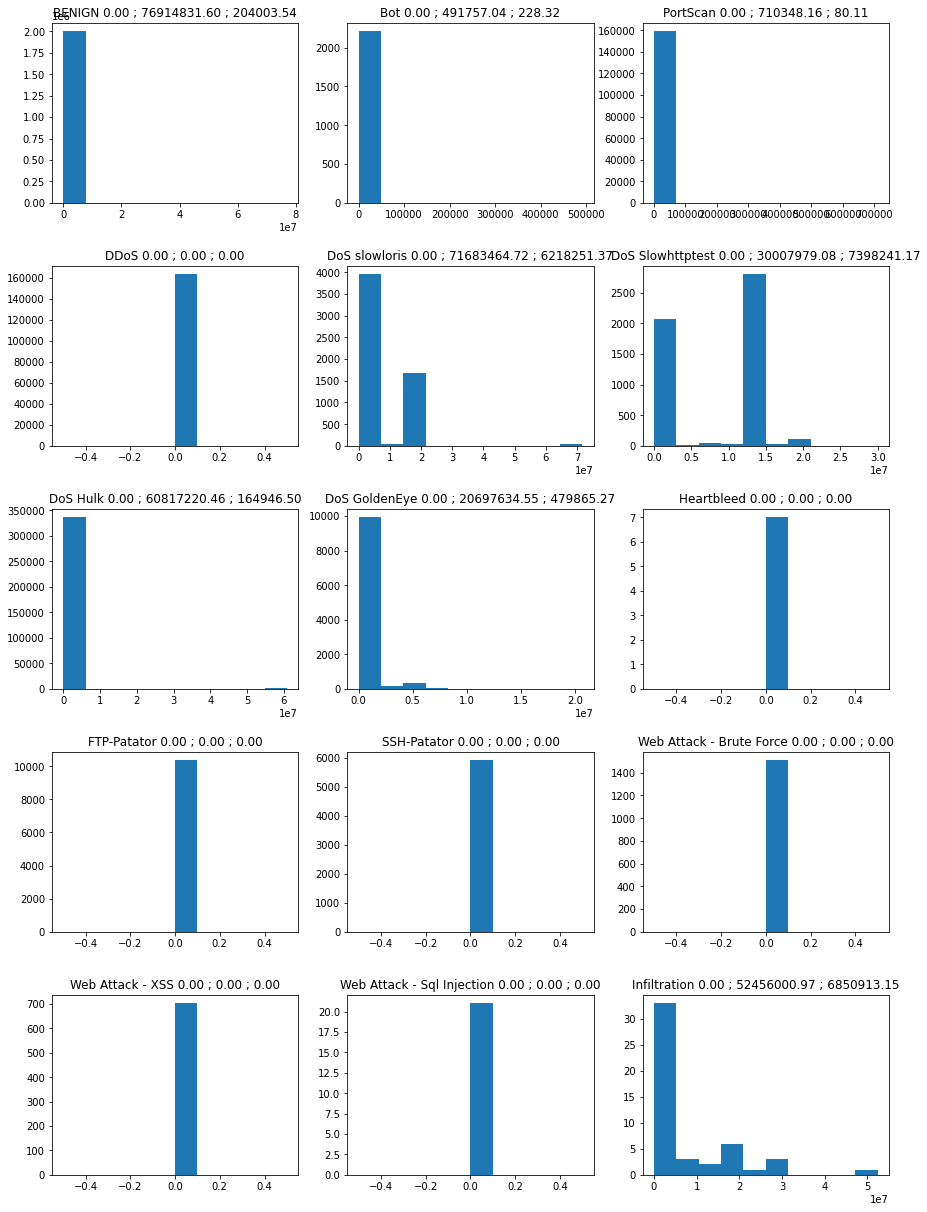

++++++++++++++++++++++++++++++++++++++++++++++++++
Idle Max min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


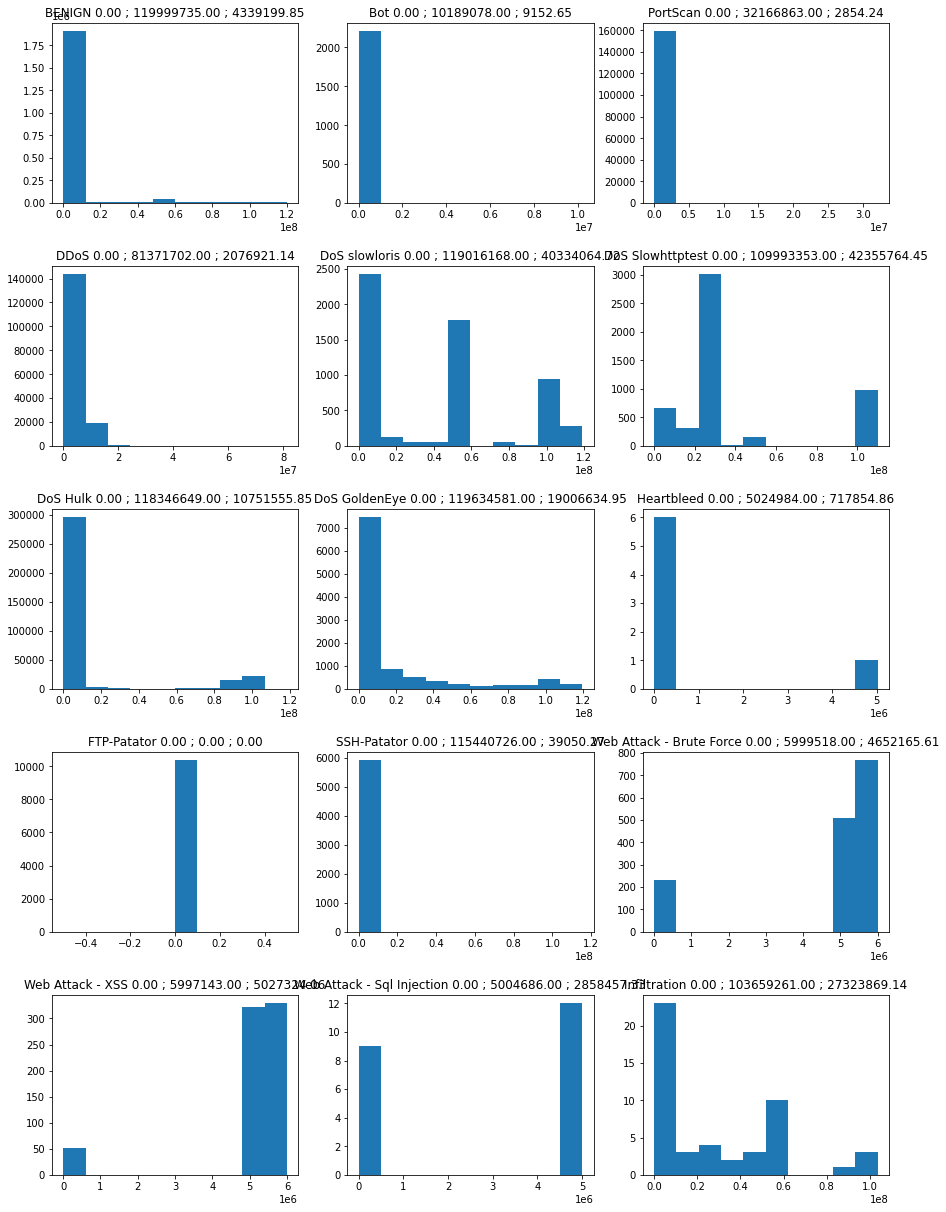

++++++++++++++++++++++++++++++++++++++++++++++++++
Idle Min min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


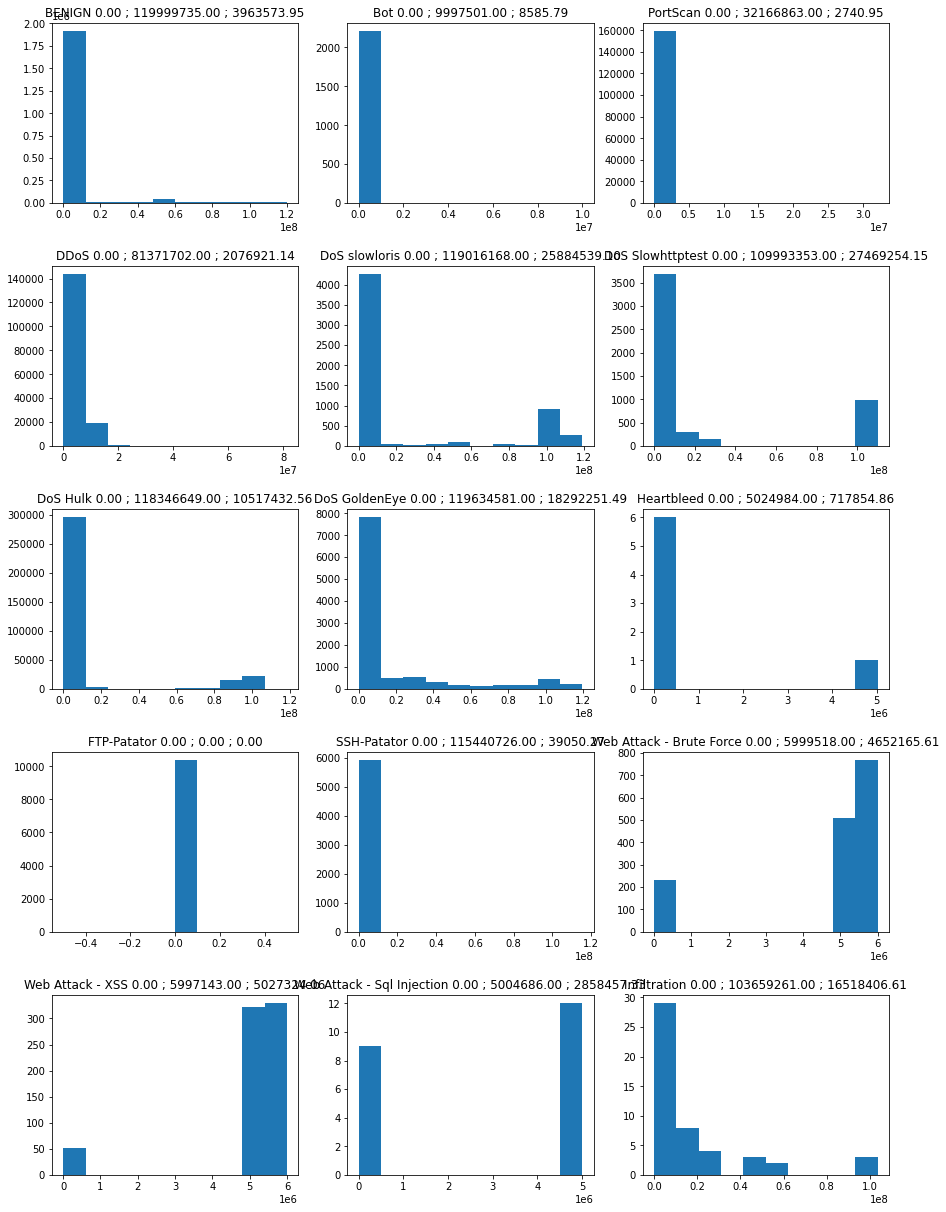

++++++++++++++++++++++++++++++++++++++++++++++++++
Label min, max, mean
++++++++++++++++++++++++++++++++++++++++++++++++++


In [14]:
histogram_labeltypes(df_proc, colnames = None, label_name = 'Label')

0


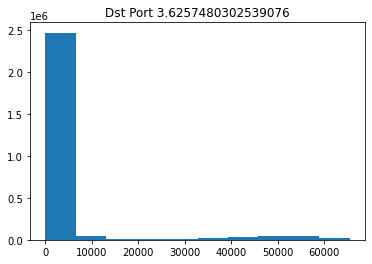

0


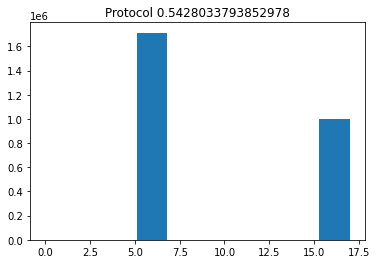

1


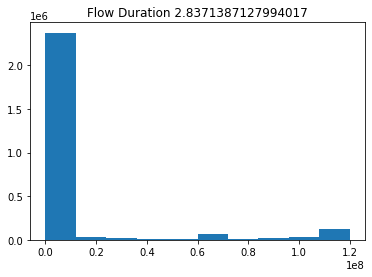

1


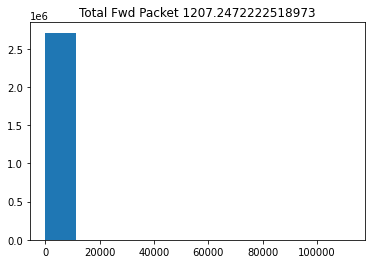

0


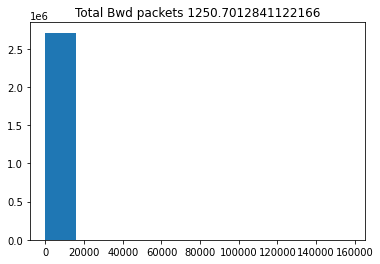

0.0


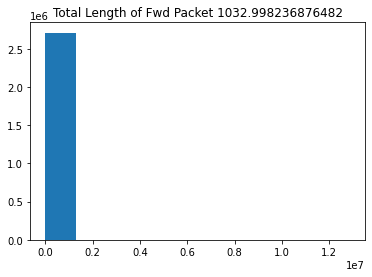

0.0


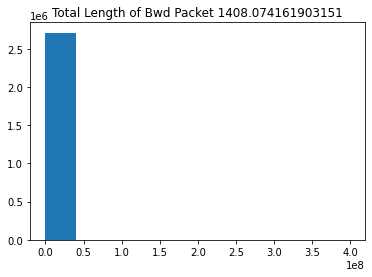

0.0


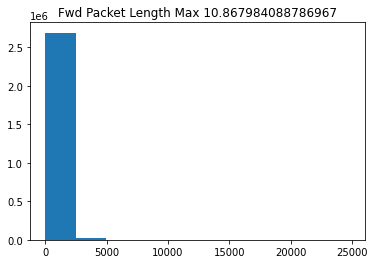

0.0


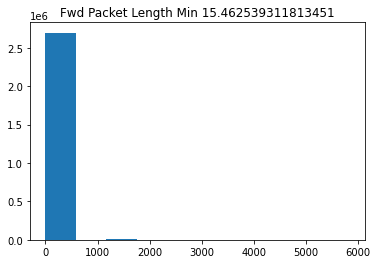

0.0


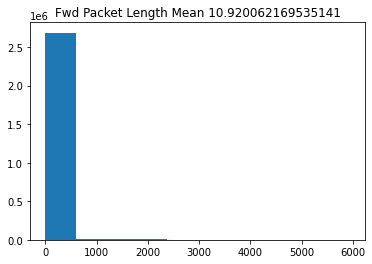

0.0


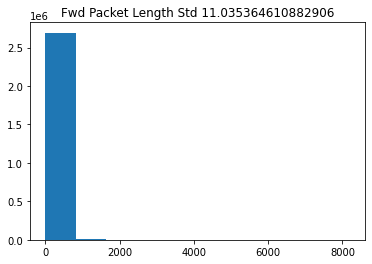

0.0


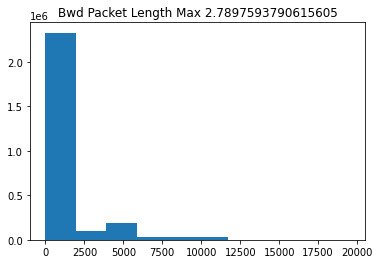

0.0


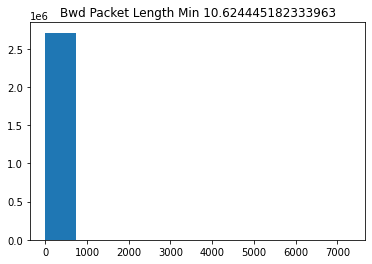

0.0


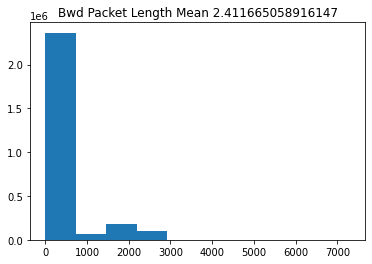

0.0


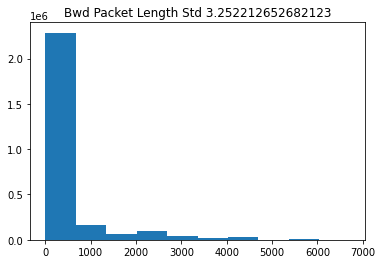

0.0


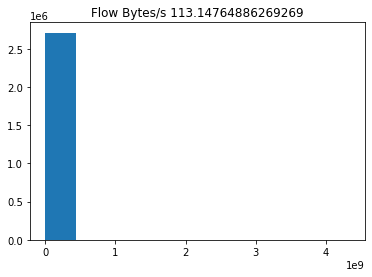

0.016717574327443


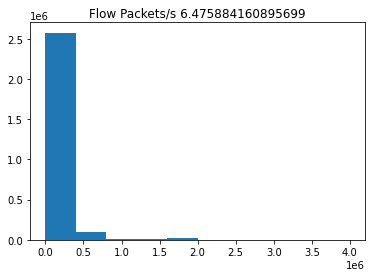

0.3333333333333333


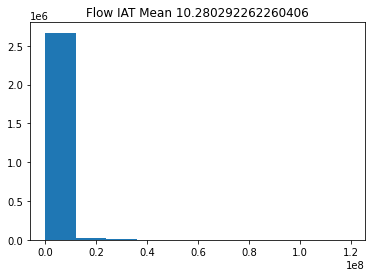

0.0


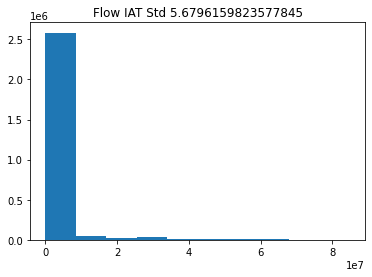

1.0


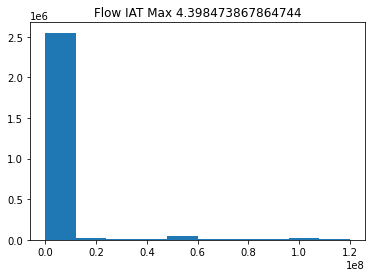

0.0


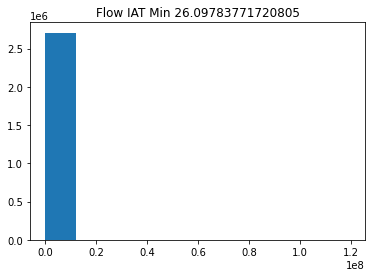

0.0


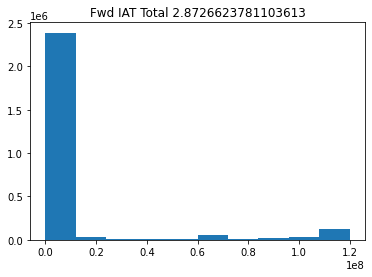

0.0


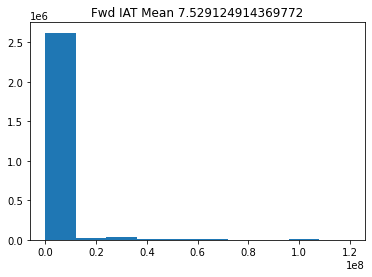

0.0


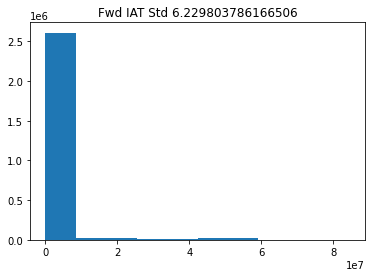

0.0


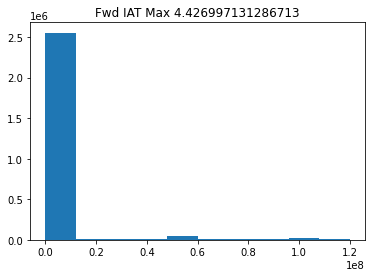

0.0


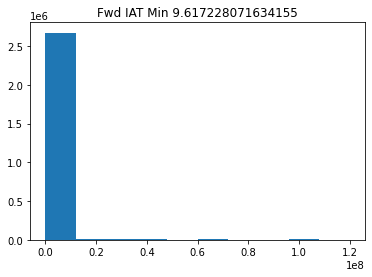

0.0


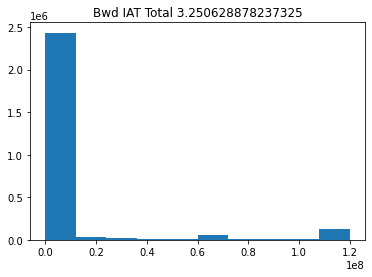

0.0


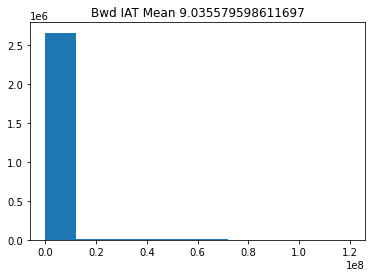

0.0


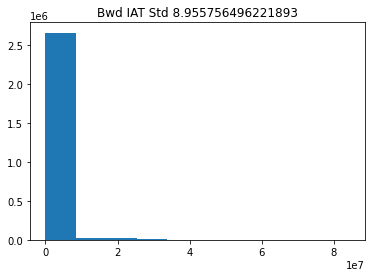

0.0


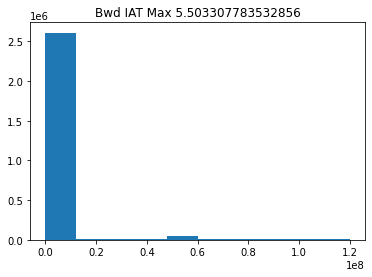

0.0


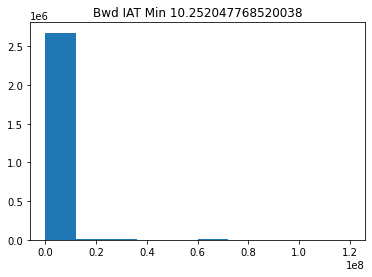

0


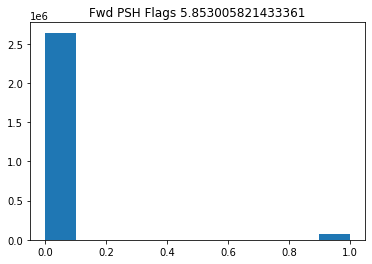

0


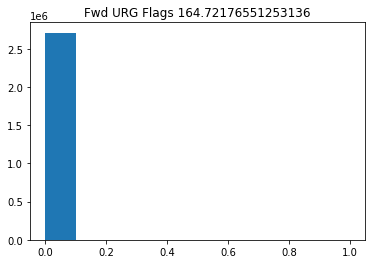

0


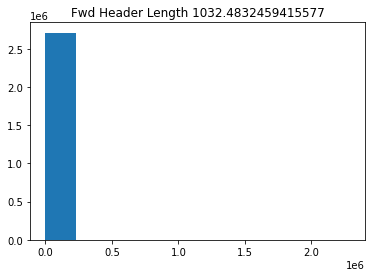

0


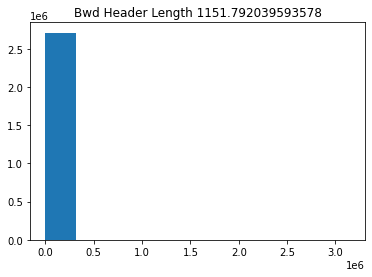

0.0084780408441317


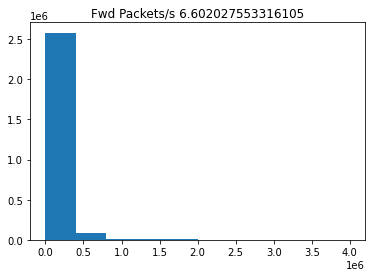

0.0


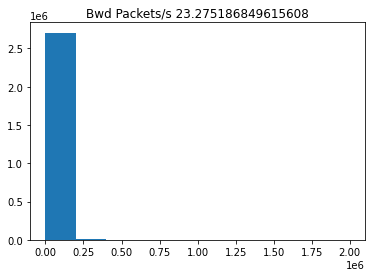

0.0


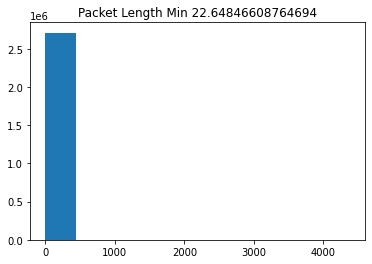

0.0


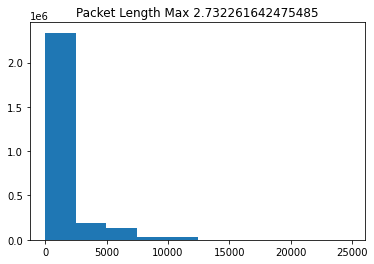

0.0


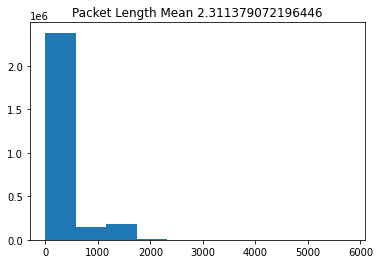

0.0


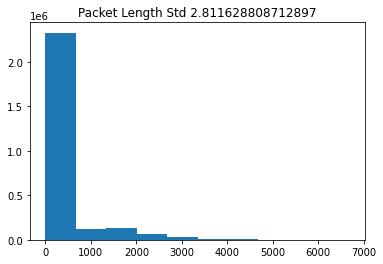

0.0


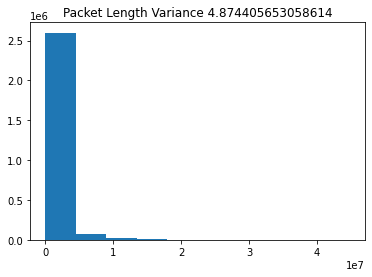

0


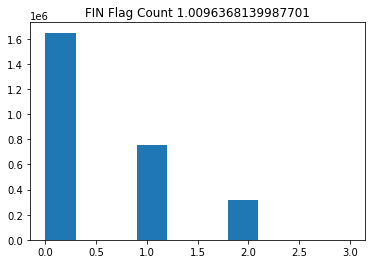

0


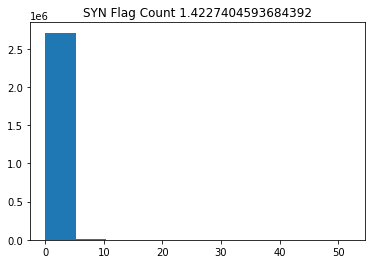

0


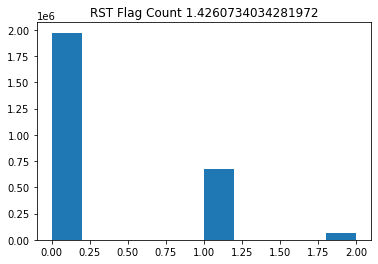

0


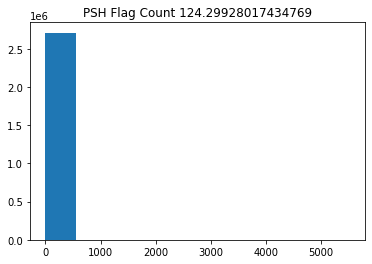

0


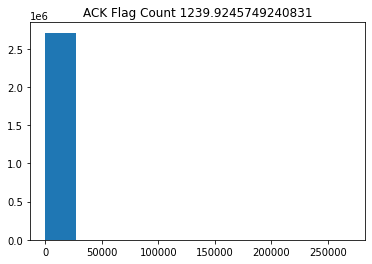

0


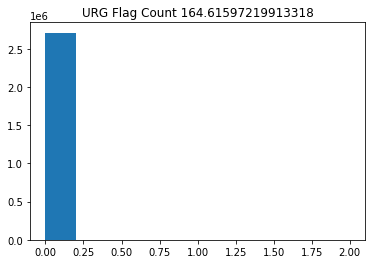

0


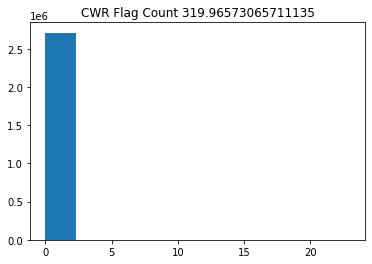

0


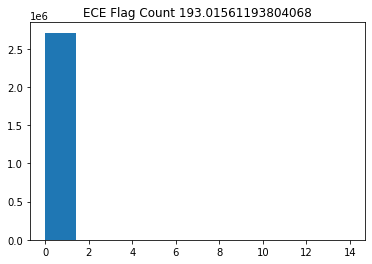

0.0


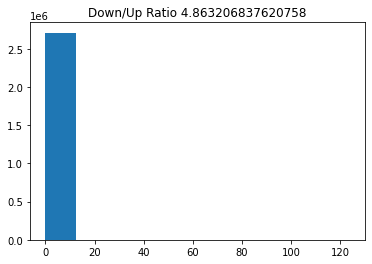

0.0


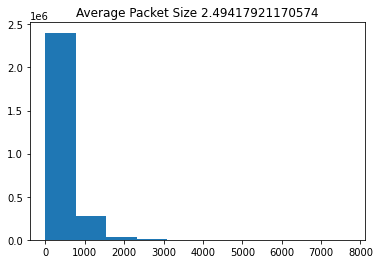

0.0


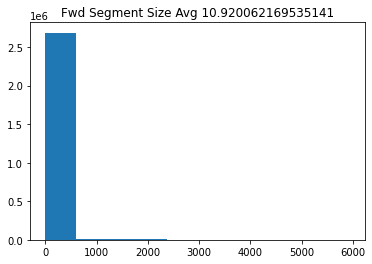

0.0


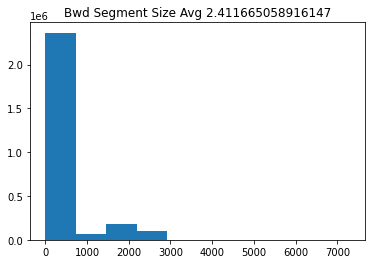

0


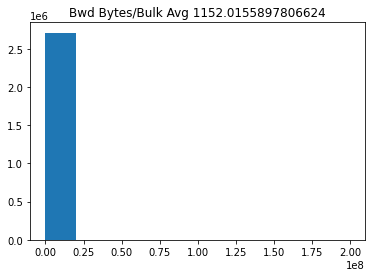

0


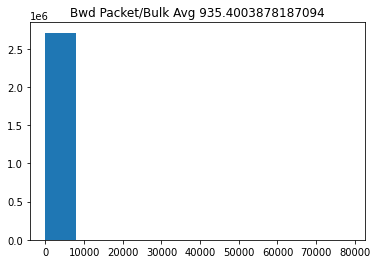

0


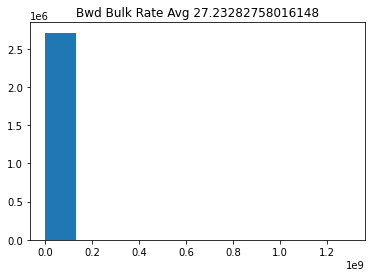

0


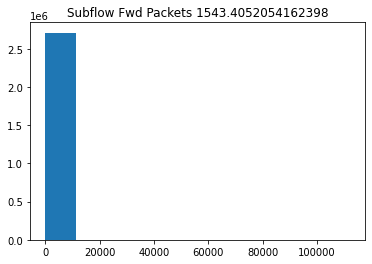

0


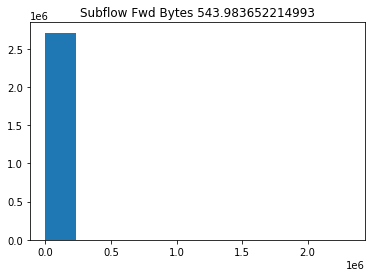

0


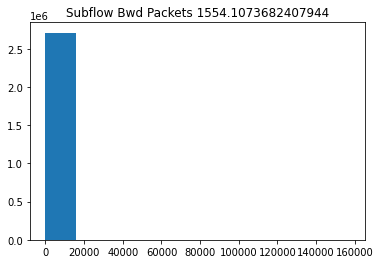

0


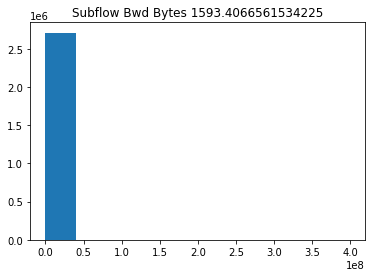

0


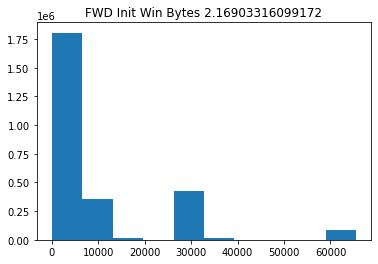

0


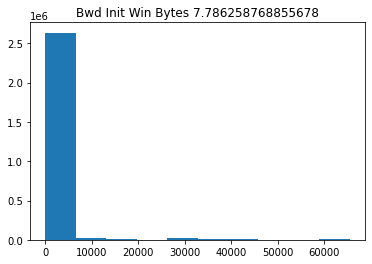

0


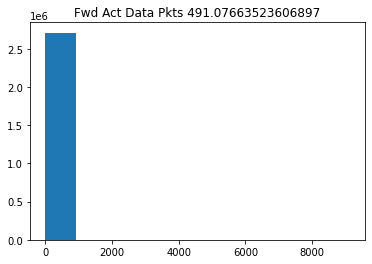

0


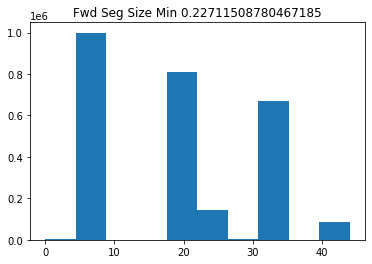

0.0


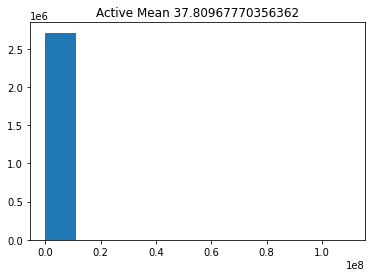

0.0


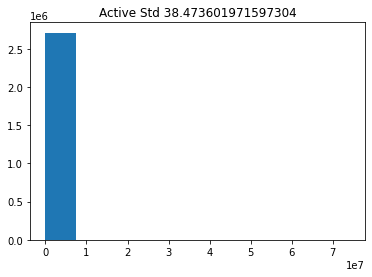

0.0


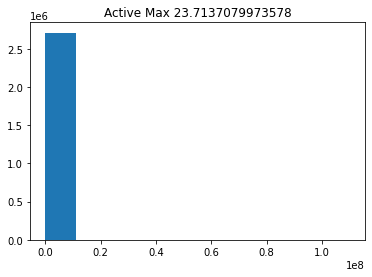

0.0


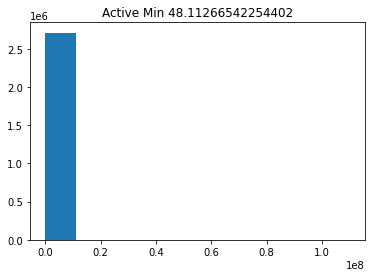

0.0


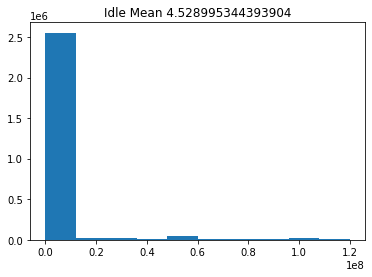

0.0


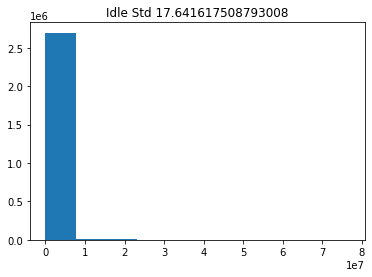

0.0


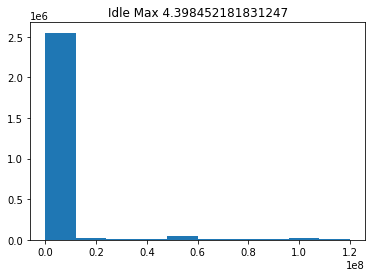

0.0


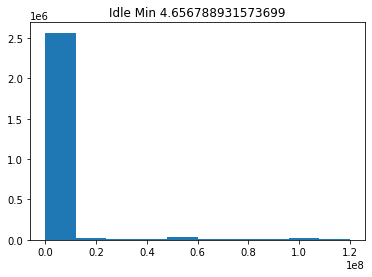

In [15]:
histogram_dataframe(df_proc)

In [16]:
labels = df_proc['Label'].unique()
lb_count = []
for lb in labels:
    lb_count.append(sum(df_proc['Label']==lb))
    print(lb,",",sum(df_proc['Label']==lb))

BENIGN , 2011625
Bot , 2209
PortScan , 159083
DDoS , 163421
DoS slowloris , 5711
DoS Slowhttptest , 5112
DoS Hulk , 337445
DoS GoldenEye , 10471
Heartbleed , 7
FTP-Patator , 10350
SSH-Patator , 5909
Web Attack - Brute Force , 1508
Web Attack - XSS , 702
Web Attack - Sql Injection , 21
Infiltration , 49


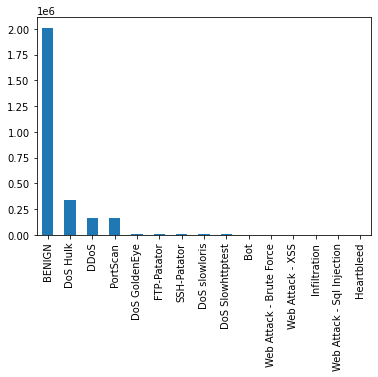

In [17]:
ax = df_proc['Label'].value_counts().plot(kind='bar')
# for i in range(len(labels)):
#     ax.text(i-0.2,100000, str(lb_count[i]), color='red', fontweight='bold')

In [73]:
df_proc.describe()

Dst Port      Protocol  Flow Duration  Total Fwd Packet  \
count  2.713623e+06  2.713623e+06   2.713623e+06      2.713623e+06   
mean   3.721492e+03  1.004785e+01   1.085810e+07      5.768599e+00   
std    1.238622e+04  5.310574e+00   2.935166e+07      7.586947e+01   
min    0.000000e+00  0.000000e+00   1.000000e+00      1.000000e+00   
25%    5.300000e+01  6.000000e+00   2.180000e+02      2.000000e+00   
50%    8.000000e+01  6.000000e+00   4.736000e+04      2.000000e+00   
75%    4.430000e+02  1.700000e+01   1.075726e+06      4.000000e+00   
max    6.553300e+04  1.700000e+01   1.200000e+08      1.121410e+05   

       Total Bwd packets  Total Length of Fwd Packet  \
count       2.713623e+06                2.713623e+06   
mean        5.942002e+00                4.786921e+02   
std         1.050657e+02                9.233499e+03   
min         0.000000e+00                0.000000e+00   
25%         1.000000e+00                0.000000e+00   
50%         2.000000e+00                6.400000e+01   
75%         5.000000e+00                2.060000e+02   
max         1.573880e+05                1.287034e+07   

       Total Length of Bwd Packet  Fwd Packet Length Max  \
count                2.713623e+06           2.713623e+06   
mean                 5.623827e+03           1.798135e+02   
std                  2.558223e+05           5.021433e+02   
min                  0.000000e+00           0.000000e+00   
25%                  0.000000e+00           0.000000e+00   
50%                  1.420000e+02           3.800000e+01   
75%                  7.200000e+02           8.800000e+01   
max                  3.993687e+08           2.482000e+04   

       Fwd Packet Length Min  Fwd Packet Length Mean  ...  Fwd Act Data Pkts  \
count           2.713623e+06            2.713623e+06  ...       2.713623e+06   
mean            2.637445e+01            5.786119e+01  ...       1.707379e+00   
std             1.414150e+02            1.824382e+02  ...       9.568252e+00   
min             0.000000e+00            0.000000e+00  ...       0.000000e+00   
25%             0.000000e+00            0.000000e+00  ...       0.000000e+00   
50%             0.000000e+00            3.500000e+01  ...       1.000000e+00   
75%             3.700000e+01            5.150000e+01  ...       1.000000e+00   
max             5.840000e+03            5.940514e+03  ...       9.130000e+03   

       Fwd Seg Size Min   Active Mean    Active Std    Active Max  \
count      2.713623e+06  2.713623e+06  2.713623e+06  2.713623e+06   
mean       1.939906e+01  7.749767e+04  4.307395e+04  1.524915e+05   
std        1.011795e+01  6.326541e+05  3.979259e+05  1.025614e+06   
min        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%        8.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%        2.000000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
75%        3.200000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
max        4.400000e+01  1.100975e+08  7.415440e+07  1.100975e+08   

         Active Min     Idle Mean      Idle Std      Idle Max      Idle Min  
count  2.713623e+06  2.713623e+06  2.713623e+06  2.713623e+06  2.713623e+06  
mean   5.314498e+04  4.758124e+06  2.007445e+05  4.921412e+06  4.552432e+06  
std    5.571205e+05  1.631381e+07  2.232791e+06  1.666831e+07  1.615379e+07  
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
max    1.100975e+08  1.199997e+08  7.691483e+07  1.199997e+08  1.199997e+08  

[8 rows x 73 columns]

## save processed data frame

In [18]:
df_proc.to_csv("../data/processed_cicids2017.csv")

# Classification

## train/test split

In [19]:
from sklearn.model_selection import train_test_split

In [29]:
train_df, test_df = train_test_split(df_proc, test_size = 0.2, random_state=223)

## standardization

In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [22]:
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

In [23]:
# trainx = train_df.loc[:,train_df.columns!='Label']
# testx = test_df.loc[:,test_df.columns!='Label']

In [24]:
import copy
    
# st_train_df = standard_scaler.fit_transform(trainx)
# st_test_df = standard_scaler.transform(testx)

In [232]:
# mm_train_df = min_max_scaler.fit_transform(trainx)
# mm_test_df = min_max_scaler.transform(testx)

## Binary (attack/benign)

In [164]:
import torch

In [25]:
def set_binary_label(df, label_col, default_class='BENIGN', return_col = False):
    df_y = df[label_col].copy()
    rep_class = {}
    lab_names = df_y.unique()
    for lab in lab_names:
        if lab == default_class:
            rep_class[lab] = 0
        else:
            rep_class[lab] = 1
    if return_col:
        return df_y.replace(rep_class)
    else:
        return df.replace({label_col:rep_class})

In [30]:
train_df_bn = set_binary_label(train_df,label_col='Label', default_class='BENIGN',return_col=False)
test_df_bn = set_binary_label(test_df,label_col='Label', default_class='BENIGN',return_col=False)

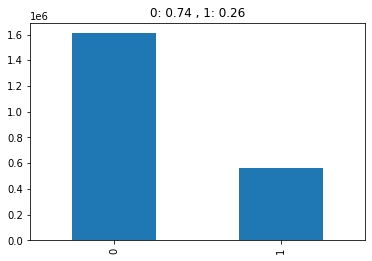

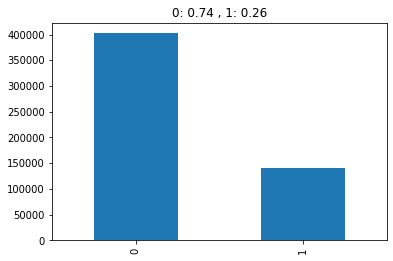

In [69]:
train_num = train_df_bn.shape[0]
test_num = test_df_bn.shape[0]
train_df_bn['Label'].value_counts().plot(kind='bar')
plt.title("0: %0.2f , 1: %0.2f"%(sum(train_df_bn['Label']==0)/train_num,sum(train_df_bn['Label']==1)/train_num))
plt.show()
test_df_bn['Label'].value_counts().plot(kind='bar')
plt.title("0: %0.2f , 1: %0.2f"%(sum(test_df_bn['Label']==0)/test_num,sum(test_df_bn['Label']==1)/test_num))
plt.show()

# Attack detection with ML

In [32]:
trainx = train_df_bn.loc[:,train_df.columns!='Label']
trainy = train_df_bn['Label']
testx = test_df_bn.loc[:,test_df.columns!='Label']
testy = test_df_bn['Label']

In [33]:
trainx_st = standard_scaler.fit_transform(trainx)
testx_st = standard_scaler.transform(testx)

## logistic regression

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
lr_clf = LogisticRegression()

In [49]:
lr_clf.fit(trainx_st, trainy.values)

/home/srp/.pyenv/versions/osrnn/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [50]:
lr_clf.score(testx_st, testy)

0.9351531622829241

In [65]:
from sklearn.metrics import roc_curve, auc

predy = lr_clf.predict_proba(testx_st)
pos_label = 1 # 1 or 0
fpr, tpr, thresholds = roc_curve(testy.values, predy[:,pos_label], pos_label=pos_label)
roc_auc = auc(fpr, tpr)

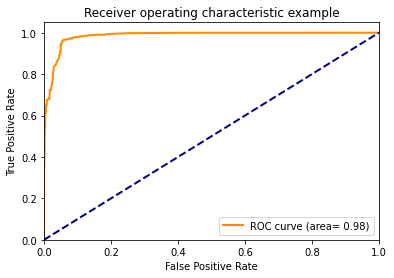

In [68]:
import matplotlib.pyplot as plt

lw=2
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=lw, label ="ROC curve (area= %.2f)"%roc_auc)
plt.plot([0,1],[0,1], color = "navy", lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

## gradient boosting (accuracy 99%)

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

In [71]:
gb_clf = GradientBoostingClassifier(random_state=0)

In [72]:
gb_clf.fit(trainx_st, trainy.values)

GradientBoostingClassifier(random_state=0)

In [74]:
gb_clf.score(testx_st, testy)

0.9925984614675941

In [78]:
predy = gb_clf.predict_proba(testx_st)
pos_label = 1 # 1 or 0
fpr, tpr, thresholds = roc_curve(testy.values, predy[:,pos_label], pos_label=pos_label)
roc_auc = auc(fpr, tpr)

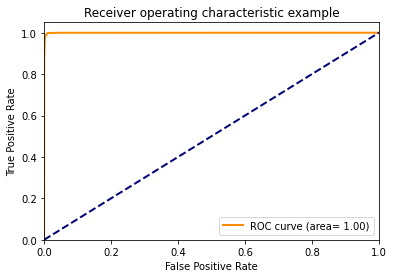

In [79]:
import matplotlib.pyplot as plt

lw=2
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=lw, label ="ROC curve (area= %.2f)"%roc_auc)
plt.plot([0,1],[0,1], color = "navy", lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

## multi-class dataset

In [103]:
lab_cluster = {0: ['Web Attack - Brute Force', 'Web Attack - XSS', 'Web Attack - Sql Injection'],
             1: ['DDoS'],
             2: ['Bot'],
             3: ['DoS slowloris'],
             4: ['DoS Slowhttptest'],
             5: ['DoS Hulk'],
             6: ['DoS GoldenEye'],
             7: ['PortScan'],
             8: ['FTP-Patator'],
#              9: ['SSH-Patator']    
}
lab_name = ['Web Attack','DDoS','Bot','DoS slowloris','DoS Slowhttptest','DoS Hulk','DoS GoldenEye','PortScan',
             'FTP-Patator']#,'SSH-Patator']
lab_dic = {}
for nlab in lab_cluster:
    for lab in lab_cluster[nlab]:
        lab_dic[lab] = nlab
print(lab_dic)

{'Web Attack - Brute Force': 0, 'Web Attack - XSS': 0, 'Web Attack - Sql Injection': 0, 'DDoS': 1, 'Bot': 2, 'DoS slowloris': 3, 'DoS Slowhttptest': 4, 'DoS Hulk': 5, 'DoS GoldenEye': 6, 'PortScan': 7, 'FTP-Patator': 8}


In [104]:
def set_multiple_label(df, label_col, label_dic, return_col = False):
    df_y = df[label_col].copy()
    lab_names = df_y.unique()
    drop_idx = pd.Index([])
#     print(label_dic.keys())
    for lab in lab_names:
        if lab in label_dic.keys():
#             print('pass', lab)
            pass
        else:
            print('drop', lab)
            drop_idx = drop_idx.append(df[df[label_col]==lab].index)  
    print("original instances: ",len(df))
    print("drop intances: ", len(drop_idx))
    df = df.drop(drop_idx)
    print("after drop: ",len(df))
#     del df_y, drop_idx    
    if return_col:
        return df_y.replace(label_dic)
    else:
        return df.replace({label_col:label_dic})

In [105]:
train_mul = set_multiple_label(train_df,label_col='Label', label_dic = lab_dic, return_col=False)
test_mul = set_multiple_label(test_df,label_col='Label', label_dic = lab_dic, return_col=False)

drop BENIGN
drop SSH-Patator
drop Infiltration
drop Heartbleed
original instances:  2170898
drop intances:  1614126
after drop:  556772
drop BENIGN
drop SSH-Patator
drop Heartbleed
drop Infiltration
original instances:  542725
drop intances:  403464
after drop:  139261


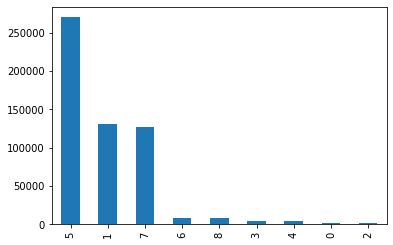

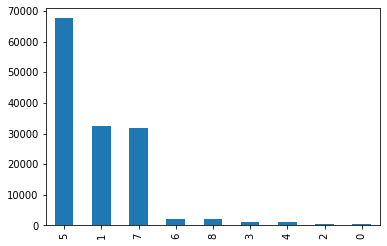

In [106]:
train_mul['Label'].value_counts().plot(kind='bar')
plt.show()
test_mul['Label'].value_counts().plot(kind='bar')
plt.show()

## attack classification

In [107]:
trainx_m = train_mul.loc[:,train_mul.columns!='Label']
trainy_m = train_mul['Label']
testx_m = test_mul.loc[:,test_mul.columns!='Label']
testy_m = test_mul['Label']

In [108]:
trainx_m_st = standard_scaler.fit_transform(trainx_m)
testx_m_st = standard_scaler.transform(testx_m)

In [109]:
lr_clfm = LogisticRegression()

In [110]:
lr_clfm.fit(trainx_m_st, trainy_m)

/home/srp/.pyenv/versions/osrnn/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [111]:
lr_clfm.score(testx_m_st, testy_m)

0.99926756234696

In [112]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [113]:
predy_m = lr_clfm.predict_proba(testx_m_st)

In [154]:
pred_m = lr_clfm.predict(testx_m_st)

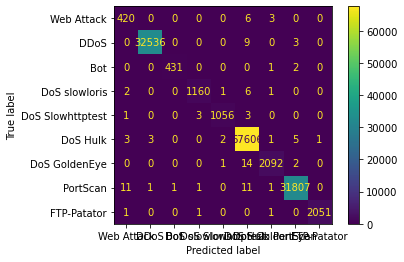

In [116]:
plot = plot_confusion_matrix(lr_clfm, # 분류 모델
                             testx_m_st, testy_m, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=lab_name, # 표에 표시할 labels
#                              cmap=plt.cm.Blue, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None

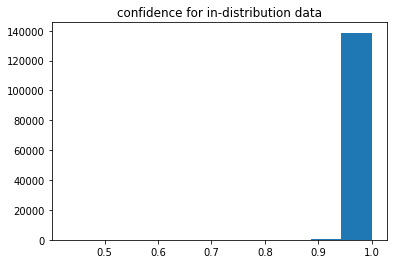

In [153]:
plt.hist(np.max(predy_m,axis=1))
plt.title("confidence for in-distribution data")
plt.show()

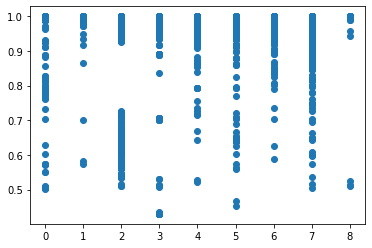

In [155]:
plt.scatter(pred_m,np.max(predy_m,axis=1))
plt.show()

# predict out-of-class

In [128]:
ooc_idx = (train_df['Label']=='SSH-Patator')

In [131]:
train_ooc = train_df.loc[train_df['Label']=='SSH-Patator']
train_ooc = train_ooc.loc[:,train_ooc.columns!='Label']

In [144]:
train_ooc.shape

(4729, 73)

In [135]:
trainx_ooc_st = standard_scaler.transform(train_ooc)

In [140]:
pred_ooc = lr_clfm.predict(trainx_ooc_st)
prob_ooc = lr_clfm.predict_proba(trainx_ooc_st)

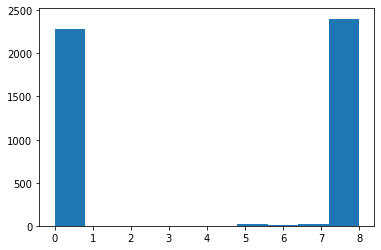

In [157]:
plt.hist(pred_ooc)
plt.show()

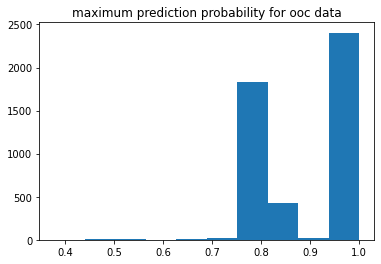

In [147]:
plt.hist(np.max(prob_ooc,axis=1))
plt.title("maximum prediction probability for ooc data")
plt.show()

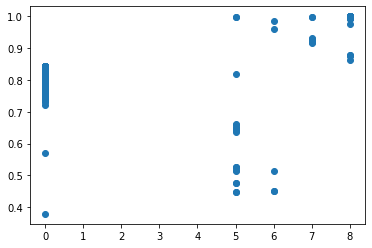

In [149]:
plt.scatter(pred_ooc,np.max(prob_ooc,axis=1),)
plt.show()